<a id='top'></a>

# StatsBomb EURO 2020 Visualisation
##### Notebook to visualise engineered [StatsBomb](https://statsbomb.com/) event and 360 data downloaded from the [Open Data GitHub repository](https://github.com/statsbomb/open-data), using [pandas](http://pandas.pydata.org/) and [matplotlib](https://matplotlib.org/stable/index.html). The resulting code is productionised as a script, [`WebsterViz`](https://github.com/eddwebster/statsbomb/blob/main/scripts/WebsterViz.py), that is used as part Data Analysis notebook.

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 10/01/2022<br>
Notebook last updated: 17/01/2022

![StatsBomb](../img/logos/stats-bomb-logo_small.png)

![EURO 2020](../img/competitions/uefa_euro_2020_small.png)

Click [here](#section4) to jump straight to the Data Visualisation section and skip the [Task Brief](#section2) and [Data Sources](#section3) sections.

___

<a id='introduction'></a>

## <a id='introduction'>Introduction</a>
This notebook parses pubicly available [StatsBomb](https://statsbomb.com/) Event data, using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

For more information about this notebook and the author, I am available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/); and
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster).

A static version of this notebook can be found [here](https://nbviewer.org/github/eddwebster/statsbomb/blob/main/notebooks/StatsBomb%20EURO%202020%20Data%20Visualisation.ipynb). This notebook has an accompanying [`statsbomb`](https://github.com/eddwebster/statsbomb) GitHub repository and for my full repository of football analysis, see my [`football_analysis`](https://github.com/eddwebster/football_analytics) GitHub repository. For the script of productionised function, derived from this notebook, see the [`WebsterViz.py`](https://github.com/eddwebster/statsbomb/blob/main/scripts/WebsterViz.py) script.

___

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Read in the Datasets](#section3.2)<br>
      3.    [Initial Data Handling](#section3.3)<br>
4.    [Data Visualisation](#section4)<br>
      01.    [Drawing a Pitch](#section4.01)<br>
      02.    [Shot Maps](#section4.02)<br>
      03.    [360 Freeze Frames](#section4.03)<br>
      04.    [Cumulative xG Race Charts](#section4.04)<br>
      05.    [OBV Bar Charts](#section4.05)<br>
      06.    [xG](#section4.06)<br>
      07.    [Passing Network](#section4.07)<br>
      08.    [Pass Map](#section4.08)<br>
      09.    [Heat Map](#section4.09)<br>
      10.    [Combined Heat and Pass Map](#section4.10)<br>
      11.    [OBV Maps](#section4.11)<br>
5.    [Summary](#section5)<br>
6.    [Next Steps](#section6)<br>
7.    [References](#section7)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) and [`Seaborn`](https://seaborn.pydata.org/) for data visualisations.

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [29]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import chardet
import random
from io import BytesIO
from pathlib import Path

# Reading Directories
import glob
import os

# Working with JSON
import json
from pandas import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
from matplotlib.colors import ListedColormap
import matplotlib.image as image
import matplotlib.gridspec as gridspec 
import matplotlib.patheffects as path_effects
import seaborn as sns
from PIL import Image
from highlight_text import htext
import missingno as msno
from mplsoccer import Pitch, VerticalPitch

# Requests and downloads
import tqdm
import requests

# Machine Learning
from scipy.spatial import ConvexHull
from scipy import stats

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Print message
print("Setup Complete")

Setup Complete


In [30]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

Python: 3.7.6
NumPy: 1.20.3
pandas: 1.3.2
matplotlib: 3.4.2


### Defined Filepaths

In [31]:
# Set up initial paths to subfolders
base_dir = os.path.join('..')
data_dir = os.path.join(base_dir, 'data')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')

### Create Directory Structure

In [32]:
# Make the directory structure
for folder in ['combined', 'competitions', 'events', 'tactics', 'lineups', 'three-sixty']:
    path = os.path.join(data_dir, 'raw', folder)
    if not os.path.exists(path):
        os.mkdir(path)

### Notebook Settings

In [33]:
# Display all columns of displayed pandas DataFrames
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

---

<a id='section2'></a>

## <a id='#section2'>2. Notebook Brief</a>
The code in this script is used to create the visualisation and analysis submitted for the StatsBomb Pro Services Analyst technical.

All the code has been copy and pasted into a final script, called `webster_viz.py`. However, this notebook is how this code was originally derived and is what was used to test the code and has been made available for reference as part of this technical task.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

<a id='section3.1'></a>

### <a id='#section3.1'>3.1. Introduction</a>
[StatsBomb](https://statsbomb.com/) are a  football analytics, data provider, and data visualisation and analytics tool company, founded by [Ted Knutson](https://twitter.com/mixedknuts). StatsBomb have brought common data analytics practices seen in business and tech to the world of football analytics. Through their platforms and products, StatsBomb offer immediate accessibility to valuable football insights from all major leagues and players across the globe.

![StatsBomb](../img/logos/stats-bomb-logo_small.png)

<a id='section3.2'></a>

### <a id='#section3.2'>3.2. Import Data</a>
This notebook uses the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

In [34]:
# Import engineered CSV file as a pandas DataFrame
df_events = pd.read_csv(os.path.join(data_dir, 'engineered', 'combined', 'euro2020', 'combined_euro_2020_360.csv'))

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (17,44,68,77,78,79,81,82,83,88,89,91,92,97,99,100,101,107,108,111,112,113,115,118,119,120,121,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<a id='section3.3'></a>

### <a id='#section3.3'>3.3. Initial Data Handling</a>

First check the quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [35]:
# Display the first five rows of the DataFrame, df_events
df_events.head()

id  index  period     timestamp  minute  \
0  9427b18a-6b10-411f-90da-3d6240b80c71      1       1  00:00:00.000       0   
1  542c58bf-5c6c-43ca-9d8d-e086c7f08aaf      2       1  00:00:00.000       0   
2  a0dfe8a0-a0b9-443e-89e3-a8ba6596fa33      3       1  00:00:00.000       0   
3  c7156352-f4b7-4140-aa51-6e26fd019a11      4       1  00:00:00.000       0   
4  94dbc5c3-ef37-445e-9154-3d9f9ea9245d      5       1  00:00:00.490       0   

   second  possession  duration  type_id    type_name  possession_team_id  \
0       0           1  0.000000       35  Starting XI                1835   
1       0           1  0.000000       35  Starting XI                1835   
2       0           1  0.000000       18   Half Start                1835   
3       0           1  0.000000       18   Half Start                1835   
4       0           2  1.373215       30         Pass                 796   

  possession_team_name  play_pattern_id play_pattern_name  team_id team_name  \
0              Finland                1      Regular Play     1835   Finland   
1              Finland                1      Regular Play      796    Russia   
2              Finland                1      Regular Play     1835   Finland   
3              Finland                1      Regular Play      796    Russia   
4               Russia                9     From Kick Off      796    Russia   

   tactics_formation                                     tactics_lineup  \
0              352.0  [{'player': {'id': 8667, 'name': 'Lukáš Hrádec...   
1             3421.0  [{'player': {'id': 21298, 'name': 'Matvey Safo...   
2                NaN                                                NaN   
3                NaN                                                NaN   
4                NaN                                                NaN   

                             related_events    location  player_id  \
0                                       NaN         NaN        NaN   
1                                       NaN         NaN        NaN   
2  ['c7156352-f4b7-4140-aa51-6e26fd019a11']         NaN        NaN   
3  ['a0dfe8a0-a0b9-443e-89e3-a8ba6596fa33']         NaN        NaN   
4  ['c0935bbe-3eb4-4a21-9eee-45f380d1f26d']  60.0, 40.0     6299.0   

         player_name  position_id             position_name  \
0                NaN          NaN                       NaN   
1                NaN          NaN                       NaN   
2                NaN          NaN                       NaN   
3                NaN          NaN                       NaN   
4  Aleksey Miranchuk         18.0  Right Attacking Midfield   

   pass_recipient_id pass_recipient_name  pass_length  pass_angle  \
0                NaN                 NaN          NaN         NaN   
1                NaN                 NaN          NaN         NaN   
2                NaN                 NaN          NaN         NaN   
3                NaN                 NaN          NaN         NaN   
4            31917.0         Igor Diveev    22.357325    3.069967   

   pass_height_id pass_height_name pass_end_location  pass_body_part_id  \
0             NaN              NaN               NaN                NaN   
1             NaN              NaN               NaN                NaN   
2             NaN              NaN               NaN                NaN   
3             NaN              NaN               NaN                NaN   
4             1.0      Ground Pass        37.7, 41.6               38.0   

  pass_body_part_name  pass_type_id pass_type_name carry_end_location  \
0                 NaN           NaN            NaN                NaN   
1                 NaN           NaN            NaN                NaN   
2                 NaN           NaN            NaN                NaN   
3                 NaN           NaN            NaN                NaN   
4           Left Foot          65.0       Kick Off                NaN   

  under_pressure  duel_type_id duel_type_name pass_aeria

In [36]:
# Display the last five rows of the DataFrame, df_events
df_events.tail()

id  index  period     timestamp  \
192681  8aa68a18-79d2-4b8b-ba5f-9d3124f1cd20   2993       2  00:50:23.150   
192682  a0bdd045-65d0-4601-9378-a5dacdba3257   2994       2  00:50:24.021   
192683  dcbfc5e1-b22f-460f-8132-cf6fe7a590f8   2995       2  00:50:24.021   
192684  97cb188e-82e3-49cb-9ccf-9a5346f042b1   2996       2  00:50:25.404   
192685  edfa93d5-a744-41a4-a10d-f1d09017011d   2997       2  00:50:25.404   

        minute  second  possession  duration  type_id      type_name  \
192681      95      23         151   0.87093       30           Pass   
192682      95      24         151       NaN       42  Ball Receipt*   
192683      95      24         151   0.00000       10   Interception   
192684      95      25         151   0.00000       34       Half End   
192685      95      25         151   0.00000       34       Half End   

        possession_team_id possession_team_name  play_pattern_id  \
192681                 907                Wales                4   
192682                 907                Wales                4   
192683                 907                Wales                4   
192684                 907                Wales                4   
192685                 907                Wales                4   

       play_pattern_name  team_id    team_name  tactics_formation  \
192681     From Throw In      907        Wales                NaN   
192682     From Throw In      907        Wales                NaN   
192683     From Throw In      773  Switzerland                NaN   
192684     From Throw In      773  Switzerland                NaN   
192685     From Throw In      907        Wales                NaN   

       tactics_lineup                                     related_events  \
192681            NaN  ['a0bdd045-65d0-4601-9378-a5dacdba3257', 'dcbf...   
192682            NaN           ['8aa68a18-79d2-4b8b-ba5f-9d3124f1cd20']   
192683            NaN           ['8aa68a18-79d2-4b8b-ba5f-9d3124f1cd20']   
192684            NaN           ['edfa93d5-a744-41a4-a10d-f1d09017011d']   
192685            NaN           ['97cb188e-82e3-49cb-9ccf-9a5346f042b1']   

          location  player_id        player_name  position_id  \
192681  110.7, 0.1     3086.0         Ben Davies          6.0   
192682  113.7, 8.0     6399.0  Gareth Frank Bale         16.0   
192683   7.5, 74.2     8814.0        Nico Elvedi          3.0   
192684         NaN        NaN                NaN          NaN   
192685         NaN        NaN                NaN          NaN   

            position_name  pass_recipient_id pass_recipient_name  pass_length  \
192681          Left Back             6399.0   Gareth Frank Bale     6.103278   
192682      Left Midfield                NaN                 NaN          NaN   
192683  Right Center Back                NaN                 NaN          NaN   
192684                NaN                NaN                 NaN          NaN   
192685                NaN                NaN                 NaN          NaN   

        pass_angle  pass_height_id pass_height_name pass_end_location  \
192681    1.254227             2.0         Low Pass        112.6, 5.9   
192682         NaN             NaN              NaN               NaN   
192683         NaN             NaN              NaN               NaN   
192684         NaN             NaN              NaN               NaN   
192685         NaN             NaN              NaN               NaN   

        pass_body_part_id pass_body_part_name  pass_type_id pass_type_name  \
192681                NaN                 NaN          67.0       Throw-in   
192682                NaN                 NaN           NaN            NaN   
192683                NaN                 NaN           NaN            NaN   
192684                NaN                 NaN           NaN            NaN   
192685                NaN                 NaN           NaN            NaN   

       carry_end_location under_pressure  duel_type_id duel_type_name  \
192681

In [37]:
# Print the shape of the DataFrame, df_events
print(df_events.shape)

(192686, 174)


In [38]:
# Print the column names of the DataFrame, df_events
print(df_events.columns)

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'type_id', 'type_name',
       ...
       'next_event', 'previous_event', 'next_team_possession',
       'previous_team_possession', 'possession_retained', 'endloc_x',
       'endloc_y', 'dist1', 'dist2', 'diffdist'],
      dtype='object', length=174)


In [39]:
# Data types of the features of the raw DataFrame, df_events
df_events.dtypes

id            object
index          int64
period         int64
timestamp     object
minute         int64
              ...   
endloc_x     float64
endloc_y     float64
dist1        float64
dist2        float64
diffdist     float64
Length: 174, dtype: object

Full details of these attributes and their data types is discussed further in the [Data Dictionary](section3.2.2).

In [40]:
# Displays all columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_events.dtypes)

id                                   object
index                                 int64
period                                int64
timestamp                            object
minute                                int64
second                                int64
possession                            int64
duration                            float64
type_id                               int64
type_name                            object
possession_team_id                    int64
possession_team_name                 object
play_pattern_id                       int64
play_pattern_name                    object
team_id                               int64
team_name                            object
tactics_formation                   float64
tactics_lineup                       object
related_events                       object
location                             object
player_id                           float64
player_name                          object
position_id                     

In [41]:
# Print statements about the dataset

## Define variables for print statments
count_matches = df_events['match_id'].nunique() 
count_events = len(df_events)
count_shots = len(df_events[(df_events['type_name'] == 'Shot')])
count_goals = len(df_events[(df_events['type_name'] == 'Shot') & (df_events['shot_outcome_name'] == 'Goal')])
cols = list(df_events)
count_event_type = len(df_events['type_name'].unique())
vals_event_type = df_events['type_name'].unique()

## Print statements
print(f'The EURO 2020 Events DataFrame contains the data for {count_matches:,} matches, of which there are {count_events:,} total events.\n')
print(f'Of these events, there are {count_shots:,} shots ({round(100*count_shots/count_events,1)}%) and {count_goals:,} goals ({round(100*count_goals/count_events,1)}%).\n')
print(f'This translates to a shot to goal conversion percentage of {round(100*count_goals/count_shots, 1)}%.\n')
print(f'The dataset contains the following features: {cols}\n')
print(f'The \'event_type\' column contain {count_event_type:,} different values, including the following: {vals_event_type}\n')    

The EURO 2020 Events DataFrame contains the data for 51 matches, of which there are 192,686 total events.

Of these events, there are 1,289 shots (0.7%) and 155 goals (0.1%).

This translates to a shot to goal conversion percentage of 12.0%.

The dataset contains the following features: ['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'duration', 'type_id', 'type_name', 'possession_team_id', 'possession_team_name', 'play_pattern_id', 'play_pattern_name', 'team_id', 'team_name', 'tactics_formation', 'tactics_lineup', 'related_events', 'location', 'player_id', 'player_name', 'position_id', 'position_name', 'pass_recipient_id', 'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id', 'pass_height_name', 'pass_end_location', 'pass_body_part_id', 'pass_body_part_name', 'pass_type_id', 'pass_type_name', 'carry_end_location', 'under_pressure', 'duel_type_id', 'duel_type_name', 'pass_aerial_won', 'counterpress', 'duel_outcome_id', 'duel_outcome_name', 'drib

Counts of the event types:

In [42]:
# Shot outcomes types and their frequency
df_events.groupby(['type_name']).type_name.count()

type_name
50/50                   56
Bad Behaviour           26
Ball Receipt*        52722
Ball Recovery         4443
Block                 1770
Carry                43800
Clearance             2283
Dispossessed          1087
Dribble               1475
Dribbled Past          894
Duel                  3354
Error                   24
Foul Committed        1394
Foul Won              1337
Goal Keeper           1514
Half End               244
Half Start             244
Injury Stoppage        288
Interception          1460
Miscontrol            1273
Offside                  9
Own Goal Against        11
Own Goal For            11
Pass                 54820
Player Off              22
Player On               21
Pressure             15955
Referee Ball-Drop      121
Shield                  58
Shot                  1289
Starting XI            102
Substitution           454
Tactical Shift         125
Name: type_name, dtype: int64

Counts of the outcome of all shots:

In [43]:
# Filter DataFrame for only shots and then groupby the 'typeName' (Event type) and count the number of each
df_events[(df_events['type_name'] == 'Shot')].groupby(['shot_outcome_name']).shot_outcome_name.count()

shot_outcome_name
Blocked             337
Goal                155
Off T               416
Post                 31
Saved               283
Saved Off Target      6
Saved to Post         5
Wayward              56
Name: shot_outcome_name, dtype: int64

There are eight outcomes of a shot: 'Blocked', 'Goal', 'Off T', 'Post', 'Saved', 'Saved Off Target', 'Saved to Post', 'Wayward'.

In [44]:
# Filter DataFrame for only shots and then groupby the 'typeName' (Event type) and count the number of each
df_events[(df_events['type_name'] == 'Shot')].groupby(['shot_type_name']).shot_type_name.count()

shot_type_name
Free Kick      41
Open Play    1193
Penalty        55
Name: shot_type_name, dtype: int64

In [45]:
# Info for the raw DataFrame, df_events
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192686 entries, 0 to 192685
Columns: 174 entries, id to diffdist
dtypes: float64(52), int64(13), object(109)
memory usage: 255.8+ MB


<AxesSubplot:>

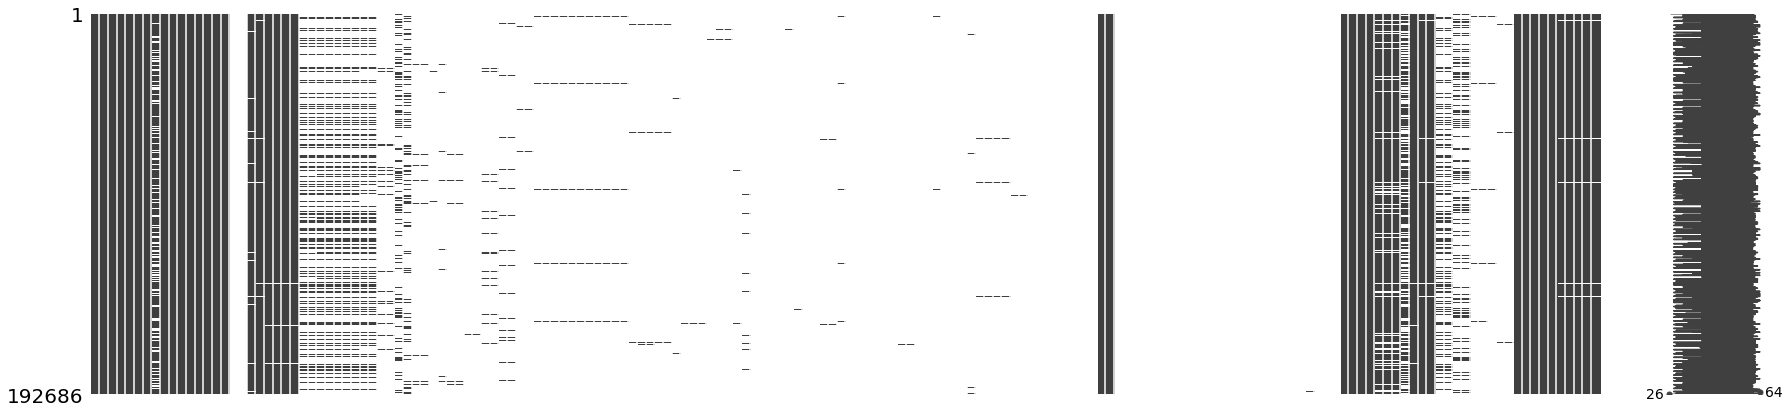

In [46]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_shots_raw
msno.matrix(df_events, figsize = (30, 7))

In [47]:
# Counts of missing values
null_value_stats = df_events.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

duration              52722
tactics_formation    192459
tactics_lineup       192459
related_events         7079
location               1530
                      ...  
endloc_x               1530
endloc_y               1530
dist1                  1530
dist2                  1530
diffdist               1530
Length: 152, dtype: int64

___

<a id='section4'></a>

## <a id='#section4'>4. Data Visualisation</a>

<a id='section4.01'></a>

### <a id='#section4.01'>4.01. Drawing a Pitch</a>
Custom function to draw a football pitch in matplotlib by [Peter McKeever](https://twitter.com/petermckeever). See: http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/.

In [48]:
# Custom function to draw a football pitch in matplotlib by Peter McKeever (@petermckeever). See: http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/
def draw_pitch(x_min=0,
                   x_max=106,
                   y_min=0,
                   y_max=68,
                   pitch_color="w",
                   line_color="grey",
                   line_thickness=1.5,
                   point_size=20,
                   orientation="horizontal",
                   aspect="full",
                   ax=None
                  ):

    if not ax:
        raise TypeError("This function is intended to be used with an existing fig and ax in order to allow flexibility in plotting of various sizes and in subplots.")


    if orientation.lower().startswith("h"):
        first = 0
        second = 1
        arc_angle = 0

        if aspect == "half":
            ax.set_xlim(x_max / 2, x_max + 5)

    elif orientation.lower().startswith("v"):
        first = 1
        second = 0
        arc_angle = 90

        if aspect == "half":
            ax.set_ylim(x_max / 2, x_max + 5)

    
    else:
        raise NameError("You must choose one of horizontal or vertical")

    
    ax.axis("off")

    rect = plt.Rectangle((x_min, y_min),
                         x_max, y_max,
                         facecolor=pitch_color,
                         edgecolor="none",
                         zorder=-2)

    ax.add_artist(rect)

    x_conversion = x_max / 100
    y_conversion = y_max / 100

    pitch_x = [0,5.8,11.5,17,50,83,88.5,94.2,100] # pitch x markings
    pitch_x = [x * x_conversion for x in pitch_x]

    pitch_y = [0, 21.1, 36.6, 50, 63.2, 78.9, 100] # pitch y markings
    pitch_y = [x * y_conversion for x in pitch_y]

    goal_y = [45.2, 54.8] # goal posts
    goal_y = [x * y_conversion for x in goal_y]

    # side and goal lines
    lx1 = [x_min, x_max, x_max, x_min, x_min]
    ly1 = [y_min, y_min, y_max, y_max, y_min]

    # outer boxed
    lx2 = [x_max, pitch_x[5], pitch_x[5], x_max]
    ly2 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    lx3 = [0, pitch_x[3], pitch_x[3], 0]
    ly3 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    # goals
    lx4 = [x_max, x_max+2, x_max+2, x_max]
    ly4 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    lx5 = [0, -2, -2, 0]
    ly5 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    # 6 yard boxes
    lx6 = [x_max, pitch_x[7], pitch_x[7], x_max]
    ly6 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]

    lx7 = [0, pitch_x[1], pitch_x[1], 0]
    ly7 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]


    # Halfway line, penalty spots, and kickoff spot
    lx8 = [pitch_x[4], pitch_x[4]]
    ly8 = [0, y_max]

    lines = [
        [lx1, ly1],
        [lx2, ly2],
        [lx3, ly3],
        [lx4, ly4],
        [lx5, ly5],
        [lx6, ly6],
        [lx7, ly7],
        [lx8, ly8],
        ]

    points = [
        [pitch_x[6], pitch_y[3]],
        [pitch_x[2], pitch_y[3]],
        [pitch_x[4], pitch_y[3]]
        ]

    circle_points = [pitch_x[4], pitch_y[3]]
    arc_points1 = [pitch_x[6], pitch_y[3]]
    arc_points2 = [pitch_x[2], pitch_y[3]]


    for line in lines:
        ax.plot(line[first], line[second],
                color=line_color,
                lw=line_thickness,
                zorder=-1)

    for point in points:
        ax.scatter(point[first], point[second],
                   color=line_color,
                   s=point_size,
                   zorder=-1)

    circle = plt.Circle((circle_points[first], circle_points[second]),
                        x_max * 0.088,
                        lw=line_thickness,
                        color=line_color,
                        fill=False,
                        zorder=-1)

    ax.add_artist(circle)

    arc1 = Arc((arc_points1[first], arc_points1[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=128.75,
               theta2=231.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc1)

    arc2 = Arc((arc_points2[first], arc_points2[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=308.75,
               theta2=51.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc2)

    ax.set_aspect("equal")

    return ax

<a id='section4.02'></a>

### <a id='#section4.02'>4.02. Shot Maps</a>

<a id='section4.02.1'></a>

#### <a id='#section4.02.1'>4.02.1. Team Shot Map</a>

In [49]:
## Define function for plotting a DataFrame of shots for a team
def create_shot_map_team(df,
                         team_name,
                         team_colour,
                         pitch_length_x,
                         pitch_length_y,
                         orientation,
                         aspect,
                        ):

    """
    Function to create a shot map for an individual team, utilising the 'draw_pitch' function, created by Peter McKeever @petermckeever.
    """

    ## Data Engineering
    
    ### Exclude penalties
    df = df[df['shot_type_name'] != 'Penalty']
    
    ### Select only shots from the DataFrame if full events dataset passed through
    df_shots = df[(df['type_name'] == 'Shot') & (df['shot_outcome_name'] != 'Goal') & (df['team_name'] == team_name)]
    df_goals = df[(df['type_name'] == 'Shot') & (df['shot_outcome_name'] == 'Goal') & (df['team_name'] == team_name)]
    df_shots_and_goals = df[(df['type_name'] == 'Shot') & (df['team_name'] == team_name)]

    ### Determine the total number of shots
    total_shots = len(df_shots)
    total_goals = len(df_goals)

    ### Determine the total nxG
    total_xg = df_shots_and_goals['shot_statsbomb_xg'].sum().round(2)

    ### Define X and Y values
    y_shots = df_shots['location_x'].tolist()
    x_shots = df_shots['location_y'].tolist()
    y_goals = df_goals['location_x'].tolist()
    x_goals = df_goals['location_y'].tolist()


    ## Data Visualisation

    ### Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    ### Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)

    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    ### Draw the pitch using the 
    draw_pitch(x_min=0,
               x_max=pitch_length_x,
               y_min=0,
               y_max=pitch_length_y,
               orientation=orientation,
               aspect=aspect,
               pitch_color=background,
               line_color='#3B3B3B',
               ax=ax
              )

    ## Add Z variable for xG
    z1 = df_shots['shot_statsbomb_xg'].tolist()
    z1 = [1000 * i for i in z1]
    z2 = df_goals['shot_statsbomb_xg'].tolist()
    z2 = [1000 * i for i in z2]

    ### Define Z order
    zo = 12
    
    ## Add small legend in the bottom corner
    mSize = [0.05, 0.10, 0.2, 0.4, 0.6, 1]
    mSizeS = [1000 * i for i in mSize]
    mx = [1.5, 3.0, 5.0, 7.5, 10.625, 14.25]
    my = [115, 115, 115, 115, 115, 115]
    ax.text(7.875,
            110.5,
            'xG',
            color='#3B3B3B',
            ha='center',
            va='center',
            zorder=zo,
            fontsize=16
           )

    ### Create scatter plot of shots
    ax.scatter(x_shots,
               y_shots,
               marker='o',
               color='red',
               edgecolors='black',
              #linewidths=0.5,
               s=z1,
               alpha=0.7,
               zorder=zo,
               label='Shots'
              )

    ### Create scatter plot of goals
    ax.scatter(x_goals,
               y_goals,
               marker='*',
               color='green',
               edgecolors='black',
              #linewidths=0.5,
               s=z2,
               alpha=0.7,
               zorder=zo,
               label='Goals'
              )

    ### 
    ax.scatter(mx, my,s=mSizeS, facecolors='#3B3B3B', edgecolor='#3B3B3B', zorder=zo)
    ax.plot([1.5, 14.25], [112.25,112.25], color='#3B3B3B', lw=2, zorder=zo)

    ### 
    i = 0
    for i in range(len(mx)):
        ax.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*14, color='white', zorder=zo, ha='center', va='center')


    ### Show Legend
    plt.legend()

    ### Add Plot Title
    s = '<{}>\'s Shot Map of {:,} shots and {:,} goals ({} xG)\n'
    htext.fig_htext(s.format(team_name, total_shots, total_goals, total_xg), 0.13, 0.945, highlight_colors=[team_colour], highlight_weights=['bold'], string_weight='bold', fontsize=23, fontfamily=title_font, color=text_colour)


    ### Add Plot Subtitle
    fig.text(0.13, 0.955, f'EURO 2020', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)


    ### Add UEFA EURO 2020 logo
    #ax2 = fig.add_axes([0.765, 0.769, 0.12, 0.12])
    ax2 = fig.add_axes([0.115, 0.035, 0.12, 0.12])
    ax2.axis('off')
    img = image.imread('../img/competitions/uefa_euro_2020.png')
    ax2.imshow(img)


    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.63, -0.018, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)


    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.792, 0.0235, 0.07, 0.07])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)


    ### Footnote
    plt.figtext(0.13,
                -0.03,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb. Excluding penalties.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )


    ### Save figure
    if not os.path.exists(fig_dir + f'/shots_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/shots_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

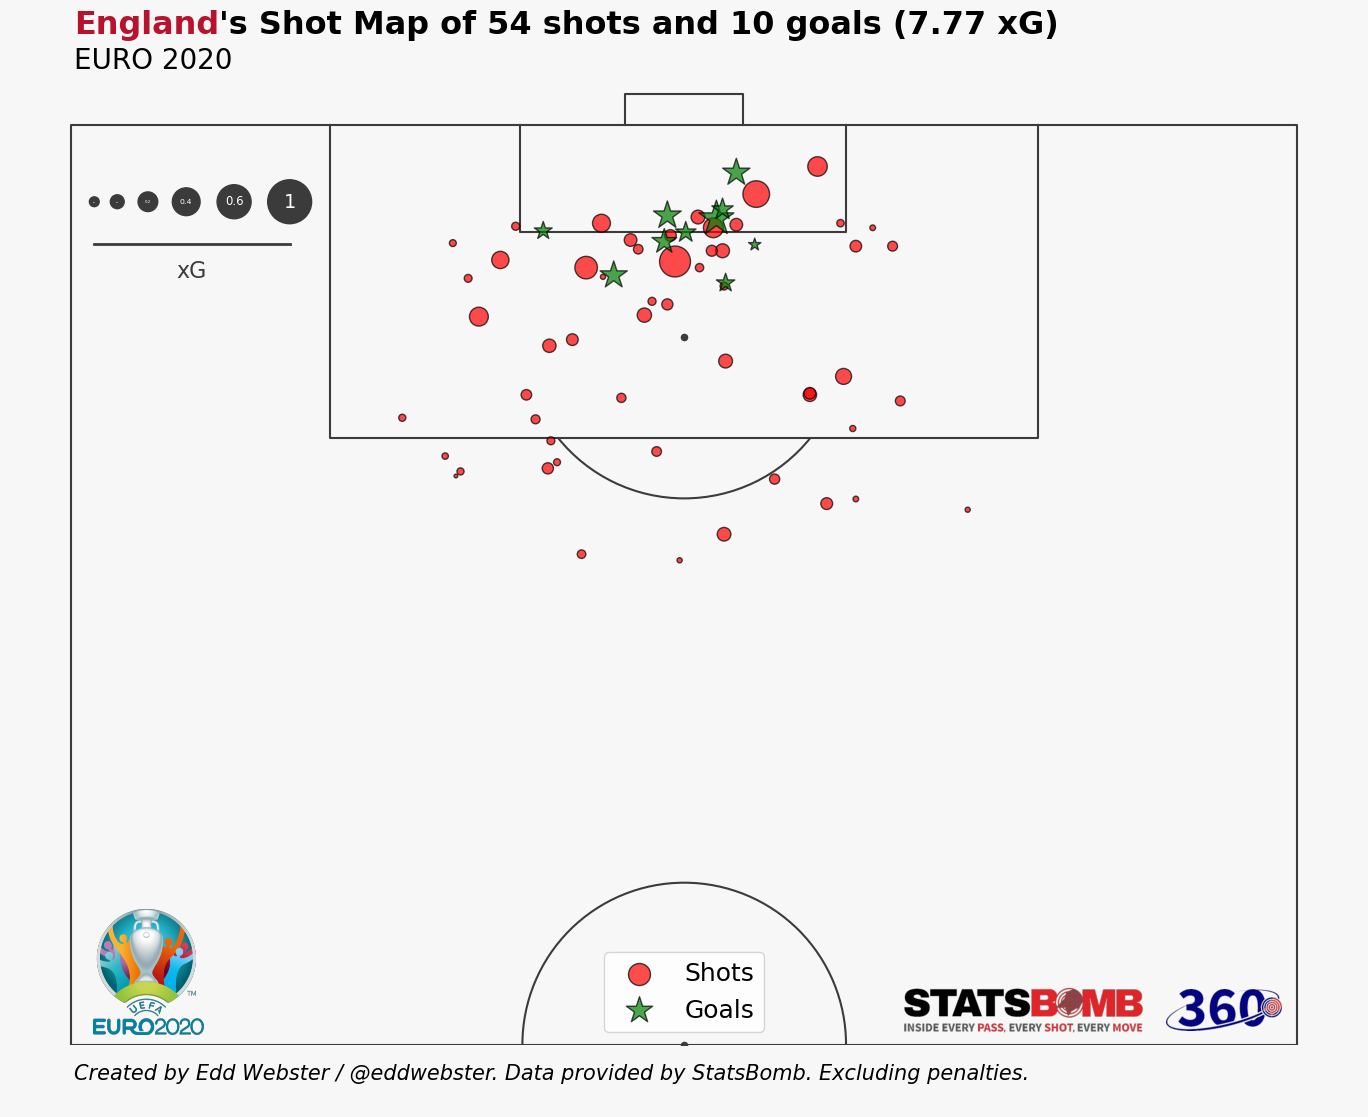

In [50]:
create_shot_map_team(df=df_events,
                     team_name='England',
                     team_colour='#b8132d',
                     pitch_length_x=120,
                     pitch_length_y=80,
                     orientation='vertical',    # 'horizontal'
                     aspect='half'              #'fll'
                    )

<a id='section4.02.2'></a>

#### <a id='#section4.02.2'>4.02.2.Individual Player Shot Map</a>

In [51]:
## Define function for plotting a DataFrame of shots
def create_shot_map_player(df,
                           player_name,
                           team_of_interest,
                           team_colour,
                           pitch_length_x,
                           pitch_length_y,
                           orientation,
                           aspect,
                          ):

    """
    Function to create a shot map for individual players, utilising the 'draw_pitch' function, created by Peter McKeever @petermckeever.
    """

    ## Data Engineering
    
    ### Exclude penalties
    df = df[df['shot_type_name'] != 'Penalty']
    
    ### Select only shots from the DataFrame if full events dataset passed through
    df_shots = df[(df['type_name'] == 'Shot') & (df['shot_outcome_name'] != 'Goal') & (df['player_name'] == player_name)]
    df_goals = df[(df['type_name'] == 'Shot') & (df['shot_outcome_name'] == 'Goal') & (df['player_name'] == player_name)]
    df_shots_and_goals = df[(df['type_name'] == 'Shot') & (df['player_name'] == player_name)]

    ### Determine the total number of shots
    total_shots = len(df_shots)
    total_goals = len(df_goals)

    ### Determine the total nxG
    total_xg = df_shots_and_goals['shot_statsbomb_xg'].sum().round(2)

    ### Define X and Y values
    y_shots = df_shots['location_x'].tolist()
    x_shots = df_shots['location_y'].tolist()
    y_goals = df_goals['location_x'].tolist()
    x_goals = df_goals['location_y'].tolist()


    ## Data Visualisation

    ### Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    ### Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)

    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    ### Draw the pitch using the 
    draw_pitch(x_min=0,
               x_max=pitch_length_x,
               y_min=0,
               y_max=pitch_length_y,
               orientation=orientation,
               aspect=aspect,
               pitch_color=background,
               line_color='#3B3B3B',
               ax=ax
              )

    ## Add Z variable for xG
    z1 = df_shots['shot_statsbomb_xg'].tolist()
    z1 = [1000 * i for i in z1]
    z2 = df_goals['shot_statsbomb_xg'].tolist()
    z2 = [1000 * i for i in z2]

    ### Define Z order
    zo = 12
    
    ## Add small legend in the bottom corner
    mSize = [0.05, 0.10, 0.2, 0.4, 0.6, 1]
    mSizeS = [1000 * i for i in mSize]
    mx = [1.5, 3.0, 5.0, 7.5, 10.625, 14.25]
    my = [115, 115, 115, 115, 115, 115]
    ax.text(7.875,
            110.5,
            'xG',
            color='#3B3B3B',
            ha='center',
            va='center',
            zorder=zo,
            fontsize=16
           )

    ### Create scatter plot of shots
    ax.scatter(x_shots,
               y_shots,
               marker='o',
               color='red',
               edgecolors='black',
              #linewidths=0.5,
               s=z1,
               alpha=0.7,
               zorder=zo,
               label='Shots'
              )

    ### Create scatter plot of goals
    ax.scatter(x_goals,
               y_goals,
               marker='*',
               color='green',
               edgecolors='black',
              #linewidths=0.5,
               s=z2,
               alpha=0.7,
               zorder=zo,
               label='Goals'
              )

    ### 
    ax.scatter(mx, my,s=mSizeS, facecolors='#3B3B3B', edgecolor='#3B3B3B', zorder=zo)
    ax.plot([1.5, 14.25], [112.25,112.25], color='#3B3B3B', lw=2, zorder=zo)

    ### 
    i = 0
    for i in range(len(mx)):
        ax.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*14, color='white', zorder=zo, ha='center', va='center')


    ### Show Legend
    plt.legend()

    ### Add Plot Title
    s = '{}\'s Shot Map of {:,} shots and {:,} goals for <{}> ({} xG)\n'
    htext.fig_htext(s.format(player_name, total_shots, total_goals, team_of_interest, total_xg), 0.13, 0.945, highlight_colors=[team_colour], highlight_weights=['bold'], string_weight='bold', fontsize=23, fontfamily=title_font, color=text_colour)


    ### Add Plot Subtitle
    fig.text(0.13, 0.955, f'EURO 2020', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)


    ### Add UEFA EURO 2020 logo
    #ax2 = fig.add_axes([0.765, 0.769, 0.12, 0.12])
    ax2 = fig.add_axes([0.115, 0.035, 0.12, 0.12])
    ax2.axis('off')
    img = image.imread('../img/competitions/uefa_euro_2020.png')
    ax2.imshow(img)


    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.63, -0.018, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)


    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.792, 0.0235, 0.07, 0.07])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)


    ### Footnote
    plt.figtext(0.13,
                -0.03,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb. Excluding penalties.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )


    ### Save figure
    if not os.path.exists(fig_dir + f'/shots_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/shots_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

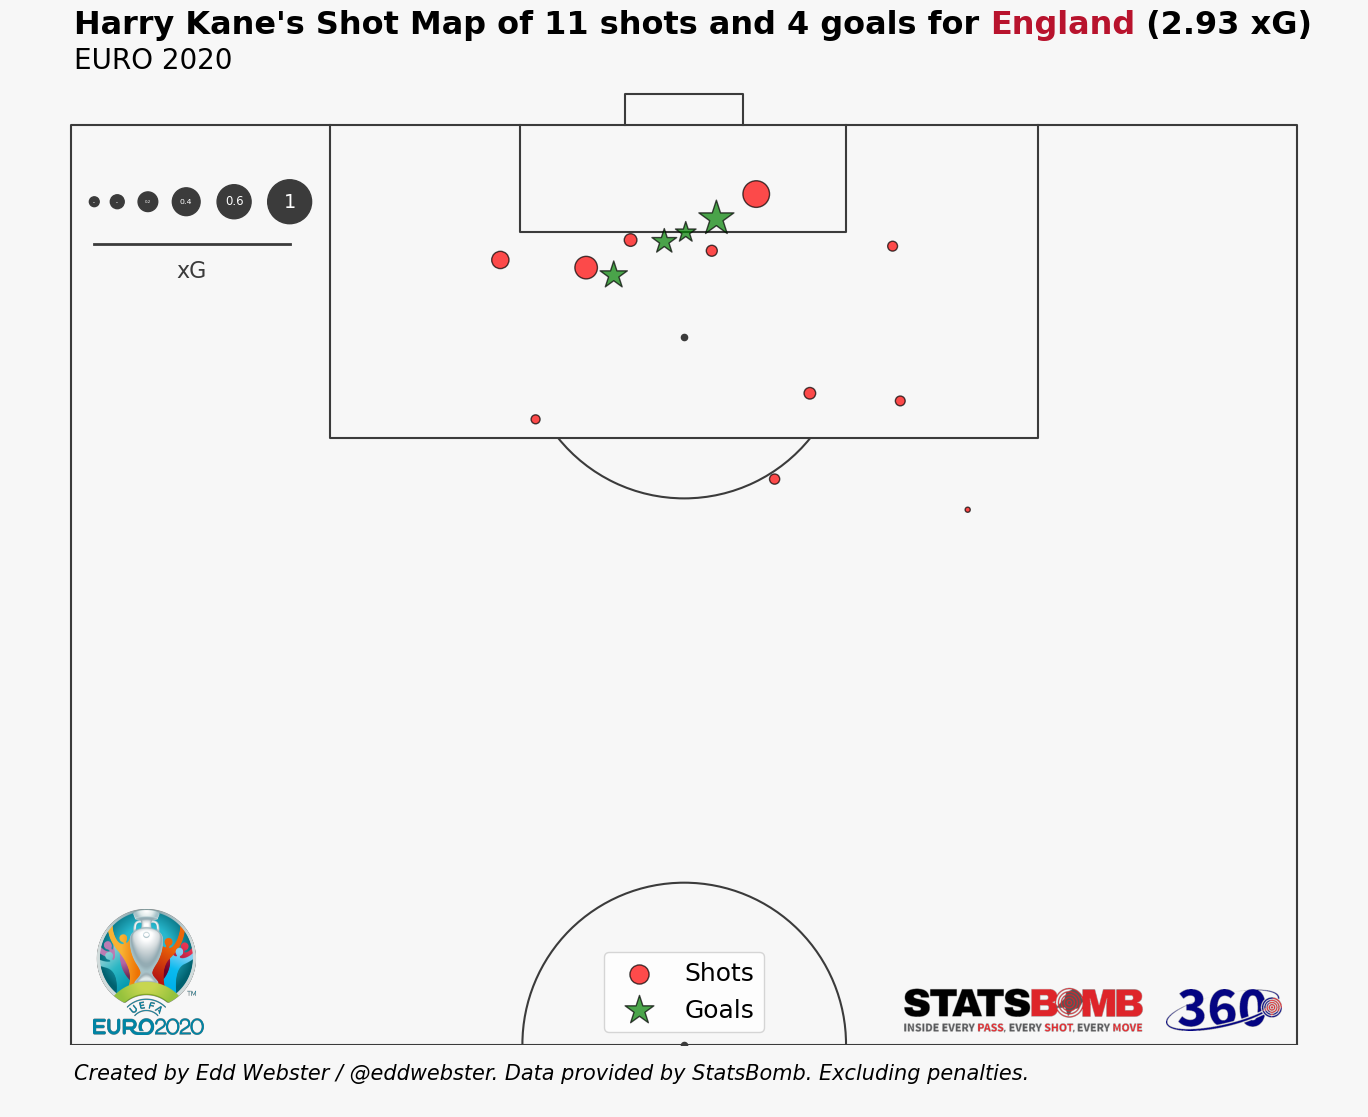

In [52]:
create_shot_map_player(df=df_events,
                       player_name='Harry Kane',
                       team_of_interest='England',
                       team_colour='#b8132d',
                       pitch_length_x=120,
                       pitch_length_y=80,
                       orientation='vertical',    # 'horizontal'
                       aspect='half'              #'fll'
                      )

<a id='section4.03'></a>

### <a id='#section4.03'>4.03. 360 Freeze Frames</a>
Using StatsBomb 360 data, plot the positions of all the players for a selected frame.

In [53]:
match_id = 3788745

In [54]:
## load in Statsbomb360 data remotely 
data = requests.get(f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/three-sixty/{match_id}.json").json()
## `print(data)` to check out the data returned and available fields

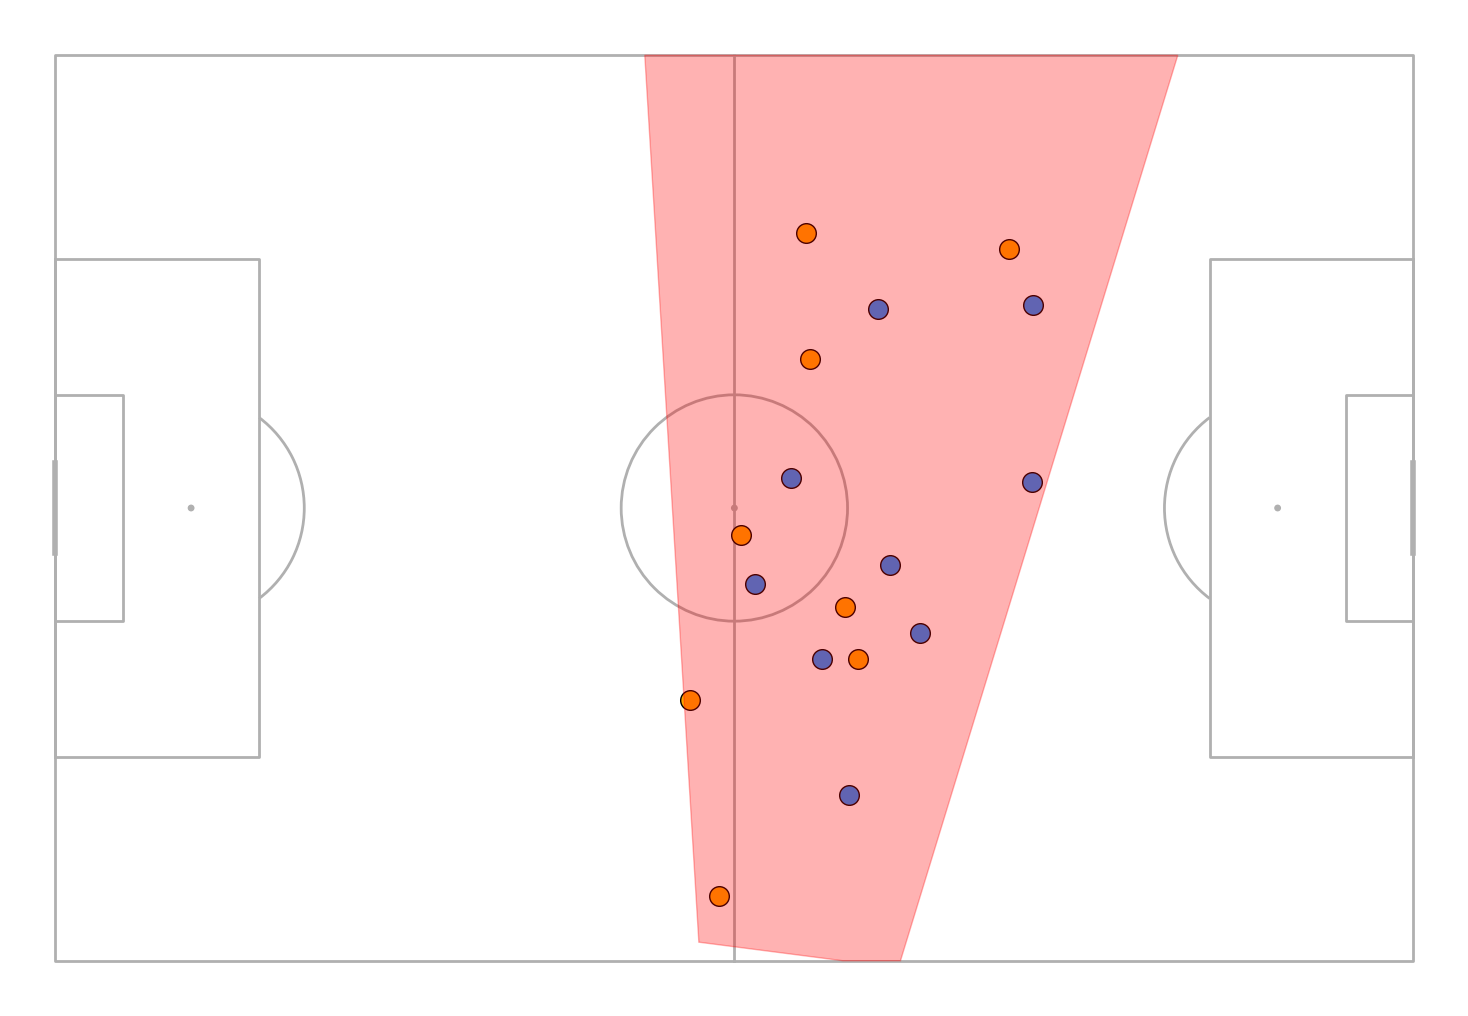

In [55]:
## get plotting data
frame_idx = 2056

visible_area_xs = data[frame_idx]["visible_area"][::2]
visible_area_ys = data[frame_idx]["visible_area"][1::2]

player_position_data = data[frame_idx]["freeze_frame"]
teammate_locs = [ppd["location"] for ppd in player_position_data if ppd["teammate"]]
opponent_locs = [ppd["location"] for ppd in player_position_data if not ppd["teammate"]]


## set up pitch
p = Pitch(pitch_type='statsbomb')
fig, ax = p.draw(figsize=(16.5, 10.5))

## plot
ax.fill(visible_area_xs, visible_area_ys, color=(1,0,0,0.3)) ##coloring the camera visible area
[ax.scatter(x, y, color='orange', s=200, ec='k') for (x,y) in teammate_locs] ## teammate locations scatter
[ax.scatter(x, y, color='dodgerblue', s=200, ec='k') for (x,y) in opponent_locs] ##opponents locations scatter

plt.show() ##to see the plot. You don't need this if you're using a jupyter notebook

<a id='section4.04'></a>

### <a id='#section4.04'>4.04. Cumulative xG Race Charts</a>
A good way of measuring the quality of chances each team creates over the course of a game is using an <b>xG Race Chart</b>, i.e. an accumlative sum of xG plotted as a line chart over time.

In [57]:
## Define function for plotting a DataFrame of shots
def create_xg_race_chart(df, home_team, away_team, home_colour, away_colour, mins_limit, subtitle):
    
    """
    Function to create an xG race chart.
    """
    
    ## Data Engineering
    
    ### Sort DataFrame 
    df = df.sort_values(['match_id', 'index'], ascending=[True, True])

    
    ### Filter DataFrame

    #### Cut off data before penalties
    df = df[df['minute'] < mins_limit]

    #### Filter all Events for Shots and Goals
    df = df[(df['home_team_name'] == home_team) & (df['away_team_name'] == away_team)].reset_index(drop=True)
    df_shots = df[(df['type_name'] == 'Shot')].reset_index(drop=True)
    df_goals = df[(df['type_name'] == 'Shot') & (df['shot_outcome_name'] == 'Goal')].reset_index(drop=True)


    ### Create four lists to plot the different xG values - home, away, xG, and minutes. We start these with zero so our charts will start at 0
    h_xG = [0]
    a_xG = [0]
    h_min = [0]
    a_min = [0]
    h_min_goals = []
    a_min_goals = []

    ### Define team names from the DataFrame
    hteam = home_team
    ateam = away_team


    ### For loop to append the xG and minute for both the Home and Away teams
    for i in range(len(df_shots['shot_statsbomb_xg'])):
        if df_shots['team_name'][i]==hteam:
            h_xG.append(df_shots['shot_statsbomb_xg'][i])
            h_min.append(df_shots['minute'][i])
            if df_shots['shot_outcome_name'][i]=='Goal':
                h_min_goals.append(df_shots['minute'][i])
        if df_shots['team_name'][i]==ateam:
            a_xG.append(df_shots['shot_statsbomb_xg'][i])
            a_min.append(df_shots['minute'][i])
            if df_shots['shot_outcome_name'][i]=='Goal':
                a_min_goals.append(df_shots['minute'][i])


    ### Function cumulative add xG values xG. Goes through the list and adds the xG values together
    def nums_cumulative_sum(nums_list):
        return [sum(nums_list[:i+1]) for i in range(len(nums_list))]


    ### Apply defned nums_cumulative_sum function to the home and away xG lists
    h_cumulative = nums_cumulative_sum(h_xG)
    a_cumulative = nums_cumulative_sum(a_xG)


    ### Find the total xG. Create a new variable from the last item in the cumulative list
    #alast = round(a_cumulative[-1],2)
    #hlast = round(h_cumulative[-1],2)
    hlast = h_cumulative[-1]
    alast = a_cumulative[-1]


    ### Determine the final cumulative xG (used for the title)
    h_final_xg = round(float(hlast), 2)
    a_final_xg = round(float(alast), 2)

    ### Determine the last minute
    last_min = max(df['minute'])


    ### Append last minute to list
    h_min.append(last_min)
    a_min.append(last_min)


    ### Append last (final) xG to 
    h_cumulative.append(hlast)
    a_cumulative.append(alast)


    ### Determine the maximum xG (used to determine the height of the y-axis)
    xg_max = max(alast, hlast)


    ### Create lists of the time and cumulative xG at the time Away goals were scored

    #### Empty list for the indexes of Away goals
    a_goals_indexes = []

    #### Create list of the indexes for Away goals
    for i in range(len(a_min)):
        if a_min[i] in a_min_goals:
            a_goals_indexes.append(i)

    #### Empty list for the cumulative xG at the moment Away goals are scored
    a_cumulative_goals = []

    #### Create list of the cumulative xG at the moment Away goals are scored
    for i in a_goals_indexes:
        a_cumulative_goals.append(a_cumulative[i])


    ### Create lists of the time and cumulative xG at the time Home goals were scored

    #### Empty list for the indexes of Home goals
    h_goals_indexes = []

    #### Create list of the indexes for Home goals
    for i in range(len(h_min)):
        if h_min[i] in h_min_goals:
            h_goals_indexes.append(i)

    #### Empty list for the cumulative xG at the moment Home goals are scored
    h_cumulative_goals = []

    #### Create list of the cumulative xG at the moment Home goals are scored
    for i in h_goals_indexes:
        h_cumulative_goals.append(h_cumulative[i])



    ## Data Visualisation

    ### Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background = '#F7F7F7'
    title_colour = 'black'
    text_colour = 'black'
    filler = 'grey'
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams.update({'font.size':15})


    ### Create figure 
    fig, ax = plt.subplots(figsize=(15, 7))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)


    ### Add a grid and set gridlines
    ax.grid(linestyle='dotted',
            linewidth=0.25,
            color='#3B3B3B',
            axis='y',
            zorder=1
           )

    ### Remove top and right spines, colour bttom and left
    spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        if s in ['top', 'right']:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)


    ### Plot xG Race Chart - step chart
    ax.step(x=h_min, y=h_cumulative, color=home_colour, label=hteam, linewidth=5, where='post')
    ax.step(x=a_min, y=a_cumulative, color=away_colour, label=ateam, linewidth=5, where='post')


    ### Plot goals - scatter plot
    ax.scatter(x=h_min_goals, y=h_cumulative_goals, s=1200, color=home_colour, edgecolors=background, marker='*', alpha=1, linewidth=0.5, zorder=2)
    ax.scatter(x=a_min_goals, y=a_cumulative_goals, s=1200, color=away_colour, edgecolors=background, marker='*', alpha=1, linewidth=0.5, zorder=2)


    ### Show Legend
    #plt.legend()     # commented out as colours of teams shown in the title


    ### Add Plot Title
    s = 'xG Race Chart for <{}> ({}) vs. <{}> ({})\n'
    htext.fig_htext(s.format(home_team, h_final_xg, away_team, a_final_xg), 0.04, 1.03, highlight_colors=[home_colour, away_colour], highlight_weights=['bold'], string_weight='bold', fontsize=25, fontfamily=title_font, color=text_colour)


    ### Add Plot Subtitle
    fig.text(0.04, 1.029, f'EURO 2020 {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)


    ### Add X and Y labels
    plt.xlabel('Minute', color=text_colour, fontsize=16)
    plt.ylabel('xG', color=text_colour, fontsize=16)
    plt.xticks([0, 15, 30, 45, 60, 75, 90])
    plt.xlim([0, last_min+2])
    plt.ylim([0, xg_max*1.1])    # Y axis goes to 10% greater than maximum xG


    ### Remove pips
    ax.tick_params(axis='both', length=0)


    ### Add UEFA EURO 2020 logo
    ax2 = fig.add_axes([0.89, 1.03, 0.12, 0.12])
    ax2.axis('off')
    img = image.imread('../img/competitions/uefa_euro_2020.png')
    ax2.imshow(img)


    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.74, -0.090, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)


    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.905, -0.045, 0.07, 0.07])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)


    ### Footnote
    plt.figtext(0.04,
                -0.07,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )


    ### Save figure
    if not os.path.exists(fig_dir + f'/xg_race_map_{home_team}_{away_team}.png'):
        plt.savefig(fig_dir + f'/xg_race_map_{home_team}_{away_team}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show figure
    plt.tight_layout()
    plt.show()

findfont: Font family ['Alegreya Sans'] not found. Falling back to DejaVu Sans.


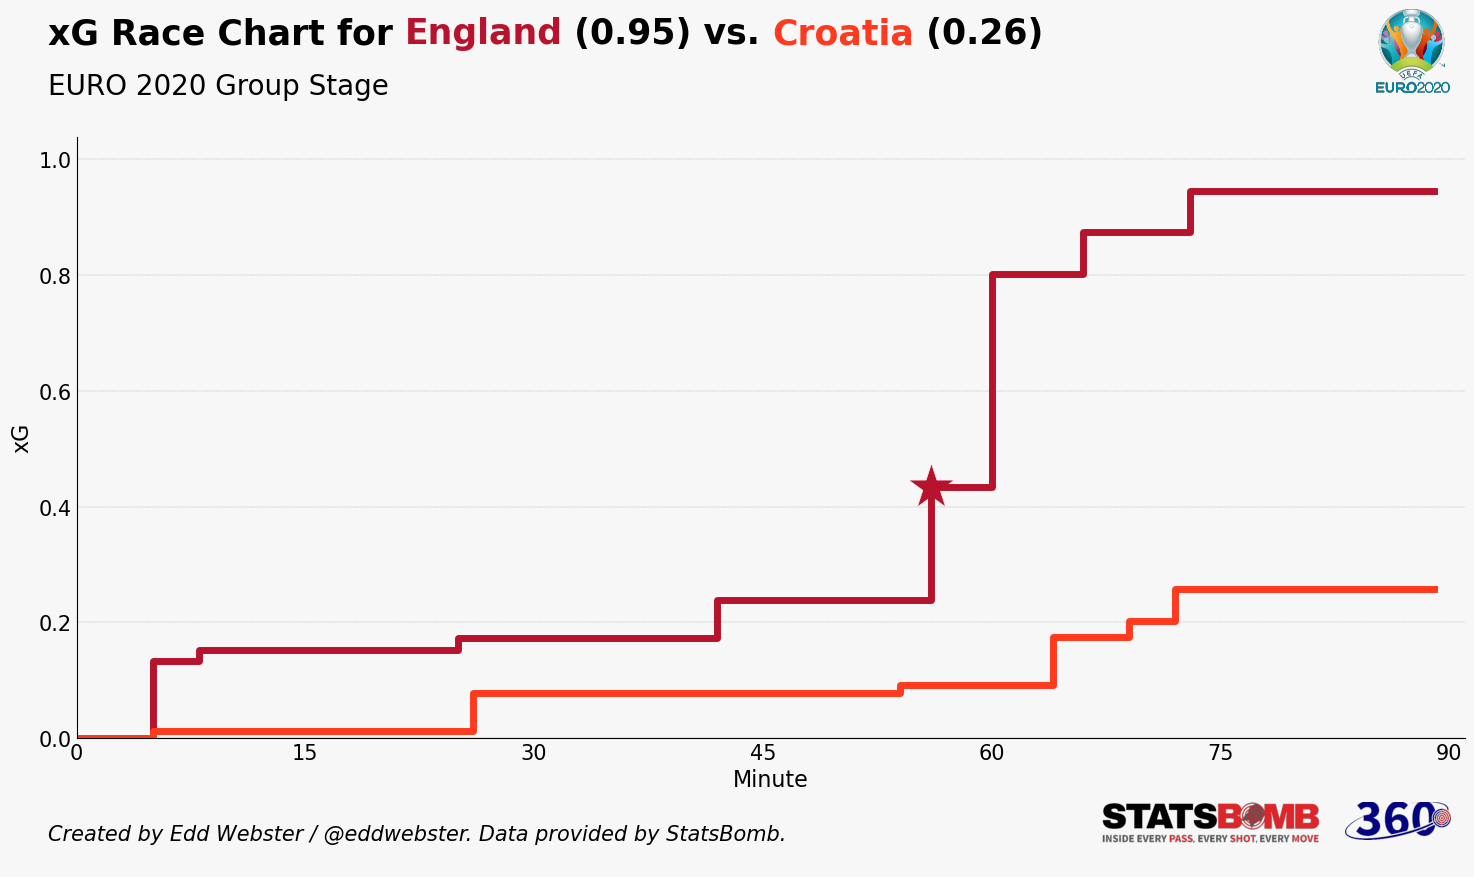

In [58]:
create_xg_race_chart(df=df_events,
                     home_team='England',
                     away_team='Croatia',
                     home_colour='#b8132d',
                     away_colour='#ff3a1e',
                     mins_limit=90,
                     subtitle='Group Stage'
                    )

<a id='section4.05'></a>

### <a id='#section4.05'>4.05. OBV Bar Charts</a>

<a id='section4.05.1'></a>

#### <a id='#section4.05.1'>4.05.1. OBV Bar Chart per Team</a>

In [68]:
## Define function to create a bar chart for the total OBV of teams
def create_obv_teams_bar_chart(df, count_teams, bar_colour, games_limit, selected_team_1, selected_team_1_colour, selected_team_2, selected_team_2_colour):
    
    """
    Function to create a bar chart for the total OBV of teams.
    """
    
    ## Data Engineering
    
    ### Groupby and aggregate
    df_grouped_obv = (df
                          .groupby(['team_name'])
                          .agg({'match_id': pd.Series.nunique,
                                'obv_total_net': 'sum'})
                          .reset_index()
                     )

    ### Rename columns after groupby and aggregation
    df_grouped_obv.columns = ['team_name', 'games', 'total_obv']

    ### Calculate OBV per 90
    df_grouped_obv['obv_per_game'] = df_grouped_obv['total_obv'] / (df_grouped_obv['games'] / 90)

    ### Create a filter for a minimum number of minutes played
    df_grouped_obv = df_grouped_obv[df_grouped_obv['games'] >= games_limit]

    ### Sort by 'total_obv' decending
    df_grouped_obv = df_grouped_obv.sort_values(['obv_per_game'], ascending=[False])

    ### Reset index
    df_grouped_obv = df_grouped_obv.reset_index(drop=True)

    ### Filter DataFrame for top N team
    df_grouped_obv = df_grouped_obv.head(count_teams)

    

    ## Data Visualisation

    ## Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#f7f7f7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    ### Define labels and metrics
    team = df_grouped_obv['team_name']
    value = df_grouped_obv['obv_per_game']

    ### Create figure 
    fig, ax = plt.subplots(figsize =(16, 16))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)

    ### Create Horizontal Bar Plot
    bars = ax.barh(team,
                   value,
                   color=bar_colour,
                   alpha=0.75
                  )

    ### Select team of interest
    bars[selected_team_1].set_color(selected_team_1_colour)
    
    ### Select team of interest
    bars[selected_team_2].set_color(selected_team_2_colour)
    
    ### Add a grid and set gridlines
    ax.grid(linestyle='dotted',
            linewidth=0.25,
            color='#3B3B3B',
            axis='y',
            zorder=1
           )
    
    ### Remove top and right spines, colour bttom and left
    spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        if s in ['top', 'right', 'bottom', 'left']:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)

    ### Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ### Add padding between axes and labels
    #ax.xaxis.set_tick_params(pad=2)
    #ax.yaxis.set_tick_params(pad=20)

    ### Add X, Y gridlines
    ax.grid(b=True,
            color='grey',
            linestyle='-.',
            linewidth=0.5,
            alpha=0.2
           )

    ### Show top values
    ax.invert_yaxis()

    ### Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.015, i.get_y()+0.4,
                 str(round((i.get_width()), 3)),
                 fontsize=18,
                 fontweight='regular',
                 color ='black'
                )
    
    ### Add Plot Title
    plt.figtext(0.045,
                0.99,
                f'Each Team\'s On-Ball Value Contribution ',
                fontsize=30,
                fontweight='bold', 
                color=text_colour
               )

    ### Add Plot Subtitle
    fig.text(0.045, 0.96, f'EURO 2020', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)
    
    ### Add UEFA EURO 2020 logo
    #ax2 = fig.add_axes([0.985, 1.03, 0.12, 0.12])
    #ax2.axis('off')
    #img = image.imread('../img/competitions/uefa_euro_2020.png')
    #ax2.imshow(img)

    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.74, 0.005, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)

    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.905, 0.047, 0.07, 0.07])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)
    
    ### Footnote
    plt.figtext(0.045,
                -0.04,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )

    ### Save figure
    if not os.path.exists(fig_dir + f'/total_obv_bar_chart.png'):
        plt.savefig(fig_dir + f'/total_obv_bar_chart.png', bbox_inches='tight', dpi=300)
    else:
        pass

    ## Show plt
    plt.tight_layout()
    plt.show()

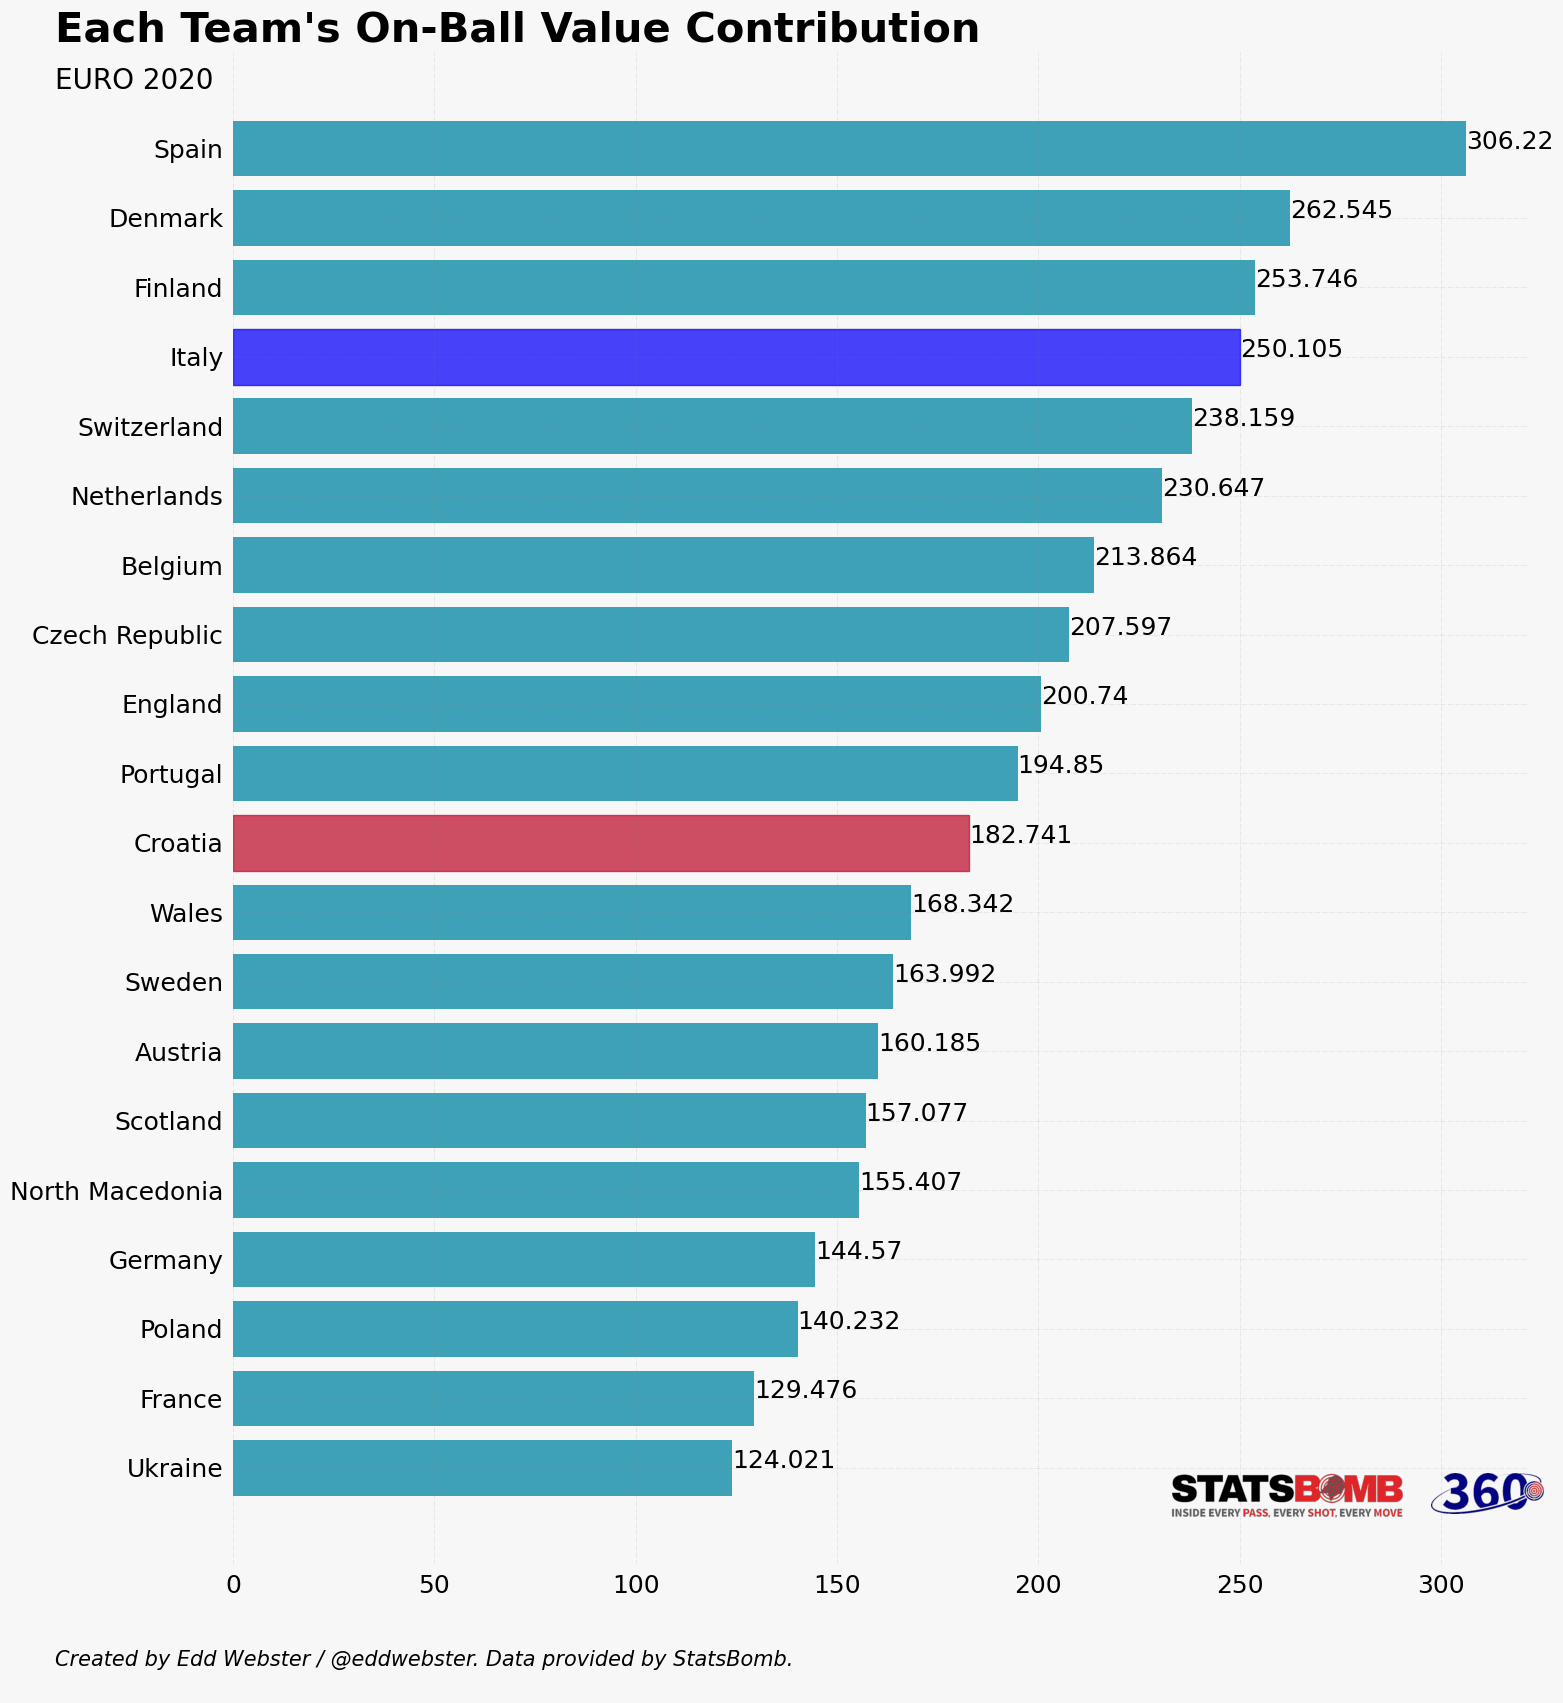

In [69]:
create_obv_teams_bar_chart(df=df_events,
                           count_teams=20,
                           bar_colour='#0184a3',
                           games_limit=0,
                           selected_team_1=3,
                           selected_team_1_colour='#0c05fa',
                           selected_team_2=10,
                           selected_team_2_colour='#c01430'
                          )

<a id='section4.05.2'></a>

#### <a id='#section4.05.2'>4.05.2. OBV Bar Chart per Player</a>

In [70]:
## Define function to create a bar chart for the total OBV of players
def create_obv_players_bar_chart(df,
                                 lst_actions,
                                 count_players,
                                 bar_colour,
                                 mins_limit,
                                 selected_player_1,
                                 selected_player_1_colour,
                                 selected_player_2,
                                 selected_player_2_colour
                                ):
    
    """
    Function to create a bar chart for the total OBV of players.
    """
    
    ## Data Engineering
    
    ### 
    df = df[df['type_name'].isin(lst_actions)]
    
    ### Groupby and aggregate
    df_grouped_obv = (df
                          .groupby(['player_name', 'team_name', 'mins_total'])
                          .agg({'obv_total_net':'sum'})
                          .reset_index()
                     )

    ### Rename columns after groupby and aggregation
    df_grouped_obv.columns = ['player_name', 'country', 'mins_total', 'total_obv']

    ### Calculate OBV per 90
    df_grouped_obv['obv_p90'] = df_grouped_obv['total_obv'] / (df_grouped_obv['mins_total'] / 90)

    ### Remove players that played no minutes
    df_grouped_obv = df_grouped_obv[df_grouped_obv['mins_total'] != 0]

    ### Create a filter for a minimum number of minutes played
    df_grouped_obv = df_grouped_obv[df_grouped_obv['mins_total'] >= mins_limit]

    ### Sort by 'total_obv' decending
    df_grouped_obv = df_grouped_obv.sort_values(['obv_p90'], ascending=[False])

    ### Reset index
    df_grouped_obv = df_grouped_obv.reset_index(drop=True)

    ### Filter DataFrame for top N players
    df_grouped_obv = df_grouped_obv.head(count_players)

    

    ## Data Visualisation

    ## Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#f7f7f7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    ### Define labels and metrics
    player = df_grouped_obv['player_name']
    value = df_grouped_obv['obv_p90']

    ### Create figure 
    fig, ax = plt.subplots(figsize =(16, 16))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)

    ### Create Horizontal Bar Plot
    bars = ax.barh(player,
                   value,
                   color=bar_colour,
                   alpha=0.75
                  )

    ### Select team of interest
    bars[selected_player_1].set_color(selected_player_1_colour)
    
    ### Select team of interest
    bars[selected_player_2].set_color(selected_player_2_colour)
    
    ### Add a grid and set gridlines
    ax.grid(linestyle='dotted',
            linewidth=0.25,
            color='#3B3B3B',
            axis='y',
            zorder=1
           )
    
    ### Remove top and right spines, colour bttom and left
    spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        if s in ['top', 'right', 'bottom', 'left']:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)

    ### Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ### Add padding between axes and labels
    #ax.xaxis.set_tick_params(pad=2)
    #ax.yaxis.set_tick_params(pad=20)

    ### Add X, Y gridlines
    ax.grid(b=True,
            color='grey',
            linestyle='-.',
            linewidth=0.5,
            alpha=0.2
           )

    ### Show top values
    ax.invert_yaxis()

    ### Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.015, i.get_y()+0.4,
                 str(round((i.get_width()), 3)),
                 fontsize=18,
                 fontweight='regular',
                 color ='black'
                )
    
    ### Add Plot Title
    plt.figtext(0.045,
                0.99,
                f'Top {count_players} Player\'s for On-Ball Value Contribution',
                fontsize=30,
                fontweight='bold', 
                color=text_colour
               )

    ### Add Plot Subtitle
    fig.text(0.045, 0.96, f'EURO 2020', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)
    
    ### Add UEFA EURO 2020 logo
    #ax2 = fig.add_axes([0.985, 1.03, 0.12, 0.12])
    #ax2.axis('off')
    #img = image.imread('../img/competitions/uefa_euro_2020.png')
    #ax2.imshow(img)

    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.74, 0.005, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)

    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.905, 0.047, 0.07, 0.07])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)
    
    ### Footnote
    plt.figtext(0.045,
                -0.04,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb. OBV calculated for {lst_actions} events.\nEach player has played a minimum of {mins_limit} minutes and their OBV values are standardised per 90 minutes.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )

    ### Save figure
    if not os.path.exists(fig_dir + f'/total_obv_bar_chart.png'):
        plt.savefig(fig_dir + f'/total_obv_bar_chart.png', bbox_inches='tight', dpi=300)
    else:
        pass

    ## Show plt
    plt.tight_layout()
    plt.show()

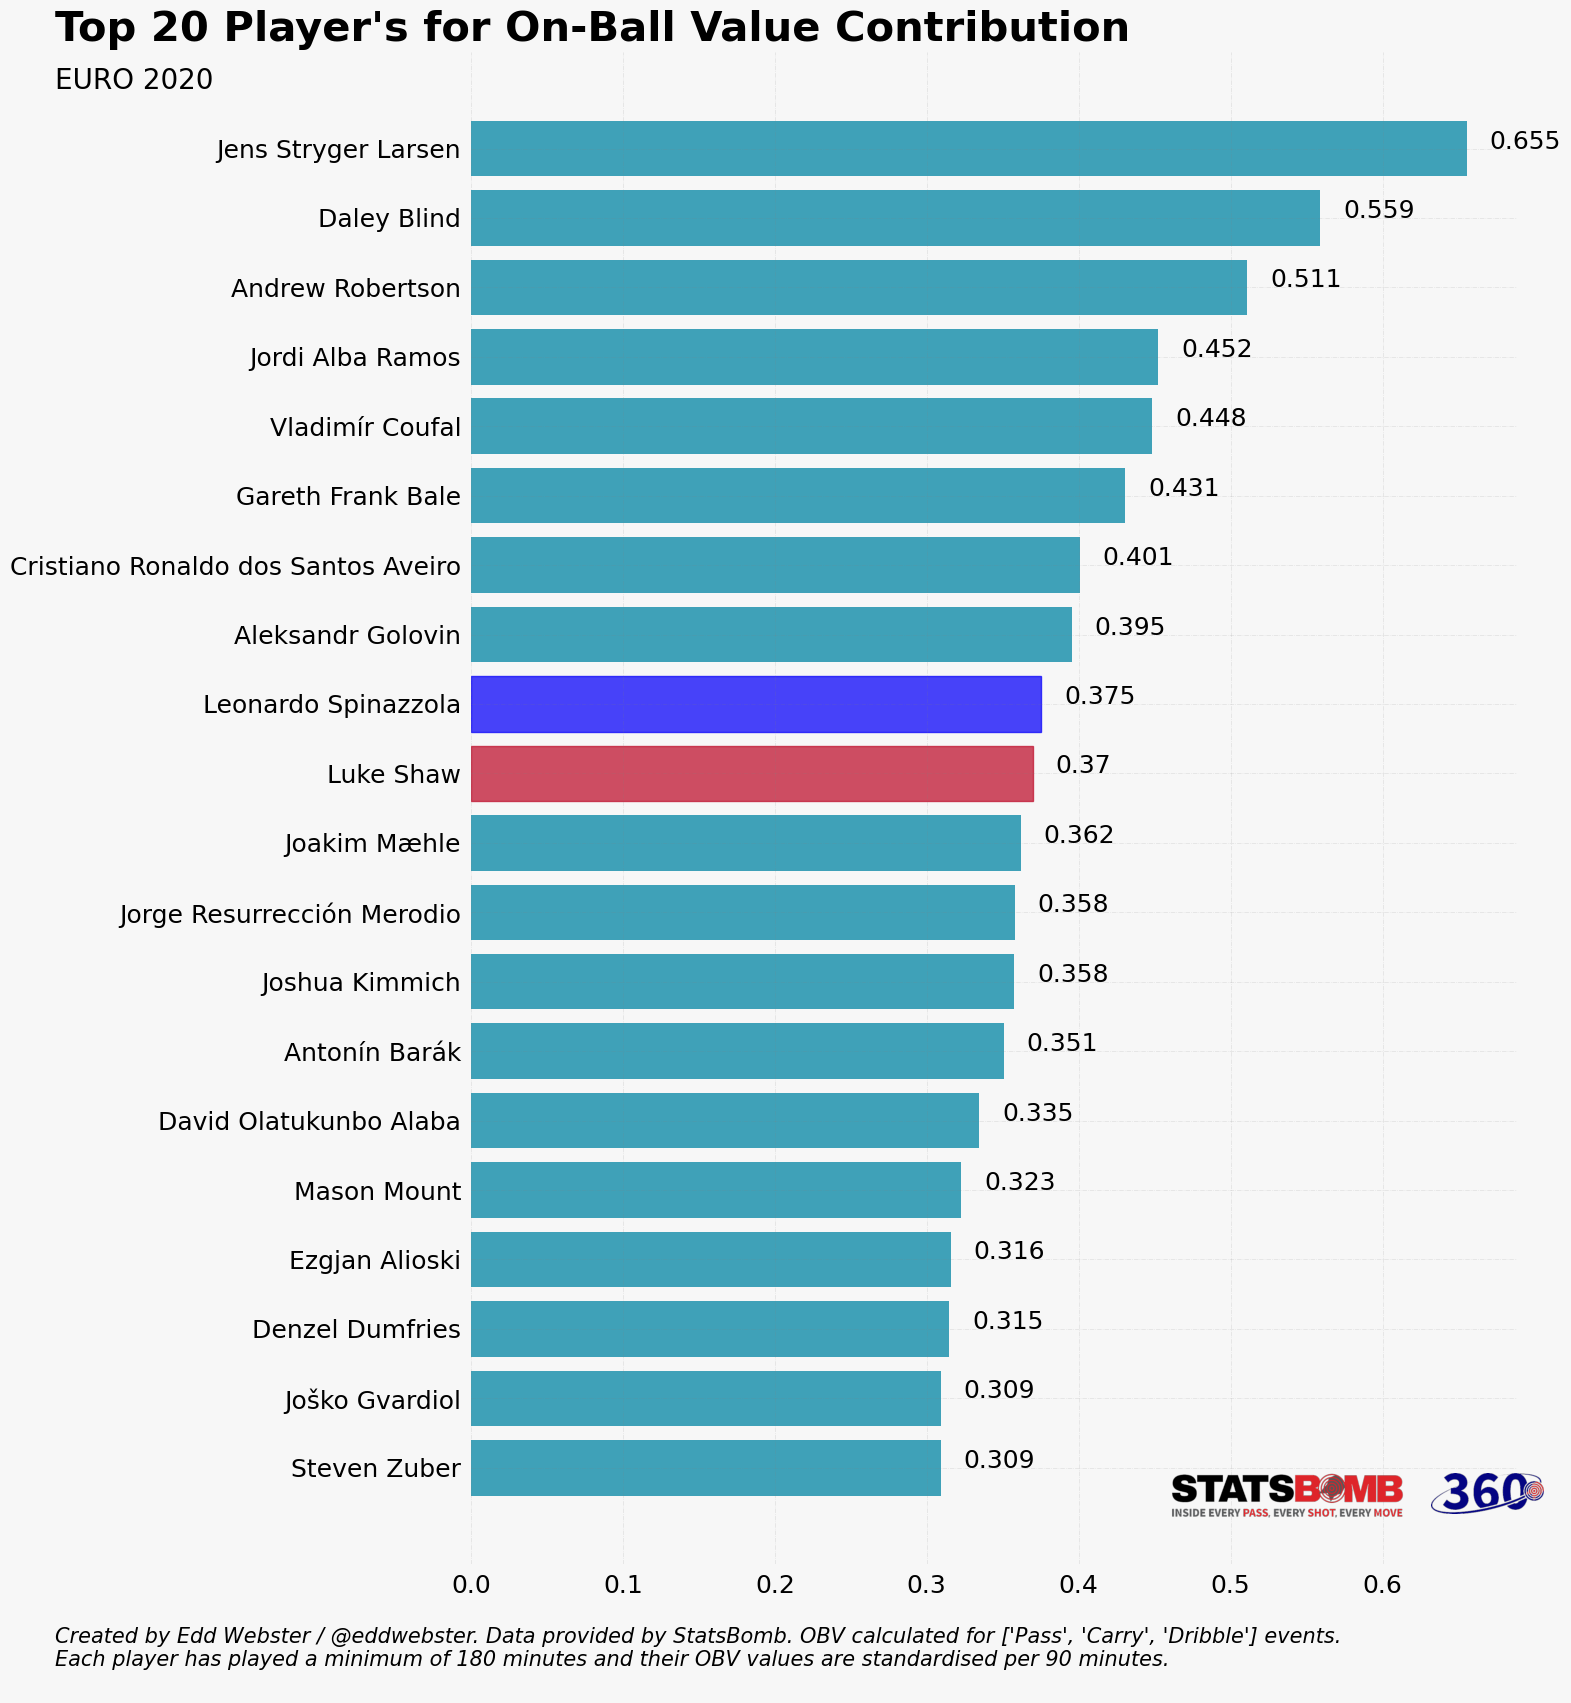

In [71]:
create_obv_players_bar_chart(df=df_events,
                             lst_actions=[
                                          'Pass',
                                          'Carry',
                                         #'Duel',
                                         #'Dispossessed',
                                          'Dribble',
                                         #'Ball Recovery',
                                         #'Interception',
                                         #'Shot',
                                         #'Goal Keeper',
                                         #'Block',
                                         #'Clearance',
                                         #'Miscontrol',
                                         #'Foul Won',
                                         #'50/50'
                                         ],
                             count_players=20,
                             bar_colour='#0184a3',
                             mins_limit=180,
                             selected_player_1=8,
                             selected_player_1_colour='#0c05fa',
                             selected_player_2=9,
                             selected_player_2_colour='#c01430'
                            )

<a id='section4.06'></a>

### <a id='#section4.06'>4.06. xG</a>

<a id='section4.06.1'></a>

#### <a id='#section4.06.1'>4.06.1. Bar Charts</a>

<a id='section4.06.1.1'></a>

##### <a id='#section4.06.1.1'>4.06.1.1. xG Difference</a>

In [72]:
# Define function xG difference bar charts
def create_xg_diff_bar_chart(df,
                             bar_colour,
                             date_start,
                             date_end,
                             value,
                             selected_team_1,
                             selected_team_1_colour,
                             selected_team_2,
                             selected_team_2_colour,
                             subtitle
                            ):
    
    """
    Function to create a bar chart for the xG difference of each team per match.
    """
    
    ## Data Engineering

    ### Create an 'isGoal attribute'
    df['isGoal'] = np.where(((df['type_name'] == 'Shot') & (df['shot_outcome_name'] == 'Goal')), 1, 0)
    df['team'] = np.where(df['team_name'] == df['home_team_name'], df['home_team_name'], df['away_team_name'])
    df['opponent'] = np.where(df['team_name'] == df['away_team_name'], df['home_team_name'], df['away_team_name'])
    df['team_xg'] = np.where((df['team_name'] == df['team']), df['shot_statsbomb_xg'], 0)
    df['opponent_xg'] = np.where((df['team_name'] == df['opponent']), df['shot_statsbomb_xg'], 0)

    ### Filter out all goals scored from penalties
    df = df[df['minute'] < 120]
    df = df[df['shot_type_name'] != 'Penalty']

    ### Filter between two dates
    df['match_date'] = pd.to_datetime(df['match_date'])
    mask = (df['match_date'] > date_start) & (df['match_date'] <= date_end)
    df = df.loc[mask]
    
    ### Groupby and aggregate
    df_fixture_xg_1 = (df
                         .groupby(['team', 'opponent'])
                         .agg({'shot_statsbomb_xg':['sum'],
                               'isGoal':['sum'],
                               'minute':['max']
                              }
                             )
                         .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_fixture_xg_1.columns = ['team', 'opponent', 'team_xg', 'team_goals', 'minutes']

    ### Groupby and aggregate
    df_fixture_xg_2 = (df
                         .groupby(['opponent', 'team'])
                         .agg({'shot_statsbomb_xg':['sum'],
                               'isGoal':['sum'],
                               'minute':['max']
                              }
                             )
                         .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_fixture_xg_2.columns = ['opponent_2', 'team_2', 'opponent_xg', 'opponent_goals', 'minutes_2']

    ### Rearrange columns
    df_fixture_xg_2 = df_fixture_xg_2[['team_2', 'opponent_2', 'opponent_xg', 'opponent_goals', 'minutes_2']].drop_duplicates()

    ### Join the two xG DataFrames
    df_fixture_xg = df_fixture_xg_1.merge(df_fixture_xg_2, left_on=['team', 'opponent'], right_on=['opponent_2', 'team_2'], how='left')

    ### Groupby and aggregate
    df_team_grouped = (df_fixture_xg
                           .groupby(['team'])
                           .agg({'opponent':['count'],
                                 'minutes':['sum'],
                                 'team_xg':['sum'],
                                 'opponent_xg':['sum'],
                                 'team_goals':['sum'],
                                 'opponent_goals':['sum']
                                }
                               )
                           .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_team_grouped.columns = ['team', 'games_played', 'minutes_played', 'xg', 'xga', 'goals_scored', 'goals_conceded']

    ### Determine bespoke metrics
    df_team_grouped['xg_p90'] = df_team_grouped['xg'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xg_per_game'] = df_team_grouped['xg'] / df_team_grouped['games_played']
    df_team_grouped['xga_p90'] = df_team_grouped['xga'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xga_per_game'] = df_team_grouped['xga'] / df_team_grouped['games_played']
    df_team_grouped['goals_p90'] = df_team_grouped['goals_scored'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['goals_per_game'] = df_team_grouped['goals_scored'] / df_team_grouped['games_played']
    df_team_grouped['goals_conceded_p90'] = df_team_grouped['goals_conceded'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['goals_conceded_per_game'] = df_team_grouped['goals_conceded'] / df_team_grouped['games_played']
    df_team_grouped['goal_difference'] = df_team_grouped['goals_scored'] - df_team_grouped['goals_conceded']
    df_team_grouped['xg_diff'] = df_team_grouped['xg'] - df_team_grouped['xga']
    df_team_grouped['xg_diff_p90'] = df_team_grouped['xg_diff'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xg_diff_per_game'] = df_team_grouped['xg_diff'] / df_team_grouped['games_played']

    ### Round the metrics to 2 or 3 decimal places
    df_team_grouped['xg'] = df_team_grouped['xg'].round(2)
    df_team_grouped['xga'] = df_team_grouped['xga'].round(2)
    df_team_grouped['xg_p90'] = df_team_grouped['xg_p90'].round(2)
    df_team_grouped['xg_per_game'] = df_team_grouped['xg_per_game'].round(2)
    df_team_grouped['xga_p90'] = df_team_grouped['xga_p90'].round(2)
    df_team_grouped['xga_per_game'] = df_team_grouped['xga_per_game'].round(2)
    df_team_grouped['goals_p90'] = df_team_grouped['goals_p90'].round(2)
    df_team_grouped['goals_per_game'] = df_team_grouped['goals_per_game'].round(2)
    df_team_grouped['goals_conceded_p90'] = df_team_grouped['goals_conceded_p90'].round(2)
    df_team_grouped['goals_conceded_per_game'] = df_team_grouped['goals_conceded_per_game'].round(2)
    df_team_grouped['xg_diff'] = df_team_grouped['xg_diff'].round(2)
    df_team_grouped['xg_diff_p90'] = df_team_grouped['xg_diff_p90'].round(3)
    df_team_grouped['xg_diff_per_game'] = df_team_grouped['xg_diff_per_game'].round(3)

    ### Sort by 'xg_per_game_diff' decending
    df_team_grouped = df_team_grouped.sort_values([value], ascending=[False])

    ### Reset index
    df_team_grouped = df_team_grouped.reset_index(drop=True)
    
    

    ## Data Visualisation

    ## Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#f7f7f7'    #'#313233'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    ### Define labels and metrics
    player = df_team_grouped['team']
    value = df_team_grouped[value]

    ### Create figure 
    fig, ax = plt.subplots(figsize =(16, 16))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    
    ### Create Horizontal Bar Plot
    bars = ax.barh(player,
                   value,
                   color=bar_colour,
                   alpha=0.75
                  )
    
    ### Select team of interest
    bars[selected_team_1].set_color(selected_team_1_colour)

    ### Select team of interest
    bars[selected_team_2].set_color(selected_team_2_colour)
    
    ### Add a grid and set gridlines
    ax.grid(linestyle='dotted',
            linewidth=0.25,
            color='#3B3B3B',
            axis='y',
            zorder=1
           )
    
    ### Remove top and right spines, colour bttom and left
    spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        if s in ['top', 'right', 'bottom', 'left']:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)

    ### Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ### Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=2)
    ax.yaxis.set_tick_params(pad=20)

    ### Add X, Y gridlines
    ax.grid(b=True,
            color='grey',
            linestyle='-.',
            linewidth=0.5,
            alpha=0.2
           )

    ### Show top values
    ax.invert_yaxis()

    ### Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.015, i.get_y()+0.4,
                 str(round((i.get_width()), 3)),
                 fontsize=18,
                 fontweight='regular',
                 color ='black'
                )
        
    ### Add Plot Title
    plt.figtext(0.045,
                0.99,
                f'Each Country\'s xG Difference',
                fontsize=30,
                fontweight='bold', 
                color=text_colour
               )

    ### Add Plot Subtitle
    fig.text(0.045, 0.96, f'EURO 2020 - {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)

    ### Add UEFA EURO 2020 logo
    #ax2 = fig.add_axes([0.985, 1.03, 0.12, 0.12])
    #ax2.axis('off')
    #img = image.imread('../img/competitions/uefa_euro_2020.png')
    #ax2.imshow(img)

    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.74, 0.005, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)

    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.905, 0.047, 0.07, 0.07])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)
    
    ### Footnote
    plt.figtext(0.045,
                -0.02,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb. A team\'s xG difference is their xG minus xG against. Penalties excluded.\nxG difference is standardised per 90 minutes.',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )
    
    ### Save figure
    if not os.path.exists(fig_dir + f'/xg_diff_bar_chart_teams.png'):
        plt.savefig(fig_dir + f'/xg_diff_bar_chart_teams.png', bbox_inches='tight', dpi=300)
    else:
        pass

    ## Show plt
    plt.tight_layout()
    plt.show()

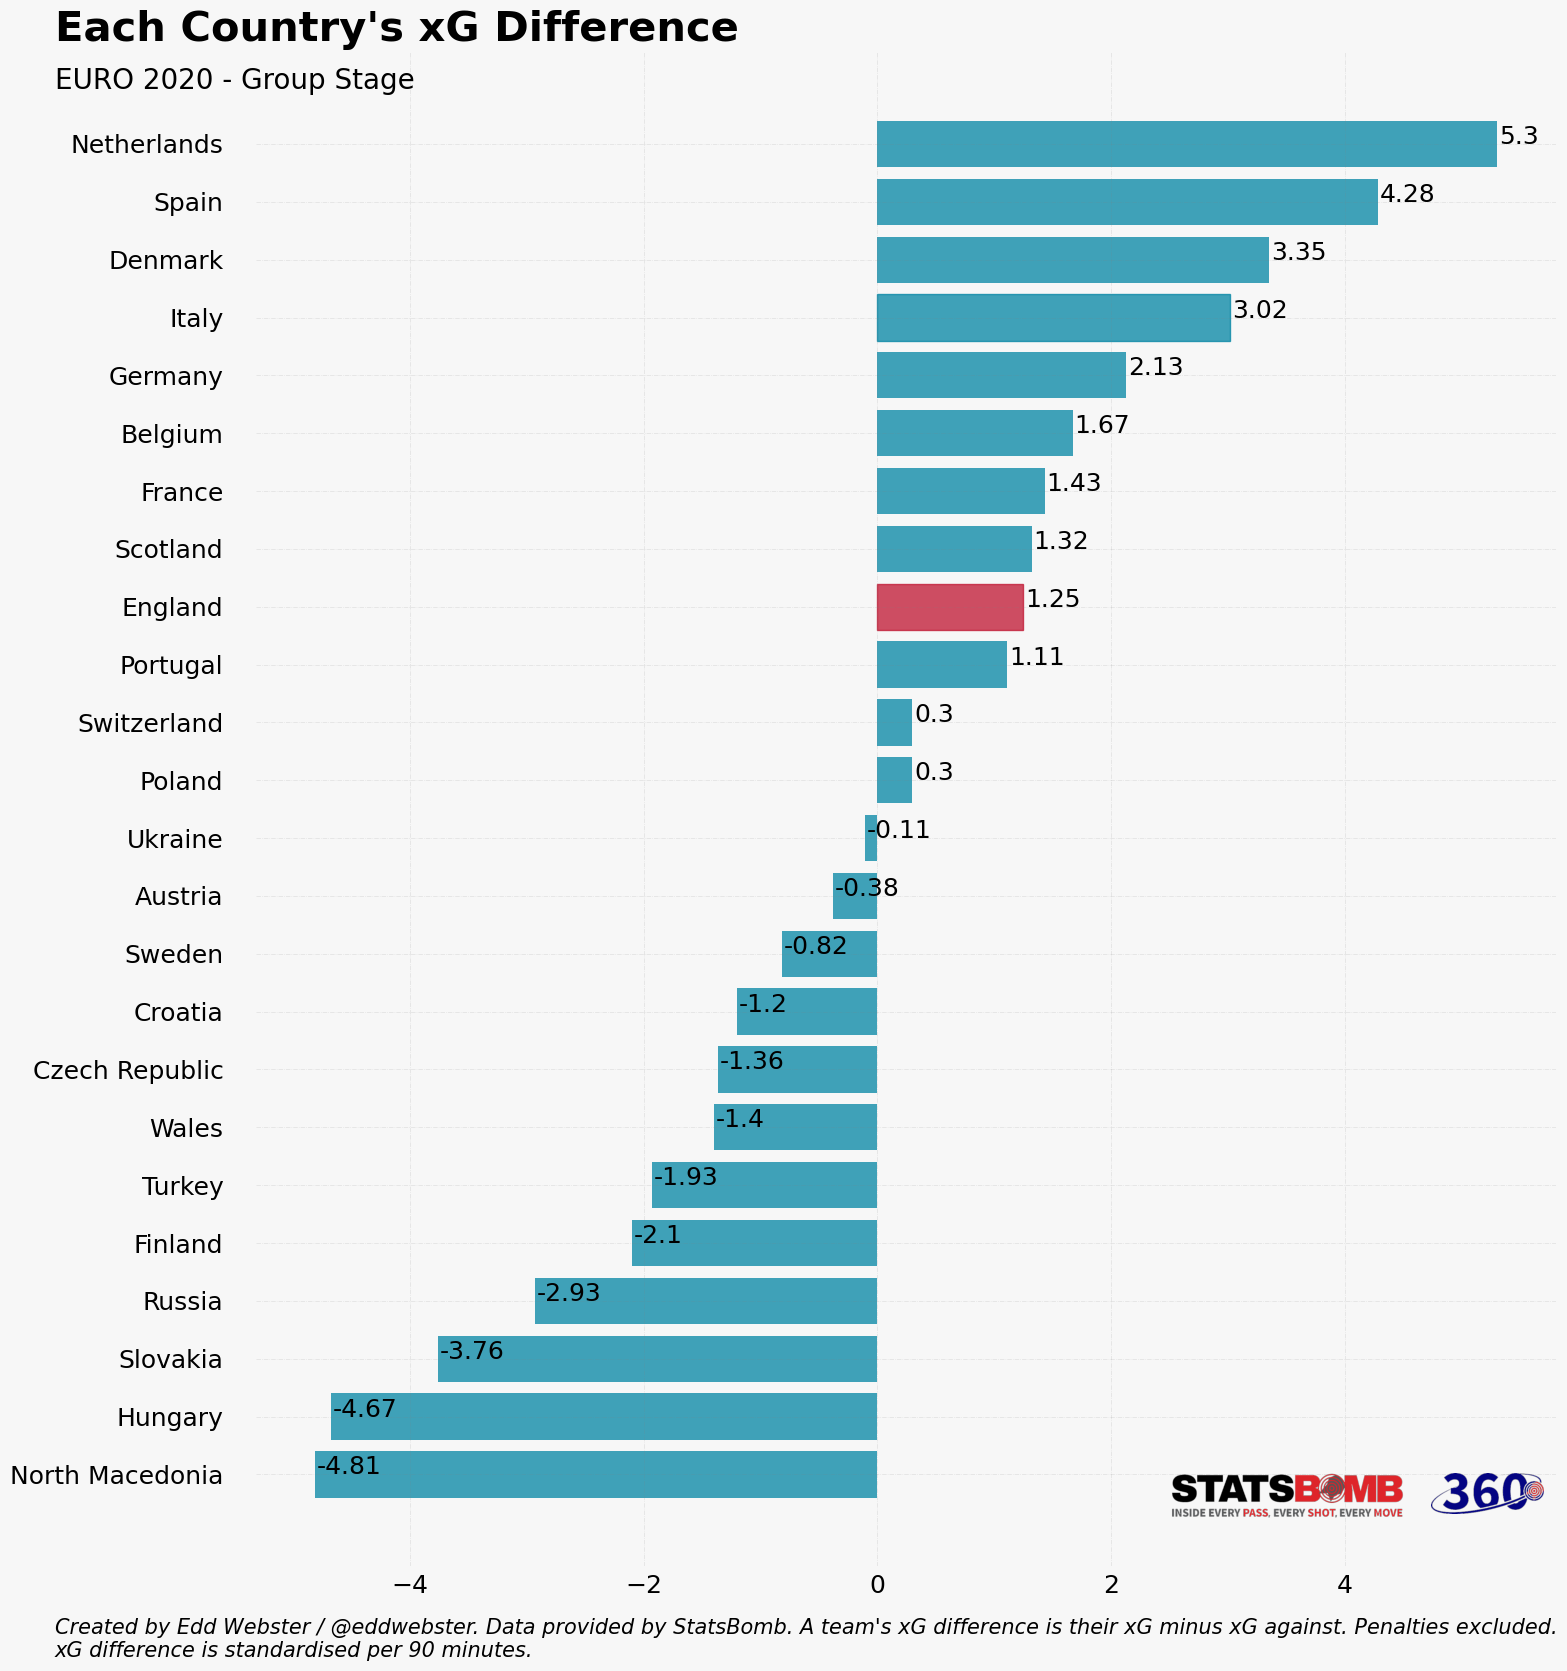

In [73]:
create_xg_diff_bar_chart(df=df_events,
                         date_start='2021-06-11',
                         date_end='2021-06-24',
                         value='xg_diff',    #'xg_diff_p90'
                         bar_colour='#0184a3',
                         selected_team_1=3,    #'Italy'    # currently selects by index
                         selected_team_1_colour='#0184a3',  #'#0c05fa' # commented out italy
                         selected_team_2=8,    #'England'
                         selected_team_2_colour='#c01430',
                         subtitle = 'Group Stage'
                        )

<a id='section4.06.1.2'></a>

##### <a id='#section4.06.1.2'>4.06.1.2. xG</a>

In [74]:
# Define function xG bar charts
def create_xg_bar_chart(df,
                         bar_colour,
                         date_start,
                         date_end,
                         value,
                         selected_team_1,
                         selected_team_1_colour,
                         selected_team_2,
                         selected_team_2_colour,
                         title,
                         subtitle
                        ):
    
    """
    Function to create a bar chart for the xG of each team per match.
    """
    
    ## Data Engineering

    ### Create an 'isGoal attribute'
    df['isGoal'] = np.where(((df['type_name'] == 'Shot') & (df['shot_outcome_name'] == 'Goal')), 1, 0)
    df['team'] = np.where(df['team_name'] == df['home_team_name'], df['home_team_name'], df['away_team_name'])
    df['opponent'] = np.where(df['team_name'] == df['away_team_name'], df['home_team_name'], df['away_team_name'])
    df['team_xg'] = np.where((df['team_name'] == df['team']), df['shot_statsbomb_xg'], 0)
    df['opponent_xg'] = np.where((df['team_name'] == df['opponent']), df['shot_statsbomb_xg'], 0)

    ### Filter out all goals scored from penalties
    df = df[df['minute'] < 120]
    df = df[df['shot_type_name'] != 'Penalty']

    ### Filter between two dates
    df['match_date'] = pd.to_datetime(df['match_date'])
    mask = (df['match_date'] > date_start) & (df['match_date'] <= date_end)
    df = df.loc[mask]
    
    ### Groupby and aggregate
    df_fixture_xg_1 = (df
                         .groupby(['team', 'opponent'])
                         .agg({'shot_statsbomb_xg':['sum'],
                               'isGoal':['sum'],
                               'minute':['max']
                              }
                             )
                         .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_fixture_xg_1.columns = ['team', 'opponent', 'team_xg', 'team_goals', 'minutes']

    ### Groupby and aggregate
    df_fixture_xg_2 = (df
                         .groupby(['opponent', 'team'])
                         .agg({'shot_statsbomb_xg':['sum'],
                               'isGoal':['sum'],
                               'minute':['max']
                              }
                             )
                         .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_fixture_xg_2.columns = ['opponent_2', 'team_2', 'opponent_xg', 'opponent_goals', 'minutes_2']

    ### Rearrange columns
    df_fixture_xg_2 = df_fixture_xg_2[['team_2', 'opponent_2', 'opponent_xg', 'opponent_goals', 'minutes_2']].drop_duplicates()

    ### Join the two xG DataFrames
    df_fixture_xg = df_fixture_xg_1.merge(df_fixture_xg_2, left_on=['team', 'opponent'], right_on=['opponent_2', 'team_2'], how='left')

    ### Groupby and aggregate
    df_team_grouped = (df_fixture_xg
                           .groupby(['team'])
                           .agg({'opponent':['count'],
                                 'minutes':['sum'],
                                 'team_xg':['sum'],
                                 'opponent_xg':['sum'],
                                 'team_goals':['sum'],
                                 'opponent_goals':['sum']
                                }
                               )
                           .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_team_grouped.columns = ['team', 'games_played', 'minutes_played', 'xg', 'xga', 'goals_scored', 'goals_conceded']

    ### Determine bespoke metrics
    df_team_grouped['xg_p90'] = df_team_grouped['xg'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xg_per_game'] = df_team_grouped['xg'] / df_team_grouped['games_played']
    df_team_grouped['xga_p90'] = df_team_grouped['xga'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xga_per_game'] = df_team_grouped['xga'] / df_team_grouped['games_played']
    df_team_grouped['goals_p90'] = df_team_grouped['goals_scored'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['goals_per_game'] = df_team_grouped['goals_scored'] / df_team_grouped['games_played']
    df_team_grouped['goals_conceded_p90'] = df_team_grouped['goals_conceded'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['goals_conceded_per_game'] = df_team_grouped['goals_conceded'] / df_team_grouped['games_played']
    df_team_grouped['goal_difference'] = df_team_grouped['goals_scored'] - df_team_grouped['goals_conceded']
    df_team_grouped['xg_diff'] = df_team_grouped['xg'] - df_team_grouped['xga']
    df_team_grouped['xg_diff_p90'] = df_team_grouped['xg_diff'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xg_diff_per_game'] = df_team_grouped['xg_diff'] / df_team_grouped['games_played']

    ### Round the metrics to 2 or 3 decimal places
    df_team_grouped['xg'] = df_team_grouped['xg'].round(2)
    df_team_grouped['xga'] = df_team_grouped['xga'].round(2)
    df_team_grouped['xg_p90'] = df_team_grouped['xg_p90'].round(2)
    df_team_grouped['xg_per_game'] = df_team_grouped['xg_per_game'].round(2)
    df_team_grouped['xga_p90'] = df_team_grouped['xga_p90'].round(2)
    df_team_grouped['xga_per_game'] = df_team_grouped['xga_per_game'].round(2)
    df_team_grouped['goals_p90'] = df_team_grouped['goals_p90'].round(2)
    df_team_grouped['goals_per_game'] = df_team_grouped['goals_per_game'].round(2)
    df_team_grouped['goals_conceded_p90'] = df_team_grouped['goals_conceded_p90'].round(2)
    df_team_grouped['goals_conceded_per_game'] = df_team_grouped['goals_conceded_per_game'].round(2)
    df_team_grouped['xg_diff'] = df_team_grouped['xg_diff'].round(2)
    df_team_grouped['xg_diff_p90'] = df_team_grouped['xg_diff_p90'].round(3)
    df_team_grouped['xg_diff_per_game'] = df_team_grouped['xg_diff_per_game'].round(3)

    ### Sort by 'xg_per_game_diff' decending
    df_team_grouped = df_team_grouped.sort_values([value], ascending=[False])

    ### Reset index
    df_team_grouped = df_team_grouped.reset_index(drop=True)
    
    

    ## Data Visualisation

    ## Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#f7f7f7'    #'#313233'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    ### Define labels and metrics
    player = df_team_grouped['team']
    value = df_team_grouped[value]

    ### Create figure 
    fig, ax = plt.subplots(figsize =(16, 16))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    
    ### Create Horizontal Bar Plot
    bars = ax.barh(player,
                   value,
                   color=bar_colour,
                   alpha=0.75
                  )
    
    ### Select team of interest
    bars[selected_team_1].set_color(selected_team_1_colour)

    ### Select team of interest
    bars[selected_team_2].set_color(selected_team_2_colour)
    
    ### Add a grid and set gridlines
    ax.grid(linestyle='dotted',
            linewidth=0.25,
            color='#3B3B3B',
            axis='y',
            zorder=1
           )
    
    ### Remove top and right spines, colour bttom and left
    spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        if s in ['top', 'right', 'bottom', 'left']:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)

    ### Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ### Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=2)
    ax.yaxis.set_tick_params(pad=20)

    ### Add X, Y gridlines
    ax.grid(b=True,
            color='grey',
            linestyle='-.',
            linewidth=0.5,
            alpha=0.2
           )

    ### Show top values
    ax.invert_yaxis()

    ### Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.015, i.get_y()+0.4,
                 str(round((i.get_width()), 3)),
                 fontsize=18,
                 fontweight='regular',
                 color ='black'
                )
        
    ### Add Plot Title
    plt.figtext(0.045,
                0.99,
                f'Each Country\'s {title}',
                fontsize=30,
                fontweight='bold', 
                color=text_colour
               )

    ### Add Plot Subtitle
    fig.text(0.045, 0.96, f'EURO 2020 - {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)

    ### Add UEFA EURO 2020 logo
    #ax2 = fig.add_axes([0.985, 1.03, 0.12, 0.12])
    #ax2.axis('off')
    #img = image.imread('../img/competitions/uefa_euro_2020.png')
    #ax2.imshow(img)

    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.74, 0.915, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)

    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.905, 0.957, 0.07, 0.07])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)
    
    ### Footnote
    plt.figtext(0.045,
                -0.04,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb. Penalties excluded.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )
    
    ### Save figure
    if not os.path.exists(fig_dir + f'/xg_bar_chart_teams.png'):
        plt.savefig(fig_dir + f'/xg_bar_chart_teams.png', bbox_inches='tight', dpi=300)
    else:
        pass

    ## Show plt
    plt.tight_layout()
    plt.show()

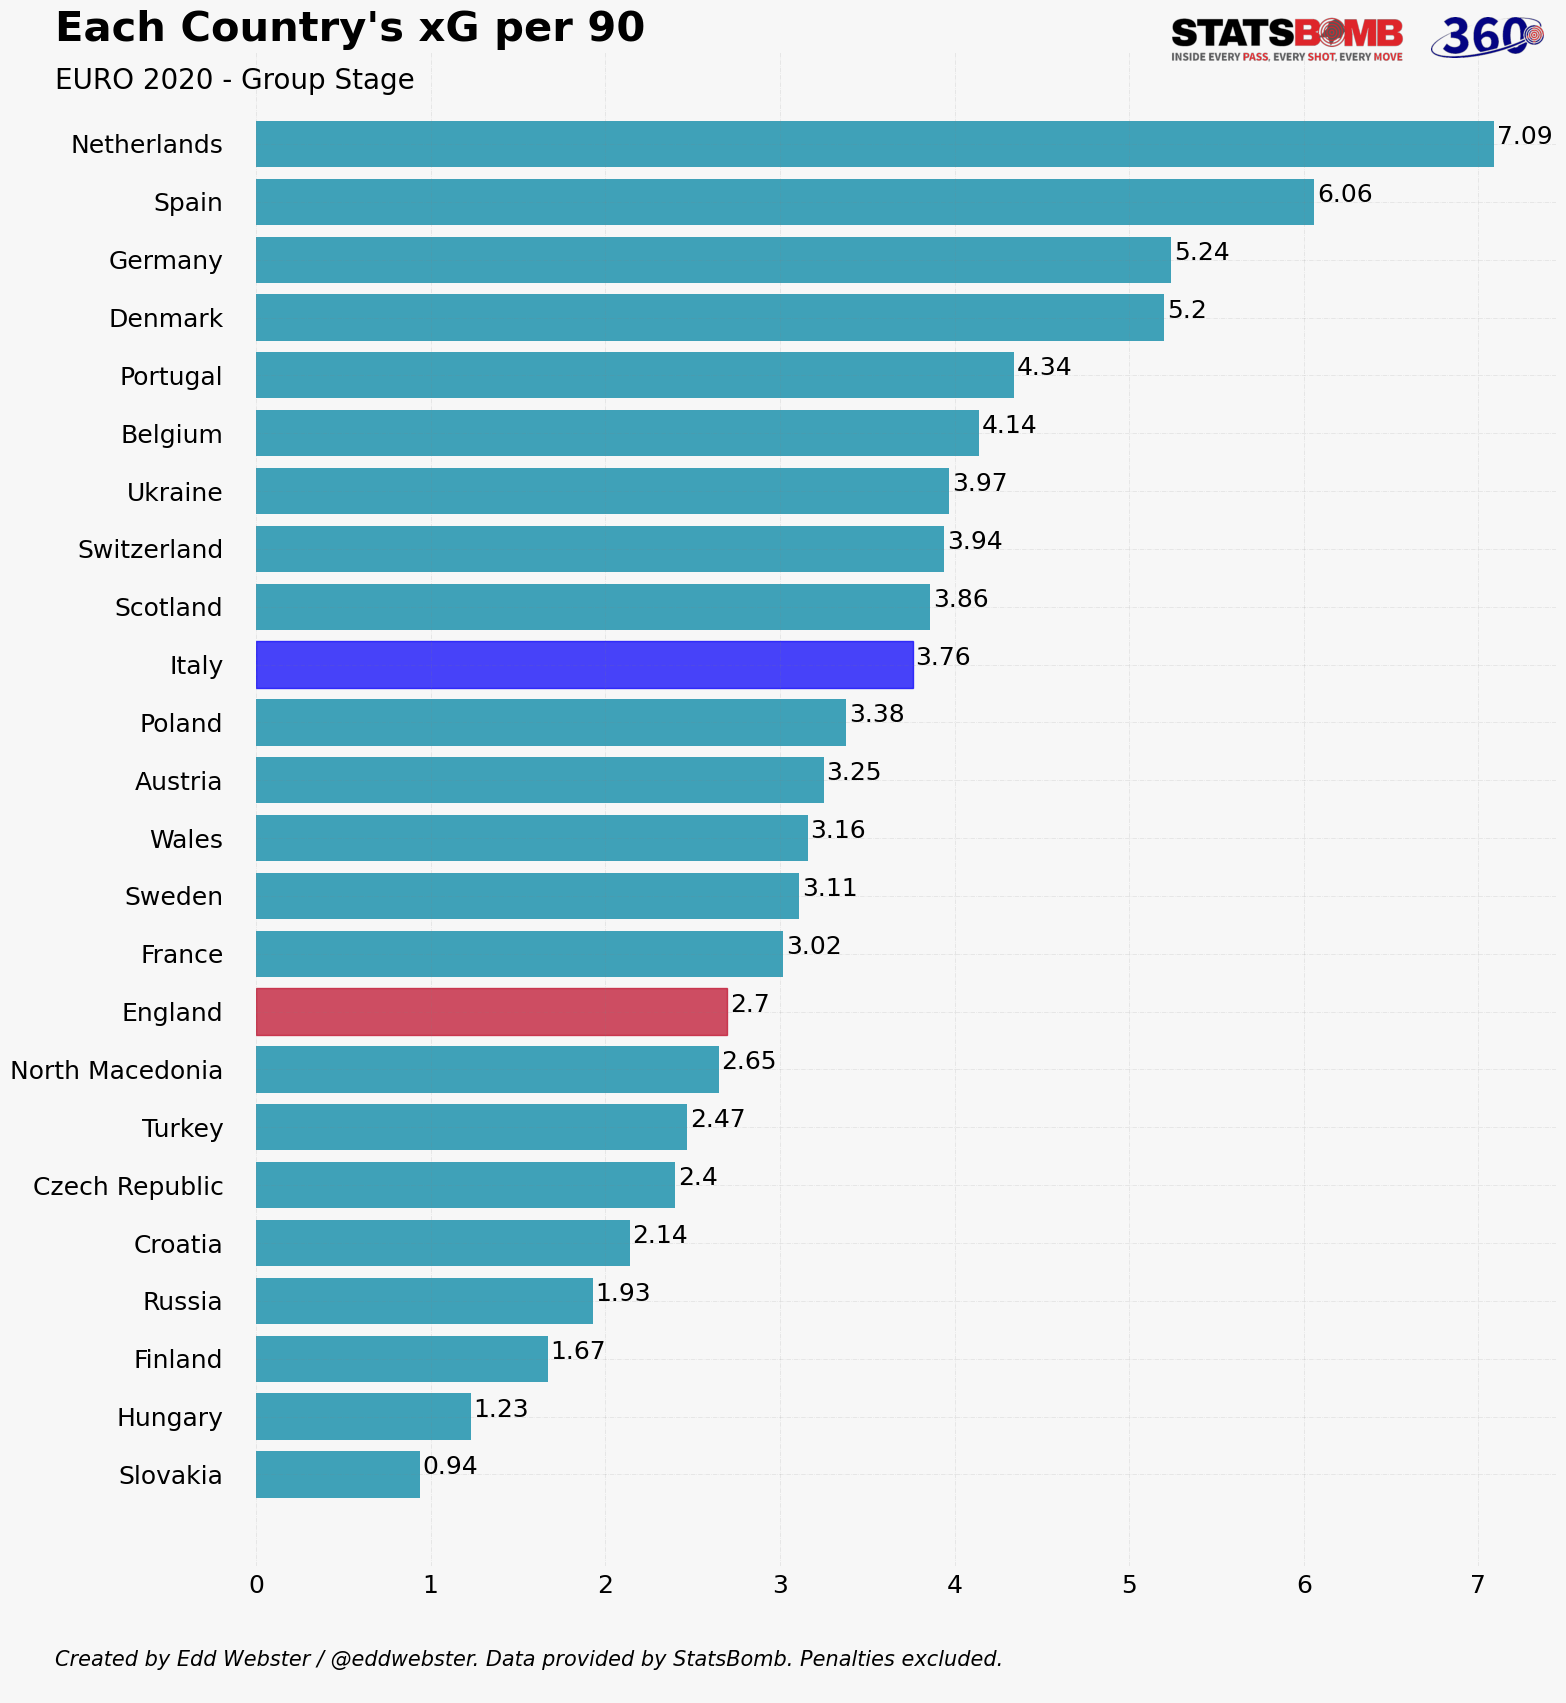

In [75]:
create_xg_bar_chart(df=df_events,
                    date_start='2021-06-11',
                    date_end='2021-06-24',
                    value='xg',
                    bar_colour='#0184a3',
                    selected_team_1=9,    #'Italy'     # currently selects by index
                    selected_team_1_colour='#0c05fa',  # commented out italy
                    selected_team_2=15,    #'England'
                    selected_team_2_colour='#c01430',
                    title='xG per 90',
                    subtitle='Group Stage'
                   )

<a id='section4.06.1.3'></a>

##### <a id='#section4.06.1.3'>4.06.1.3. xG Player</a>

In [76]:
# Define function to create an xG bar chart for teams
def create_xg_bar_chart_player(df,
                               bar_colour,
                               date_start,
                               date_end,
                               value,
                               count_players,
                               selected_player_1,
                               selected_player_1_colour,
                               selected_player_2,
                               selected_player_2_colour,
                               selected_player_3,
                               selected_player_3_colour,
                               title,
                               subtitle,
                               x_dimensions,
                               y_dimensions
                              ):
    
    """
    Function to create a bar chart for the xG of each team per match.
    """
    
    ## Data Engineering

    ### Create an 'isGoal attribute'
    df['isGoal'] = np.where(((df['type_name'] == 'Shot') & (df['shot_outcome_name'] == 'Goal')), 1, 0)
    df['team'] = np.where(df['team_name'] == df['home_team_name'], df['home_team_name'], df['away_team_name'])
    df['opponent'] = np.where(df['team_name'] == df['away_team_name'], df['home_team_name'], df['away_team_name'])
    df['xg'] = np.where((df['team_name'] == df['team']), df['shot_statsbomb_xg'], 0)
    df['opponent_xg'] = np.where((df['team_name'] == df['opponent']), df['shot_statsbomb_xg'], 0)

    ### Filter out all goals scored from penalties
    df = df[df['minute'] < 120]
    df = df[df['shot_type_name'] != 'Penalty']

    ### Filter between two dates
    df['match_date'] = pd.to_datetime(df['match_date'])
    mask = (df['match_date'] > date_start) & (df['match_date'] <= date_end)
    df = df.loc[mask]
    
    ### Groupby and aggregate
    df_player_grouped = (df
                         .groupby(['player_name'])
                         .agg({'shot_statsbomb_xg':['sum'],
                               'isGoal':['sum'],
                               'minute':['max']
                              }
                             )
                         .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_player_grouped.columns = ['player_name', 'xg', 'goals_scored', 'minutes_played']

    ### Determine bespoke metrics
    df_player_grouped['xg_p90'] = df_player_grouped['xg'] / (df_player_grouped['minutes_played'] / 90)
    df_player_grouped['goals_p90'] = df_player_grouped['goals_scored'] / (df_player_grouped['minutes_played'] / 90)

    ### Round the metrics to 2 or 3 decimal places
    df_player_grouped['xg'] = df_player_grouped['xg'].round(2)
    df_player_grouped['xg_p90'] = df_player_grouped['xg_p90'].round(2)
    df_player_grouped['goals_p90'] = df_player_grouped['goals_p90'].round(2)

    ### Sort by 'xg_p90' decending
    df_player_grouped = df_player_grouped.sort_values([value], ascending=[False])

    ### Reset index
    df_player_grouped = df_player_grouped.reset_index(drop=True)

    ### Filter DataFrame for top N players
    df_player_grouped = df_player_grouped.head(count_players)
    

    ## Data Visualisation

    ## Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#f7f7f7'    #'#313233'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    ### Define labels and metrics
    player = df_player_grouped['player_name']
    value = df_player_grouped[value]

    ### Create figure 
    fig, ax = plt.subplots(figsize =(16, 16))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    
    ### Create Horizontal Bar Plot
    bars = ax.barh(player,
                   value,
                   color=bar_colour,
                   alpha=0.75
                  )
    
    ### Select team of interest
    bars[selected_player_1].set_color(selected_player_1_colour)

    ### Select team of interest
    bars[selected_player_2].set_color(selected_player_2_colour)
    
    ### Select team of interest
    bars[selected_player_3].set_color(selected_player_3_colour)
    
    ### Add a grid and set gridlines
    ax.grid(linestyle='dotted',
            linewidth=0.25,
            color='#3B3B3B',
            axis='y',
            zorder=1
           )
    
    ### Remove top and right spines, colour bttom and left
    spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        if s in ['top', 'right', 'bottom', 'left']:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)

    ### Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ### Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=2)
    ax.yaxis.set_tick_params(pad=20)

    ### Add X, Y gridlines
    ax.grid(b=True,
            color='grey',
            linestyle='-.',
            linewidth=0.5,
            alpha=0.2
           )

    ### Show top values
    ax.invert_yaxis()

    ### Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.015, i.get_y()+0.4,
                 str(round((i.get_width()), 3)),
                 fontsize=18,
                 fontweight='regular',
                 color ='black'
                )
        
    ### Add Plot Title
    plt.figtext(0.045,
                0.99,
                f'Each Player\'s {title}',
                fontsize=30,
                fontweight='bold', 
                color=text_colour
               )

    ### Add Plot Subtitle
    fig.text(0.045, 0.96, f'EURO 2020 - {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)

    ### Add UEFA EURO 2020 logo
    #ax2 = fig.add_axes([0.985, 1.03, 0.12, 0.12])
    #ax2.axis('off')
    #img = image.imread('../img/competitions/uefa_euro_2020.png')
    #ax2.imshow(img)

    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.74, 0.915, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)

    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.905, 0.957, 0.07, 0.07])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)
    
    ### Footnote
    plt.figtext(0.045,
                -0.04,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb. Penalties excluded.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )
    
    ### Save figure
    if not os.path.exists(fig_dir + f'/xg_bar_chart_teams.png'):
        plt.savefig(fig_dir + f'/xg_bar_chart_teams.png', bbox_inches='tight', dpi=300)
    else:
        pass

    ## Show plt
    plt.tight_layout()
    plt.show()

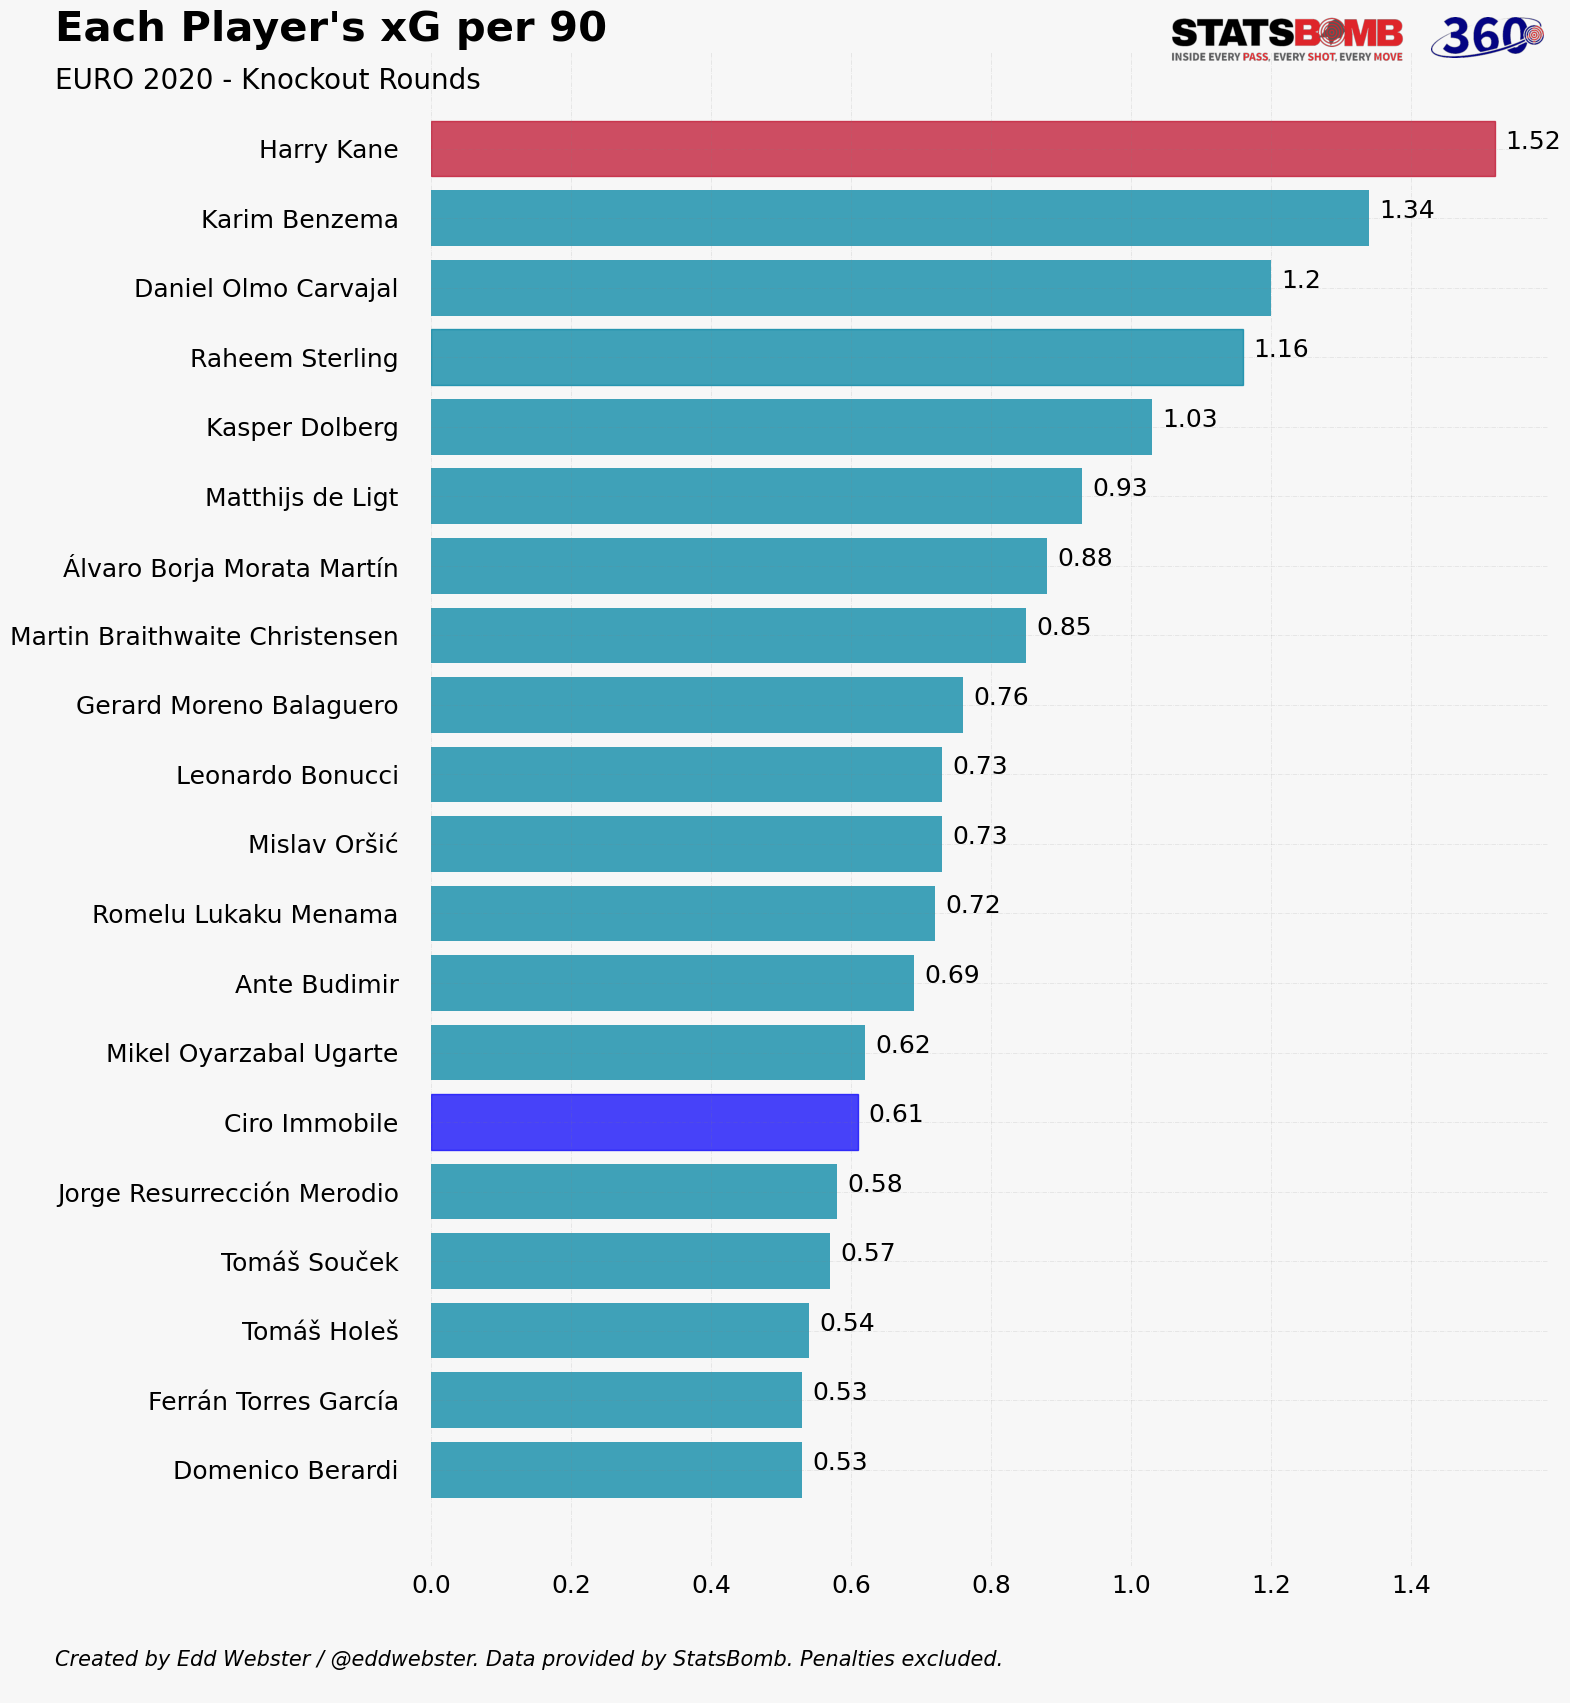

In [77]:
create_xg_bar_chart_player(df=df_events,
                                date_start='2021-06-25',
                                date_end='2021-07-24',
                                value='xg_p90',
                                bar_colour='#0184a3',
                                count_players=20,
                                selected_player_1=0,
                                selected_player_1_colour='#c01430',
                                selected_player_2=3,
                                selected_player_2_colour='#0184a3',   # used '#c01430' to highlight Sterling
                                selected_player_3=14,
                                selected_player_3_colour='#0c05fa',
                                title='xG per 90',
                                subtitle = 'Knockout Rounds',
                                x_dimensions=16.5,
                                y_dimensions=10.5
                               )

<a id='section4.06.1.4'></a>

##### <a id='#section4.06.1.4'>4.06.1.4. xGA</a>

In [78]:
# Define function xGA bar charts
def create_xga_bar_chart(df,
                         bar_colour,
                         date_start,
                         date_end,
                         value,
                         selected_team_1,
                         selected_team_1_colour,
                         selected_team_2,
                         selected_team_2_colour,
                         subtitle
                        ):
    
    """
    Function to create a bar chart for the xGA of each team per match.
    """
    
    ## Data Engineering

    ### Create an 'isGoal attribute'
    df['isGoal'] = np.where(((df['type_name'] == 'Shot') & (df['shot_outcome_name'] == 'Goal')), 1, 0)
    df['team'] = np.where(df['team_name'] == df['home_team_name'], df['home_team_name'], df['away_team_name'])
    df['opponent'] = np.where(df['team_name'] == df['away_team_name'], df['home_team_name'], df['away_team_name'])
    df['team_xg'] = np.where((df['team_name'] == df['team']), df['shot_statsbomb_xg'], 0)
    df['opponent_xg'] = np.where((df['team_name'] == df['opponent']), df['shot_statsbomb_xg'], 0)

    ### Filter out all goals scored from penalties
    df = df[df['minute'] < 120]
    df = df[df['shot_type_name'] != 'Penalty']

    ### Filter between two dates
    df['match_date'] = pd.to_datetime(df['match_date'])
    mask = (df['match_date'] > date_start) & (df['match_date'] <= date_end)
    df = df.loc[mask]
    
    ### Groupby and aggregate
    df_fixture_xg_1 = (df
                         .groupby(['team', 'opponent'])
                         .agg({'shot_statsbomb_xg':['sum'],
                               'isGoal':['sum'],
                               'minute':['max']
                              }
                             )
                         .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_fixture_xg_1.columns = ['team', 'opponent', 'team_xg', 'team_goals', 'minutes']

    ### Groupby and aggregate
    df_fixture_xg_2 = (df
                         .groupby(['opponent', 'team'])
                         .agg({'shot_statsbomb_xg':['sum'],
                               'isGoal':['sum'],
                               'minute':['max']
                              }
                             )
                         .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_fixture_xg_2.columns = ['opponent_2', 'team_2', 'opponent_xg', 'opponent_goals', 'minutes_2']

    ### Rearrange columns
    df_fixture_xg_2 = df_fixture_xg_2[['team_2', 'opponent_2', 'opponent_xg', 'opponent_goals', 'minutes_2']].drop_duplicates()

    ### Join the two xG DataFrames
    df_fixture_xg = df_fixture_xg_1.merge(df_fixture_xg_2, left_on=['team', 'opponent'], right_on=['opponent_2', 'team_2'], how='left')

    ### Groupby and aggregate
    df_team_grouped = (df_fixture_xg
                           .groupby(['team'])
                           .agg({'opponent':['count'],
                                 'minutes':['sum'],
                                 'team_xg':['sum'],
                                 'opponent_xg':['sum'],
                                 'team_goals':['sum'],
                                 'opponent_goals':['sum']
                                }
                               )
                           .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_team_grouped.columns = ['team', 'games_played', 'minutes_played', 'xg', 'xga', 'goals_scored', 'goals_conceded']

    ### Determine bespoke metrics
    df_team_grouped['xg_p90'] = df_team_grouped['xg'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xg_per_game'] = df_team_grouped['xg'] / df_team_grouped['games_played']
    df_team_grouped['xga_p90'] = df_team_grouped['xga'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xga_per_game'] = df_team_grouped['xga'] / df_team_grouped['games_played']
    df_team_grouped['goals_p90'] = df_team_grouped['goals_scored'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['goals_per_game'] = df_team_grouped['goals_scored'] / df_team_grouped['games_played']
    df_team_grouped['goals_conceded_p90'] = df_team_grouped['goals_conceded'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['goals_conceded_per_game'] = df_team_grouped['goals_conceded'] / df_team_grouped['games_played']
    df_team_grouped['goal_difference'] = df_team_grouped['goals_scored'] - df_team_grouped['goals_conceded']
    df_team_grouped['xg_diff'] = df_team_grouped['xg'] - df_team_grouped['xga']
    df_team_grouped['xg_diff_p90'] = df_team_grouped['xg_diff'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xg_diff_per_game'] = df_team_grouped['xg_diff'] / df_team_grouped['games_played']

    ### Round the metrics to 2 or 3 decimal places
    df_team_grouped['xg'] = df_team_grouped['xg'].round(2)
    df_team_grouped['xga'] = df_team_grouped['xga'].round(2)
    df_team_grouped['xg_p90'] = df_team_grouped['xg_p90'].round(2)
    df_team_grouped['xg_per_game'] = df_team_grouped['xg_per_game'].round(2)
    df_team_grouped['xga_p90'] = df_team_grouped['xga_p90'].round(2)
    df_team_grouped['xga_per_game'] = df_team_grouped['xga_per_game'].round(2)
    df_team_grouped['goals_p90'] = df_team_grouped['goals_p90'].round(2)
    df_team_grouped['goals_per_game'] = df_team_grouped['goals_per_game'].round(2)
    df_team_grouped['goals_conceded_p90'] = df_team_grouped['goals_conceded_p90'].round(2)
    df_team_grouped['goals_conceded_per_game'] = df_team_grouped['goals_conceded_per_game'].round(2)
    df_team_grouped['xg_diff'] = df_team_grouped['xg_diff'].round(2)
    df_team_grouped['xg_diff_p90'] = df_team_grouped['xg_diff_p90'].round(3)
    df_team_grouped['xg_diff_per_game'] = df_team_grouped['xg_diff_per_game'].round(3)

    ### Sort by 'xg_per_game_diff' decending
    df_team_grouped = df_team_grouped.sort_values([value], ascending=[True])

    ### Reset index
    df_team_grouped = df_team_grouped.reset_index(drop=True)
    
    

    ## Data Visualisation

    ## Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#f7f7f7'    #'#313233'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    ### Define labels and metrics
    player = df_team_grouped['team']
    value = df_team_grouped[value]

    ### Create figure 
    fig, ax = plt.subplots(figsize =(16, 16))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    
    ### Create Horizontal Bar Plot
    bars = ax.barh(player,
                   value,
                   color=bar_colour,
                   alpha=0.75
                  )
    
    ### Select team of interest
    bars[selected_team_1].set_color(selected_team_1_colour)

    ### Select team of interest
    bars[selected_team_2].set_color(selected_team_2_colour)
    
    ### Add a grid and set gridlines
    ax.grid(linestyle='dotted',
            linewidth=0.25,
            color='#3B3B3B',
            axis='y',
            zorder=1
           )
    
    ### Remove top and right spines, colour bttom and left
    spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        if s in ['top', 'right', 'bottom', 'left']:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)

    ### Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ### Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=2)
    ax.yaxis.set_tick_params(pad=20)

    ### Add X, Y gridlines
    ax.grid(b=True,
            color='grey',
            linestyle='-.',
            linewidth=0.5,
            alpha=0.2
           )

    ### Show top values
    ax.invert_yaxis()

    ### Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.015, i.get_y()+0.4,
                 str(round((i.get_width()), 3)),
                 fontsize=18,
                 fontweight='regular',
                 color ='black'
                )
        
    ### Add Plot Title
    plt.figtext(0.045,
                0.99,
                f'Each Country\'s xG Conceded',
                fontsize=30,
                fontweight='bold', 
                color=text_colour
               )

    ### Add Plot Subtitle
    fig.text(0.045, 0.96, f'EURO 2020 - {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)

    ### Add UEFA EURO 2020 logo
    #ax2 = fig.add_axes([0.985, 1.03, 0.12, 0.12])
    #ax2.axis('off')
    #img = image.imread('../img/competitions/uefa_euro_2020.png')
    #ax2.imshow(img)

    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.74, 0.915, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)

    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.905, 0.957, 0.07, 0.07])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)
    
    ### Footnote
    plt.figtext(0.045,
                -0.04,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\nA team\'s xG Conceded is the total xG of the chances of each country\'s opponents. Penalties excluded.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )
    
    ### Save figure
    if not os.path.exists(fig_dir + f'/xg_diff_bar_chart_teams.png'):
        plt.savefig(fig_dir + f'/xg_diff_bar_chart_teams.png', bbox_inches='tight', dpi=300)
    else:
        pass

    ## Show plt
    plt.tight_layout()
    plt.show()

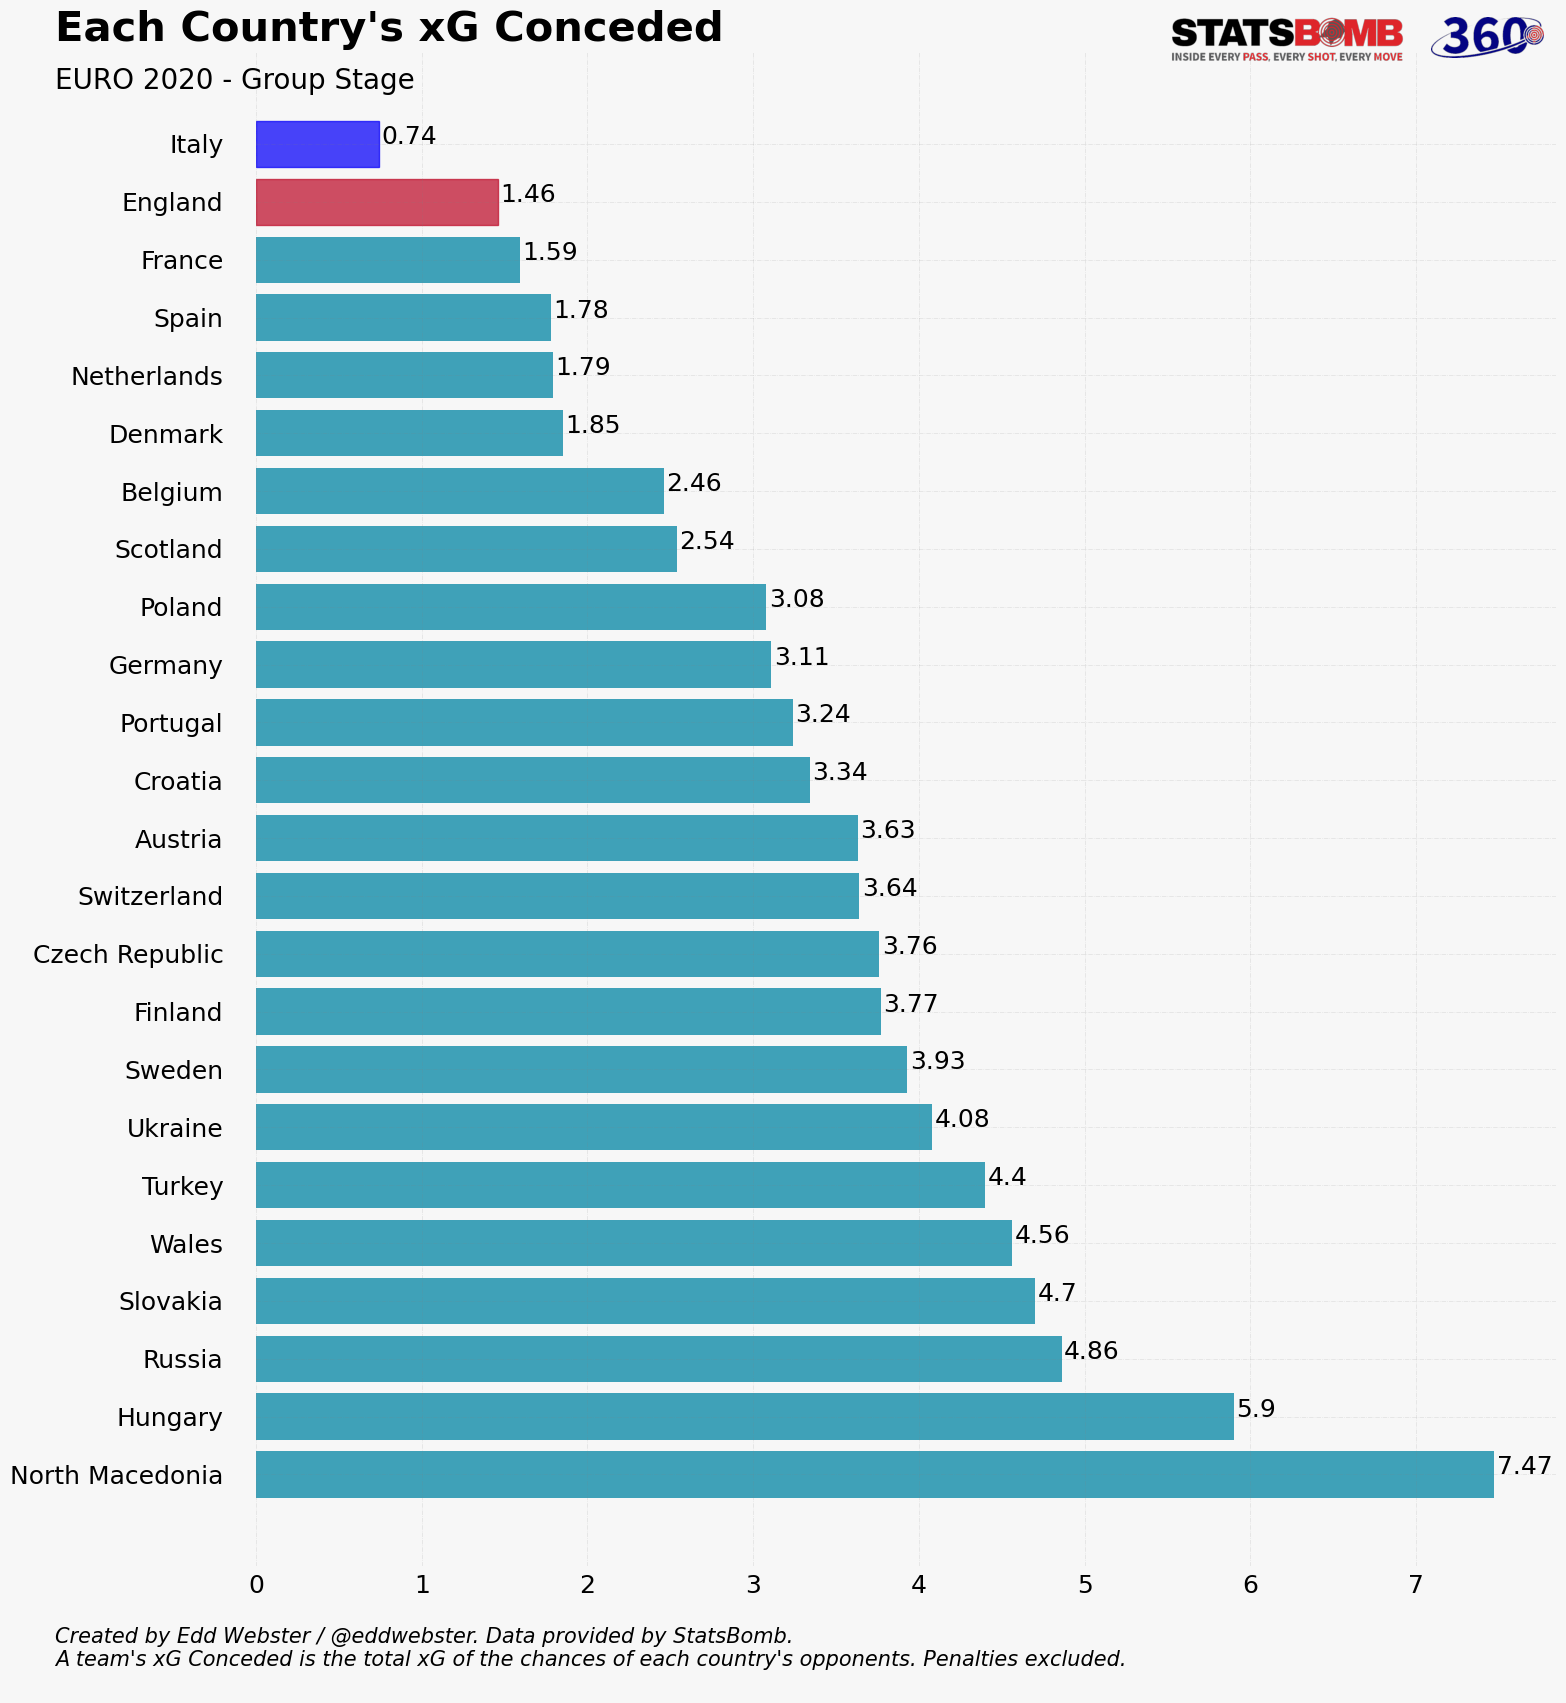

In [79]:
create_xga_bar_chart(df=df_events,
                     date_start='2021-06-11',
                     date_end='2021-06-24',
                     value='xga',
                     bar_colour='#0184a3',
                     selected_team_1=0,    #'Italy'     # currently selects by index
                     selected_team_1_colour='#0c05fa',  # commented out italy
                     selected_team_2=1,    #'England'
                     selected_team_2_colour='#c01430',
                     subtitle = 'Group Stage'
                    )

<a id='section4.06.2'></a>

#### <a id='#section4.06.2'>4.06.2. Scatter Plot</a>

In [80]:
# Define function xG difference scatter plots
def create_xg_diff_scatter_plot(df, colour_scale):
    
    """
    Function to create a scatter plot of the xG difference for each team.
    """

    ## Data Engineering

    ### Create an 'isGoal attribute'
    df['isGoal'] = np.where(((df['type_name'] == 'Shot') & (df['shot_outcome_name'] == 'Goal')), 1, 0)
    df['team'] = np.where(df['team_name'] == df['home_team_name'], df['home_team_name'], df['away_team_name'])
    df['opponent'] = np.where(df['team_name'] == df['away_team_name'], df['home_team_name'], df['away_team_name'])
    df['team_xg'] = np.where((df['team_name'] == df['team']), df['shot_statsbomb_xg'], 0)
    df['opponent_xg'] = np.where((df['team_name'] == df['opponent']), df['shot_statsbomb_xg'], 0)

    ### Filter out all goals scored from penalties
    df = df[df['minute'] < 120]
    df = df[df['shot_type_name'] != 'Penalty']

    ### Groupby and aggregate
    df_fixture_xg_1 = (df
                         .groupby(['team', 'opponent'])
                         .agg({'shot_statsbomb_xg':['sum'],
                               'isGoal':['sum'],
                               'minute':['max']
                              }
                             )
                         .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_fixture_xg_1.columns = ['team', 'opponent', 'team_xg', 'team_goals', 'minutes']

    ### Groupby and aggregate
    df_fixture_xg_2 = (df
                         .groupby(['opponent', 'team'])
                         .agg({'shot_statsbomb_xg':['sum'],
                               'isGoal':['sum'],
                               'minute':['max']
                              }
                             )
                         .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_fixture_xg_2.columns = ['opponent_2', 'team_2', 'opponent_xg', 'opponent_goals', 'minutes_2']

    ### Rearrange columns
    df_fixture_xg_2 = df_fixture_xg_2[['team_2', 'opponent_2', 'opponent_xg', 'opponent_goals', 'minutes_2']].drop_duplicates()

    ### Join the two xG DataFrames
    df_fixture_xg = df_fixture_xg_1.merge(df_fixture_xg_2, left_on=['team', 'opponent'], right_on=['opponent_2', 'team_2'], how='left')

    ### Groupby and aggregate
    df_team_grouped = (df_fixture_xg
                           .groupby(['team'])
                           .agg({'opponent':['count'],
                                 'minutes':['sum'],
                                 'team_xg':['sum'],
                                 'opponent_xg':['sum'],
                                 'team_goals':['sum'],
                                 'opponent_goals':['sum']
                                }
                               )
                           .reset_index() 
                      )

    ### Rename columns after groupby and aggregation
    df_team_grouped.columns = ['team', 'games_played', 'minutes_played', 'xg', 'xga', 'goals_scored', 'goals_conceded']

    ### Determine bespoke metrics
    df_team_grouped['xg_p90'] = df_team_grouped['xg'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xg_per_game'] = df_team_grouped['xg'] / df_team_grouped['games_played']
    df_team_grouped['xga_p90'] = df_team_grouped['xga'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xga_per_game'] = df_team_grouped['xga'] / df_team_grouped['games_played']
    df_team_grouped['goals_p90'] = df_team_grouped['goals_scored'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['goals_per_game'] = df_team_grouped['goals_scored'] / df_team_grouped['games_played']
    df_team_grouped['goals_conceded_p90'] = df_team_grouped['goals_conceded'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['goals_conceded_per_game'] = df_team_grouped['goals_conceded'] / df_team_grouped['games_played']
    df_team_grouped['goal_difference'] = df_team_grouped['goals_scored'] - df_team_grouped['goals_conceded']
    df_team_grouped['xg_diff'] = df_team_grouped['xg'] - df_team_grouped['xga']
    df_team_grouped['xg_diff_p90'] = df_team_grouped['xg_diff'] / (df_team_grouped['minutes_played'] / 90)
    df_team_grouped['xg_diff_per_game'] = df_team_grouped['xg_diff'] / df_team_grouped['games_played']

    ### Round the metrics to 2 or 3 decimal places
    df_team_grouped['xg'] = df_team_grouped['xg'].round(2)
    df_team_grouped['xga'] = df_team_grouped['xga'].round(2)
    df_team_grouped['xg_p90'] = df_team_grouped['xg_p90'].round(2)
    df_team_grouped['xg_per_game'] = df_team_grouped['xg_per_game'].round(2)
    df_team_grouped['xga_p90'] = df_team_grouped['xga_p90'].round(2)
    df_team_grouped['xga_per_game'] = df_team_grouped['xga_per_game'].round(2)
    df_team_grouped['goals_p90'] = df_team_grouped['goals_p90'].round(2)
    df_team_grouped['goals_per_game'] = df_team_grouped['goals_per_game'].round(2)
    df_team_grouped['goals_conceded_p90'] = df_team_grouped['goals_conceded_p90'].round(2)
    df_team_grouped['goals_conceded_per_game'] = df_team_grouped['goals_conceded_per_game'].round(2)
    df_team_grouped['xg_diff'] = df_team_grouped['xg_diff'].round(2)
    df_team_grouped['xg_diff_p90'] = df_team_grouped['xg_diff_p90'].round(3)
    df_team_grouped['xg_diff_per_game'] = df_team_grouped['xg_diff_per_game'].round(3)

    ### Sort by 'xg_per_game_diff' decending
    df_team_grouped = df_team_grouped.sort_values(['xg_diff_p90'], ascending=[False])

    ### Reset index
    df_team_grouped = df_team_grouped.reset_index(drop=True)



    ## Data Visualisation

    ### Define fonts and colours
    #title_font = 'Alegreya Sans'
    #main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 15})


    ### Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)


    ### Add a grid and set gridlines
    ax.grid(linestyle='dotted',
            linewidth=0.25,
            color='#3B3B3B',
            axis='y',
            zorder=1
           )

    
    ### Remove top and right spines, colour bttom and left
    spines = ['top', 'right', 'bottom', 'left']
    for s in spines:
        if s in ['top', 'right', 'bottom', 'left']:
            ax.spines[s].set_visible(False)
        else:
            ax.spines[s].set_color(text_colour)

            
    ### Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    
    ### Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=2)
    ax.yaxis.set_tick_params(pad=20)

    ### Add X, Y gridlines
    ax.grid(b=True,
            color='grey',
            linestyle='-.',
            linewidth=0.5,
            alpha=0.2
           )


    ### Define X and Y values
    xga_p90 = df_team_grouped['xga_p90'].tolist()
    xg_p90 = df_team_grouped['xg_p90'].tolist() 
    teams = df_team_grouped['team'].tolist()
    xg_diff_p90 = df_team_grouped['xg_diff_p90'].tolist()


    ### Label the nodes
    for i, label in enumerate(teams):
        plt.annotate(label,(xga_p90[i], xg_p90[i]))


    ### Define Z order
    zo = 12


    ### Create scatter plot of shots
    ax.scatter(xga_p90,
               xg_p90,
               marker='o',
              #color=point_colour,
               edgecolors='black',
               c=xg_diff_p90,
               cmap=colour_scale,
              #linewidths=0.5,
               s=200,
               alpha=0.7,
               zorder=zo
              )


    ### Show Legend
    #plt.legend(loc='upper left')     # commented out as not required

    ### Add Plot Title
    plt.figtext(0.045,
                1.04,
                f'Each Country\'s xG vs. xGA',
                fontsize=30,
                fontweight='bold', 
                color=text_colour
               )


    ### Add Plot Subtitle
    fig.text(0.045, 1.00, f'EURO 2020', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)

    
    ### Add X and Y labels
    plt.xlabel('xG Conceded', color=text_colour, fontsize=18)
    plt.ylabel('xG', color=text_colour, fontsize=18)
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2])
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6])
    plt.xlim([0.4, 2.6])
    plt.ylim([0, 2.2])
    
    
    ### Invert x axis - less xGA is better
    ax.invert_xaxis()

    
    ### Remove pips
    ax.tick_params(axis='both', length=0)
    
    
    ### Add UEFA EURO 2020 logo
    ax2 = fig.add_axes([0.90, 0.95, 0.12, 0.12])
    ax2.axis('off')
    img = image.imread('../img/competitions/uefa_euro_2020.png')
    ax2.imshow(img)


    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.755, -0.0965, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)


    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.9175, -0.0535, 0.07, 0.07])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)


    ### Footnote
    plt.figtext(0.045,
                -0.05,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\nxG and xGA standardised per 90 minutes. Penalties excluded.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )


    ### Save figure
    if not os.path.exists(fig_dir + f'/xg_diff_scatter_plot_teams.png'):
        plt.savefig(fig_dir + f'/xg_diff_scatter_plot_teams.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

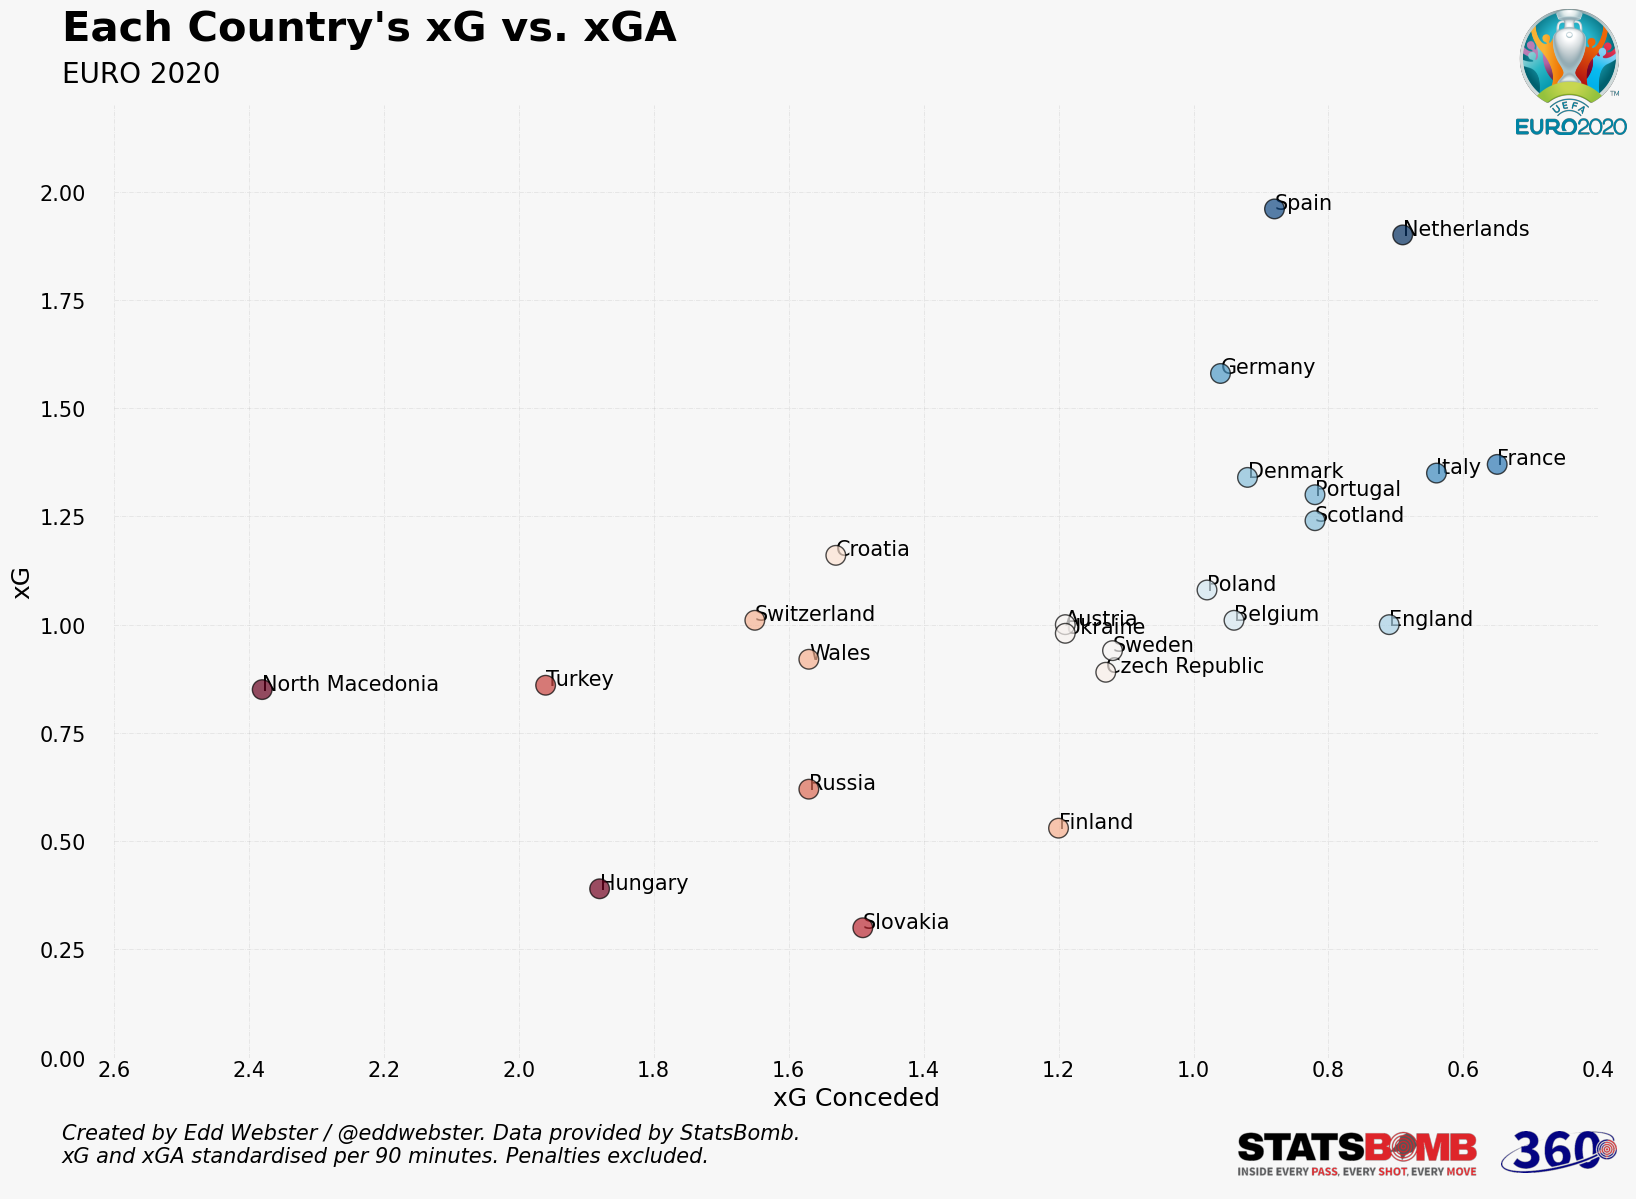

In [81]:
create_xg_diff_scatter_plot(df=df_events,
                            colour_scale='RdBu',
                           #point_colour='#0184a3'
                           )

<a id='section4.07'></a>

### <a id='#section4.07'>4.07. Passing Network</a>

In [82]:
## Define function for creating a passing network
def create_passing_network(df,
                           home_team,
                           away_team,
                           passing_network_team,
                           opponent,
                           passing_network_team_colour,
                           opponent_colour,
                           node_colour,
                           arrow_colour,
                           minute_start,
                           minute_end,
                           pitch_length_x,
                           pitch_length_y,
                           pass_threshold,
                           orientation,
                           aspect,
                           title,
                           players_to_exclude,
                           subtitle
                          ):
    
    """
    Function to create a passing network, originally made using the 
    'draw_pitch' function, created by Peter McKeever @petermckeever, however,
    due to some temporary technical issues, it's replaced with the pitch from mplsoccer
    """

    ## Data Engineering

    ### Filter DataFrame for a single match and then only select team of interest
    df = df[(df['home_team_name'] == home_team) & (df['away_team_name'] == away_team)].reset_index(drop=True)
    df = df[(df['team_name'] == passing_network_team)].reset_index(drop=True)


    ### Determine passers and recipients by ID and then filter for only passes
    df['passer'] = df['player_id']
    df['recipient'] = df['pass_recipient_id']


    ### Filter DataFrame for only passes and ind passes and then only look for the successful passes
    df_passes = df[df['type_name']=='Pass']
    df_successful = df_passes[df_passes['pass_outcome_name'].isnull()]


    ### Filter time
    #period_mask = (df_successful['period'] >= period_start) & (df_successful['period'] <= period_end)
    minute_mask = (df_successful['minute'] >= minute_start) & (df_successful['minute'] <= minute_end)
    #df_successful = df_successful.loc[(period_mask & minute_mask)]
    df_successful = df_successful.loc[minute_mask]


    ### Determine the first subsititution and filter the successful dataframe to be less than that minute
    #df_subs = df[df['next_event']=='Substitution']
    #df_subs = df_subs['minute']


    #### Determine when the first substitute took place
    #first_sub = df_subs.min()


    #### Filter DataFrame of successful pass for up until the first substitute takes place in the match
    #df_successful = df_successful[df_successful['minute'] < first_sub]


    ### Convert IDs of passer and recipients are floats
    pas = pd.to_numeric(df_successful['passer'], downcast='integer')
    rec = pd.to_numeric(df_successful['recipient'], downcast='integer')
    df_successful['passer'] = pas
    df_successful['recipient'] = rec
    df_successful['passer'] = df_successful['passer'].astype(float)
    df_successful['recipient'] = df_successful['recipient'].astype(float)

    ### Determine the average locations and counts of the passes
    df_average_locations = (df_successful
                                .groupby(['player_name', 'passer'])
                                .agg({'location_x':['mean'],
                                      'location_y':['mean','count']
                                     }
                                    )
                           )


    ### Rename columns after groupby and aggregation
    df_average_locations.columns = ['location_x', 'location_y', 'count']


    #### Reset index
    df_average_locations = df_average_locations.reset_index(drop=False)


    ### Groupby and aggregate the the number of passes between passers and recipients

    #### Now we need to find the number of passes between each player
    df_pass_between = (df_successful
                           .groupby(['player_name', 'passer', 'recipient'])
                           .id.count()
                           .reset_index()
                      )

    #### Rename columns
    df_pass_between = df_pass_between.rename({'player_name':'passer_name',
                                              'id':'pass_count'
                                             }, axis='columns')



    ### Merge the average location dataframe. We need to merge on the passer first then the recipient

    ####
    df_pass_between = df_pass_between.merge(df_average_locations, left_on='passer', right_on='passer')
    df_pass_between = df_pass_between.merge(df_average_locations, left_on='recipient', right_on='passer', suffixes=['', '_end'])

    #### Set minimum threshold of combinations
    df_pass_between = df_pass_between[df_pass_between['pass_count'] >= pass_threshold]

    #### Filter out any players to remove
    df_average_locations = df_average_locations[~df_average_locations['player_name'].isin(players_to_exclude)]
    df_pass_between = df_pass_between[~df_pass_between['player_name'].isin(players_to_exclude)]

    ### Select columns of interest
    df_unique_nodes = df_pass_between[['passer_name', 'passer', 'location_x', 'location_y']].drop_duplicates()
    df_unique_nodes['pass_surname'] = df_unique_nodes['passer_name'].str.split(' ').str[-1]
    
    
    
    ## Visualisation

    ### Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background = '#F7F7F7'
    title_colour = 'black'
    text_colour = 'black'
    filler = 'grey'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 17})


    """
    ### Draw the pitch using the Peter McKeever's 'draw_pitch function'
    pitch = draw_pitch(x_min=0,
                       x_max=pitch_length_x,
                       y_min=0,
                       y_max=pitch_length_y,
                       orientation=orientation,
                       aspect=aspect,
                       pitch_color=background,
                       line_color='#3B3B3B',
                       ax=ax
                      )

    """


    #### Plot the pitch
    pitch = Pitch(pitch_type='statsbomb',
                  orientation='horizontal',
                  pitch_color=background,
                  line_color='#3B3B3B',
                  figsize=(16.5, 10.5),
                  constrained_layout=True,
                  tight_layout=False
                 )


    ### Create fixture 
    fig, ax = pitch.draw(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)


    ### Plot the nodes
    nodes = pitch.scatter(df_average_locations['location_x'],
                          df_average_locations['location_y'],
                          s=1000,
                          color=node_colour,
                          edgecolors='black',
                          linewidth=2.5,
                          alpha=1,
                          zorder=1,
                          ax=ax
                         )    


    ### 
    x = df_unique_nodes['location_x'].tolist()
    y = df_unique_nodes['location_y'].tolist()
    players = df_unique_nodes['pass_surname'].tolist()


    ### Label the nodes
    for i, label in enumerate(players):
        plt.annotate(label,(x[i], y[i]))


    ### Plot the arrows
    arrows = pitch.arrows(df_pass_between['location_x'],
                          df_pass_between['location_y'],
                          df_pass_between['location_x_end'],
                          df_pass_between['location_y_end'],
                          width=7,
                         #width=df_pass_between['pass_count']*1000,
                         #headwidth=df_pass_between['pass_count']*1000,
                          headwidth=3,
                          color=arrow_colour,
                          zorder=1,
                          alpha=0.4,
                          ax=ax
                         )


    ### Add Plot Title
    s = '<{}>\'s Passing Network {} vs. <{}> at EURO 2020\n'
    htext.fig_htext(s.format(passing_network_team, title, opponent), 0.09, 0.915, highlight_colors=[passing_network_team_colour, opponent_colour], highlight_weights=['bold'], string_weight='bold', fontsize=22, fontfamily=title_font, color=text_colour)


    ### Add Plot Subtitle
    #fig.text(0.04, 1.029, f'EURO 2020 {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)


    ### Add UEFA EURO 2020 logo
    ax2 = fig.add_axes([0.81, 0.80, 0.12, 0.12])
    ax2.axis('off')
    img = image.imread('../img/competitions/uefa_euro_2020.png')
    ax2.imshow(img)


    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.67, 0.02, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)


    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.83, 0.060, 0.075, 0.075])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)


    ### Footnote
    plt.figtext(0.09,
                0.010,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )

    """
    ### Save figure
    if not os.path.exists(fig_dir + f'/passing_network_{home_team}_{away_team}_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/passing_network_{home_team}_{away_team}_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass
    """

    ### Show plt
    plt.tight_layout()
    plt.show()

findfont: Font family ['Alegreya Sans'] not found. Falling back to DejaVu Sans.


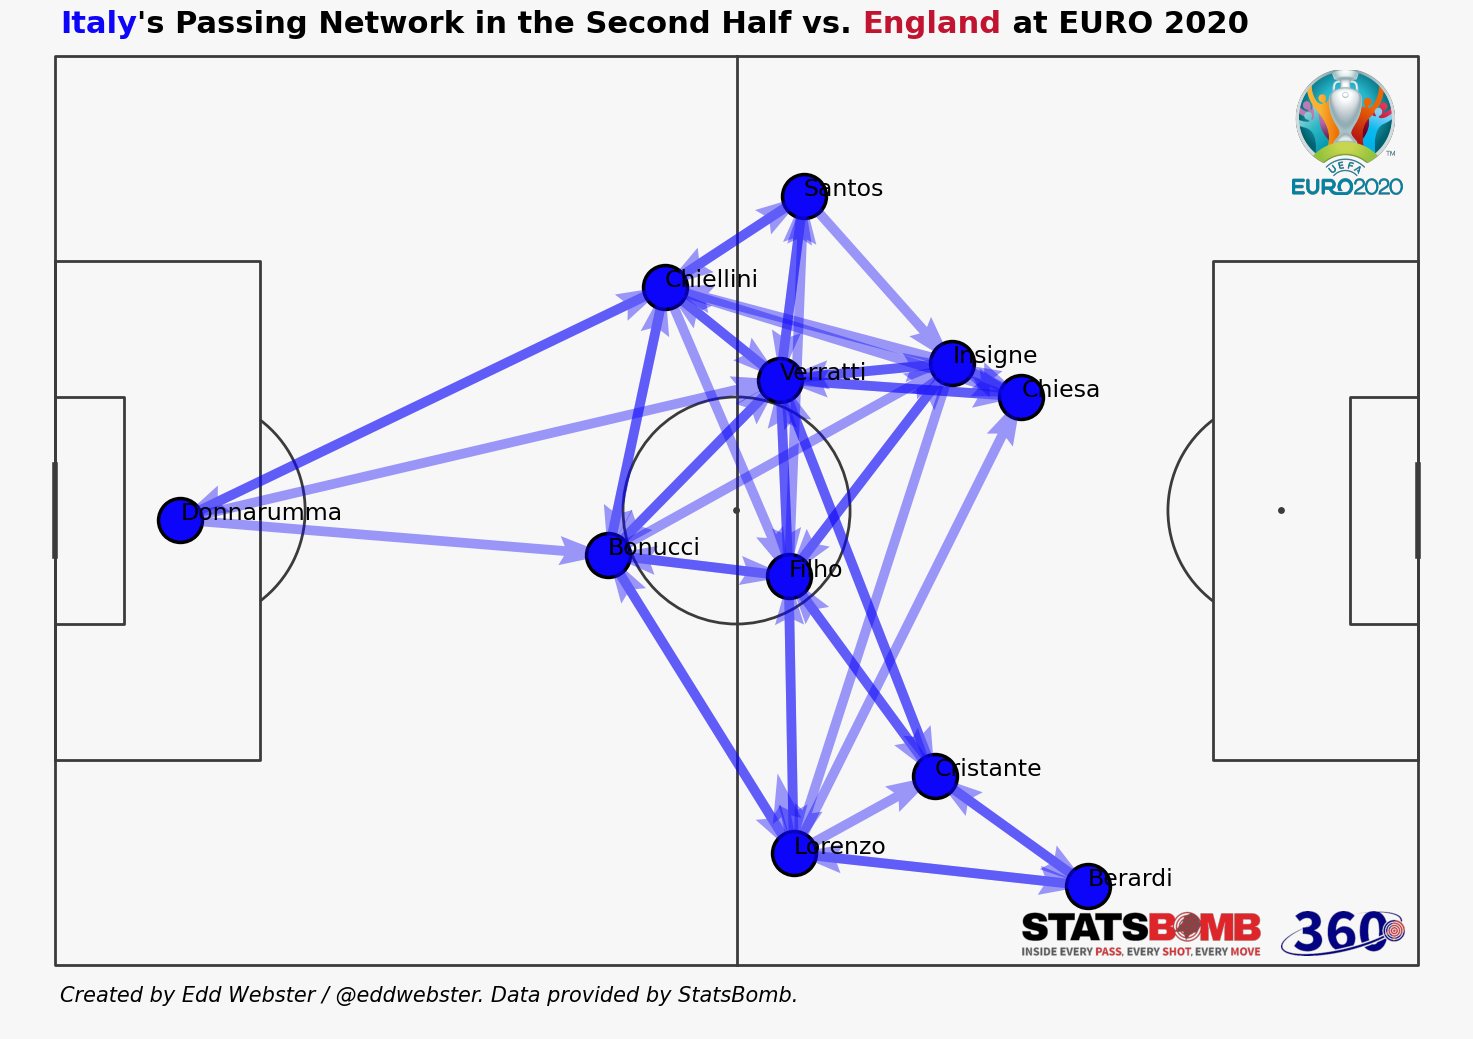

In [83]:
create_passing_network(df=df_events,
                       home_team='Italy',
                       away_team='England',
                       passing_network_team='Italy',
                       opponent='England',
                       passing_network_team_colour='#0c05fa',
                       opponent_colour='#c01430',
                       node_colour='#0c05fa',
                       arrow_colour='#0c05fa',
                       minute_start=46,
                       minute_end=90,
                       pitch_length_x=120,
                       pitch_length_y=80,
                       pass_threshold=2,
                       orientation='horizontal',
                       aspect='fll',
                       players_to_exclude = ['Ciro Immobile', 'Nicolò Barella', 'Federico Bernardeschi', 'Andrea Belotti', 'Manuel Locatelli', 'Alessandro Florenzi'],
                       title = 'in the Second Half',
                       subtitle='Final'
                      )

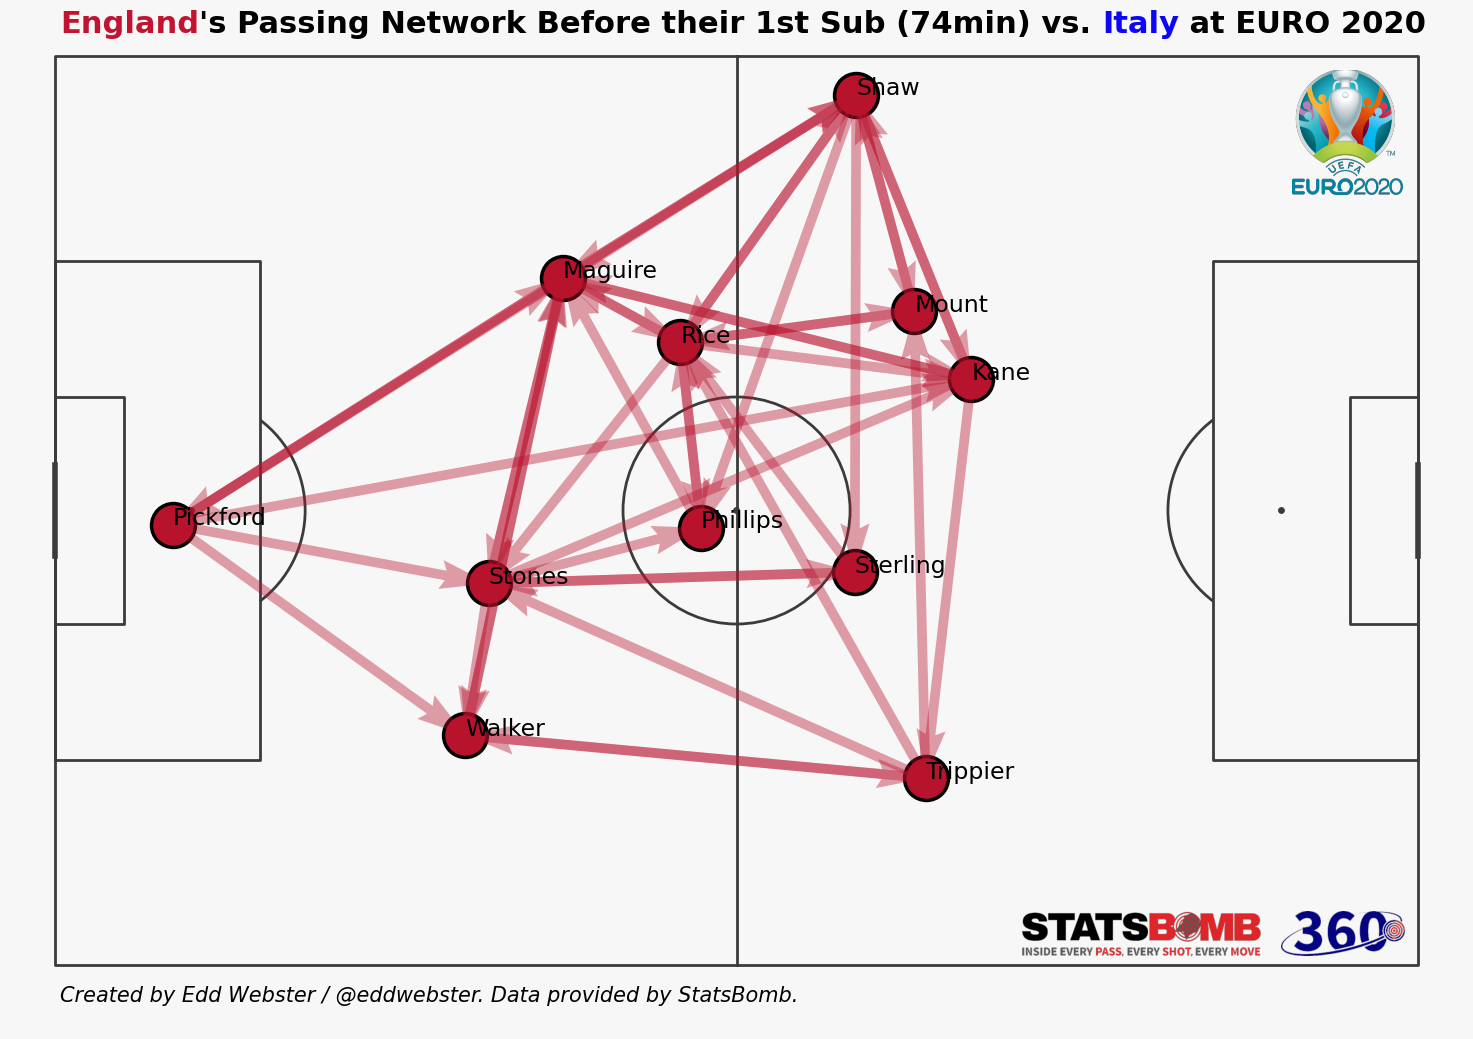

In [84]:
create_passing_network(df=df_events,
                       home_team='Italy',
                       away_team='England',
                       passing_network_team='England',
                       opponent='Italy',
                       passing_network_team_colour='#c01430',
                       opponent_colour='#0c05fa',
                       node_colour='#b8132d',
                       arrow_colour='#b8132d',
                       minute_start=3,
                       minute_end=70,
                       pitch_length_x=120,
                       pitch_length_y=80,
                       pass_threshold=2,
                       orientation='horizontal',
                       aspect='fll',
                       players_to_exclude = ['Bukayo Saka', 'Jordan Brian Henderson', 'Jack Grealish', 'Marcus Rashford', 'Jadon Sancho'],
                       title = 'Before their 1st Sub (74min)',
                       subtitle='Group Stage'
                      )

<a id='section4.08'></a>

### <a id='#section4.08'>4.08. Pass Map</a>

<a id='section4.08.1'></a>

#### <a id='#section4.08.1'>4.08.1. Team Pass Map</a>

In [87]:
## Define function for creating a pass map for a team
def create_pass_map_team(df,
                         home_team,
                         away_team,
                         pass_map_team,
                         opponent,
                         pass_map_team_colour,
                         opponent_colour,
                         successful_pass_colour,
                         unsuccessful_pass_colour,
                         pitch_length_x,
                         pitch_length_y,
                         orientation,
                         aspect
                        ):
    
    """
    Function for creating a pass map for a team, utilising the 'create_passing_network' function, created by Peter McKeever @petermckeever.
    """
    
    ## Data Engineering
    
    ### Filter DataFrame for a single match and then only select team of interest
    df = df[(df['home_team_name'] == home_team) & (df['away_team_name'] == away_team)].reset_index(drop=True)
    df = df[(df['team_name'] == pass_map_team)].reset_index(drop=True)
    df_passes = df[df['type_name']=='Pass']
 
    
    
    ## Visualisation
    
    ### Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    
    ### Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    #ax.patch.set_facecolor('w')

    
    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    
    ### Draw the pitch using the 
    pitch = draw_pitch(x_min=0,
                       x_max=pitch_length_x,
                       y_min=0,
                       y_max=pitch_length_y,
                       orientation=orientation,
                       aspect=aspect,
                       pitch_color=background,
                       line_color='#3B3B3B',
                       ax=ax
                      )
    
    
    ### Define Z order
    zo = 12

    
    ### use a for loop to plot each pass
    for i in range(len(df_passes['location_x'])):
        try:
            if pd.isnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='green')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=successful_pass_colour)
            if pd.notnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='red')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=unsuccessful_pass_colour)
        except:
            pass
   
    
    ### Add Plot Title
    s = '<{}>\'s Pass Map vs. <{}> at EURO 2020\n'
    htext.fig_htext(s.format(pass_map_team, opponent), 0.09, 0.915, highlight_colors=[pass_map_team_colour, opponent_colour], highlight_weights=['bold'], string_weight='bold', fontsize=22, fontfamily=title_font, color=text_colour)


    ### Add Plot Subtitle
    #fig.text(0.04, 1.029, f'EURO 2020 {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)


    ### Add UEFA EURO 2020 logo
    ax2 = fig.add_axes([0.81, 0.80, 0.12, 0.12])
    ax2.axis('off')
    img = image.imread('../img/competitions/uefa_euro_2020.png')
    ax2.imshow(img)


    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.67, 0.02, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)


    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.83, 0.060, 0.075, 0.075])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)


    ### Footnote
    plt.figtext(0.09,
                0.010,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )

    
    ### Save figure
    if not os.path.exists(fig_dir + f'/pass_map_{home_team}_{away_team}_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/pass_map_{home_team}_{away_team}_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

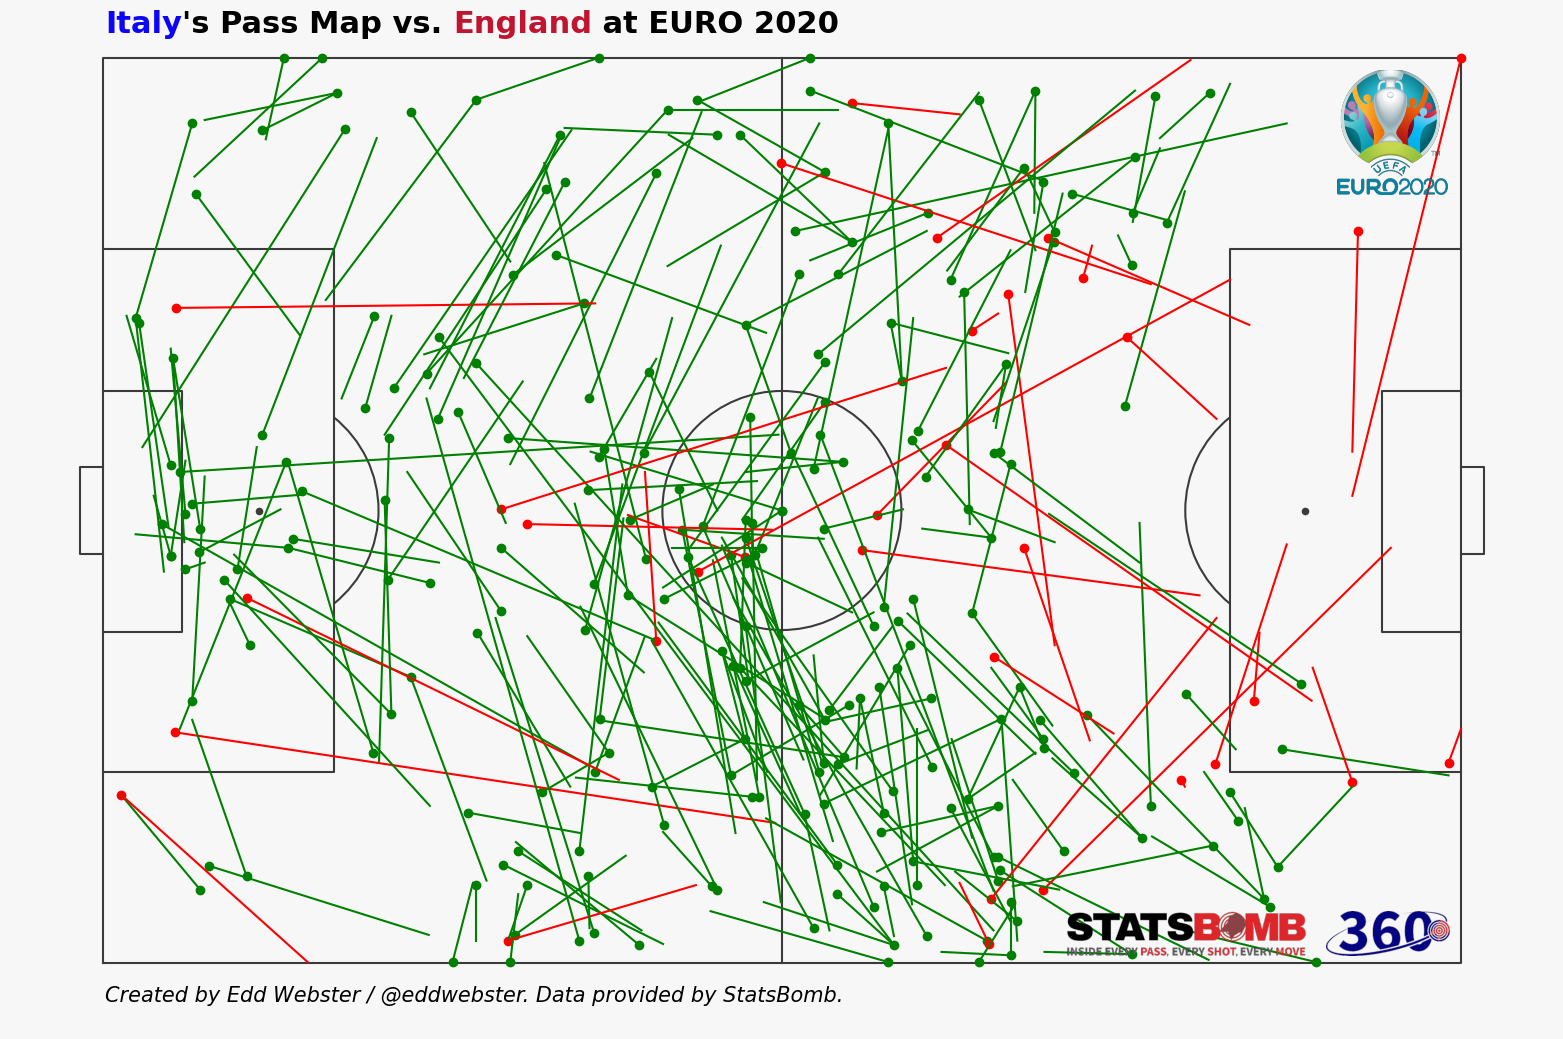

In [88]:
create_pass_map_team(df=df_events,
                     home_team='Italy',
                     away_team='England',
                     pass_map_team='Italy',
                     opponent='England',
                     pass_map_team_colour='#0c05fa',
                     opponent_colour='#c01430',
                     successful_pass_colour='green',
                     unsuccessful_pass_colour='red',
                     pitch_length_x=120,
                     pitch_length_y=80,
                     orientation='horizontal', #'vertical'
                     aspect='fll'
                    )

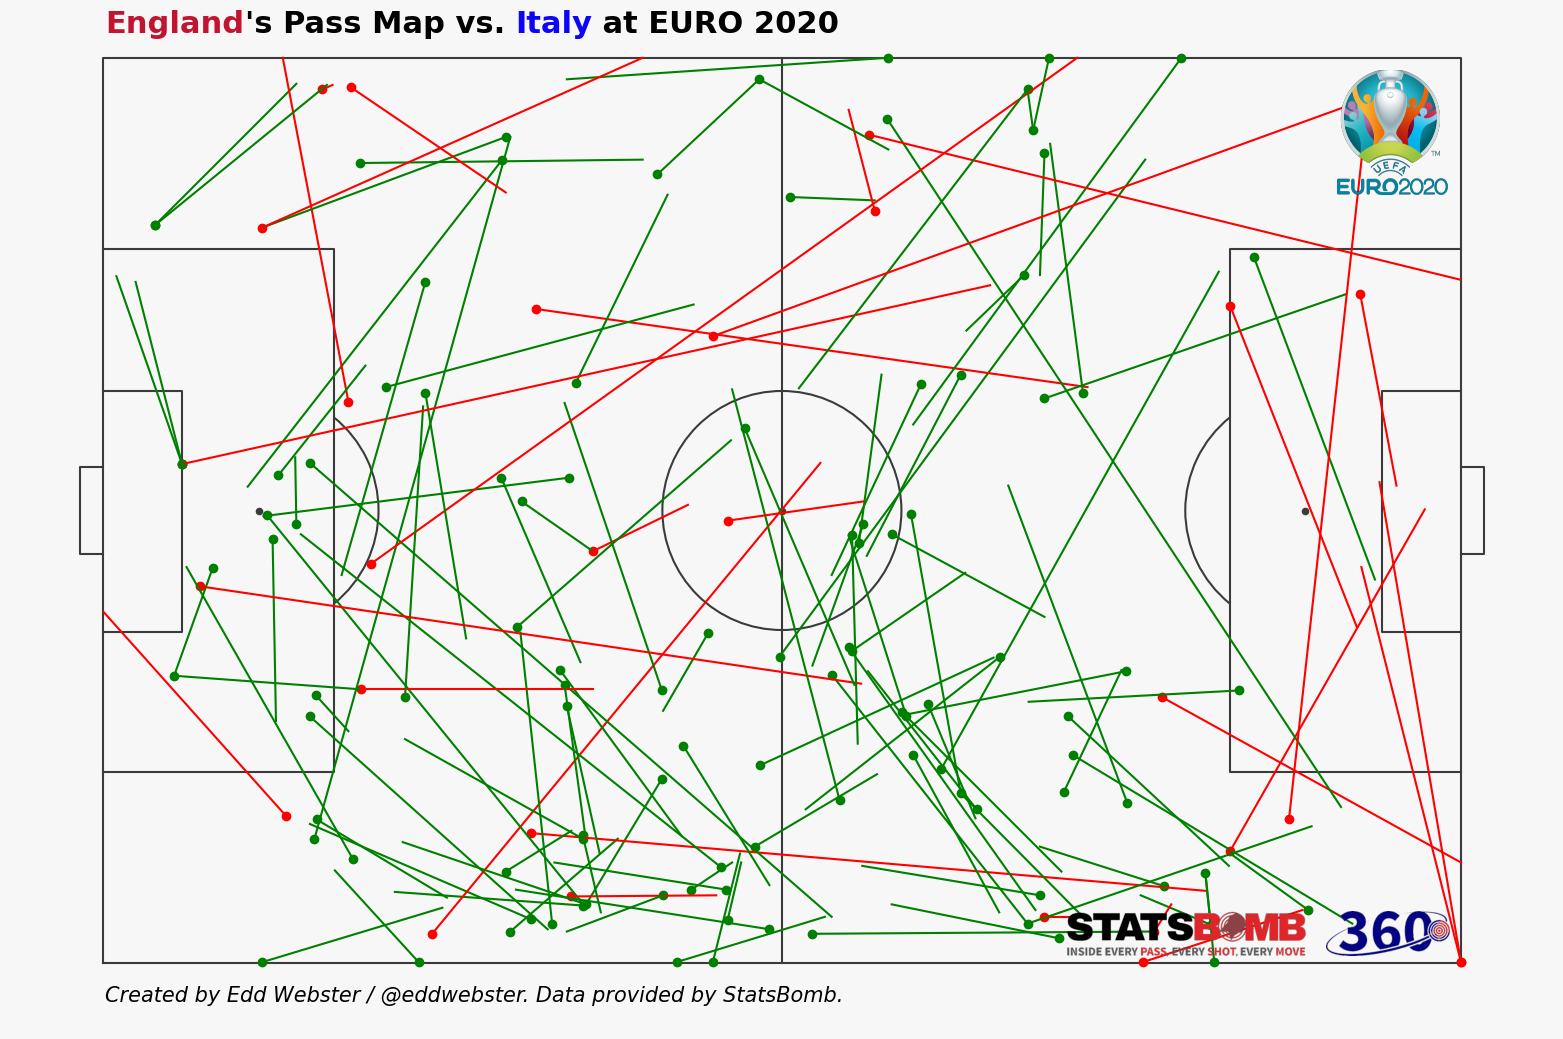

In [89]:
create_pass_map_team(df=df_events,
                     home_team='Italy',
                     away_team='England',
                     pass_map_team='England',
                     opponent='Italy',
                     pass_map_team_colour='#c01430',
                     opponent_colour='#0c05fa',
                     successful_pass_colour='green',
                     unsuccessful_pass_colour='red',
                     pitch_length_x=120,
                     pitch_length_y=80,
                     orientation='horizontal', #'vertical'
                     aspect='fll'
                    )

<a id='section4.08.2'></a>

#### <a id='#section4.08.2'>4.08.2. Single Player Pass Map</a>

In [90]:
## Define function for creating a pass map for a single player
def create_pass_map_single_player(df,
                                  home_team,
                                  away_team,
                                  pass_map_team,
                                  opponent,
                                  player_name,
                                  pass_map_team_colour,
                                  opponent_colour,
                                  successful_pass_colour,
                                  unsuccessful_pass_colour,
                                  pitch_length_x,
                                  pitch_length_y,
                                  orientation,
                                  aspect
                                 ):

    """
    Function for creating a pass map for a single player, utilising the 'create_passing_network' function, created by Peter McKeever @petermckeever.
    """
    
    ## Data Engineering
    
    ### Filter DataFrame for a single match and then only select team of interest
    df = df[(df['home_team_name'] == home_team) & (df['away_team_name'] == away_team)].reset_index(drop=True)
    df = df[(df['player_name'] == player_name)].reset_index(drop=True)
    df_passes = df[df['type_name']=='Pass']
 
    
    
    ## Visualisation
    
    ### Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    
    ### Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    #ax.patch.set_facecolor('w')

    
    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    
    ### Draw the pitch using the 
    pitch = draw_pitch(x_min=0,
                       x_max=pitch_length_x,
                       y_min=0,
                       y_max=pitch_length_y,
                       orientation=orientation,
                       aspect=aspect,
                       pitch_color=background,
                       line_color='#3B3B3B',
                       ax=ax
                      )
    
    
    ### Define Z order
    zo = 12

    
    ### use a for loop to plot each pass
    for i in range(len(df_passes['location_x'])):
        try:
            if pd.isnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='green')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=successful_pass_colour)
            if pd.notnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='red')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=unsuccessful_pass_colour)
        except:
            pass
   
    
    ### Add Plot Title
    s = '{}\'s Pass Map for <{}> vs. <{}> at EURO 2020\n'
    htext.fig_htext(s.format(player_name, pass_map_team, opponent), 0.09, 0.915, highlight_colors=[pass_map_team_colour, opponent_colour], highlight_weights=['bold'], string_weight='bold', fontsize=22, fontfamily=title_font, color=text_colour)


    ### Add Plot Subtitle
    #fig.text(0.04, 1.029, f'EURO 2020 {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)


    ### Add UEFA EURO 2020 logo
    ax2 = fig.add_axes([0.81, 0.80, 0.12, 0.12])
    ax2.axis('off')
    img = image.imread('../img/competitions/uefa_euro_2020.png')
    ax2.imshow(img)


    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.67, 0.02, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)


    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.83, 0.060, 0.075, 0.075])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)


    ### Footnote
    plt.figtext(0.09,
                0.010,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )

    
    ### Save figure
    if not os.path.exists(fig_dir + f'/pass_map_{player_name}_{home_team}_{away_team}_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/pass_map_{player_name}_{home_team}_{away_team}_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

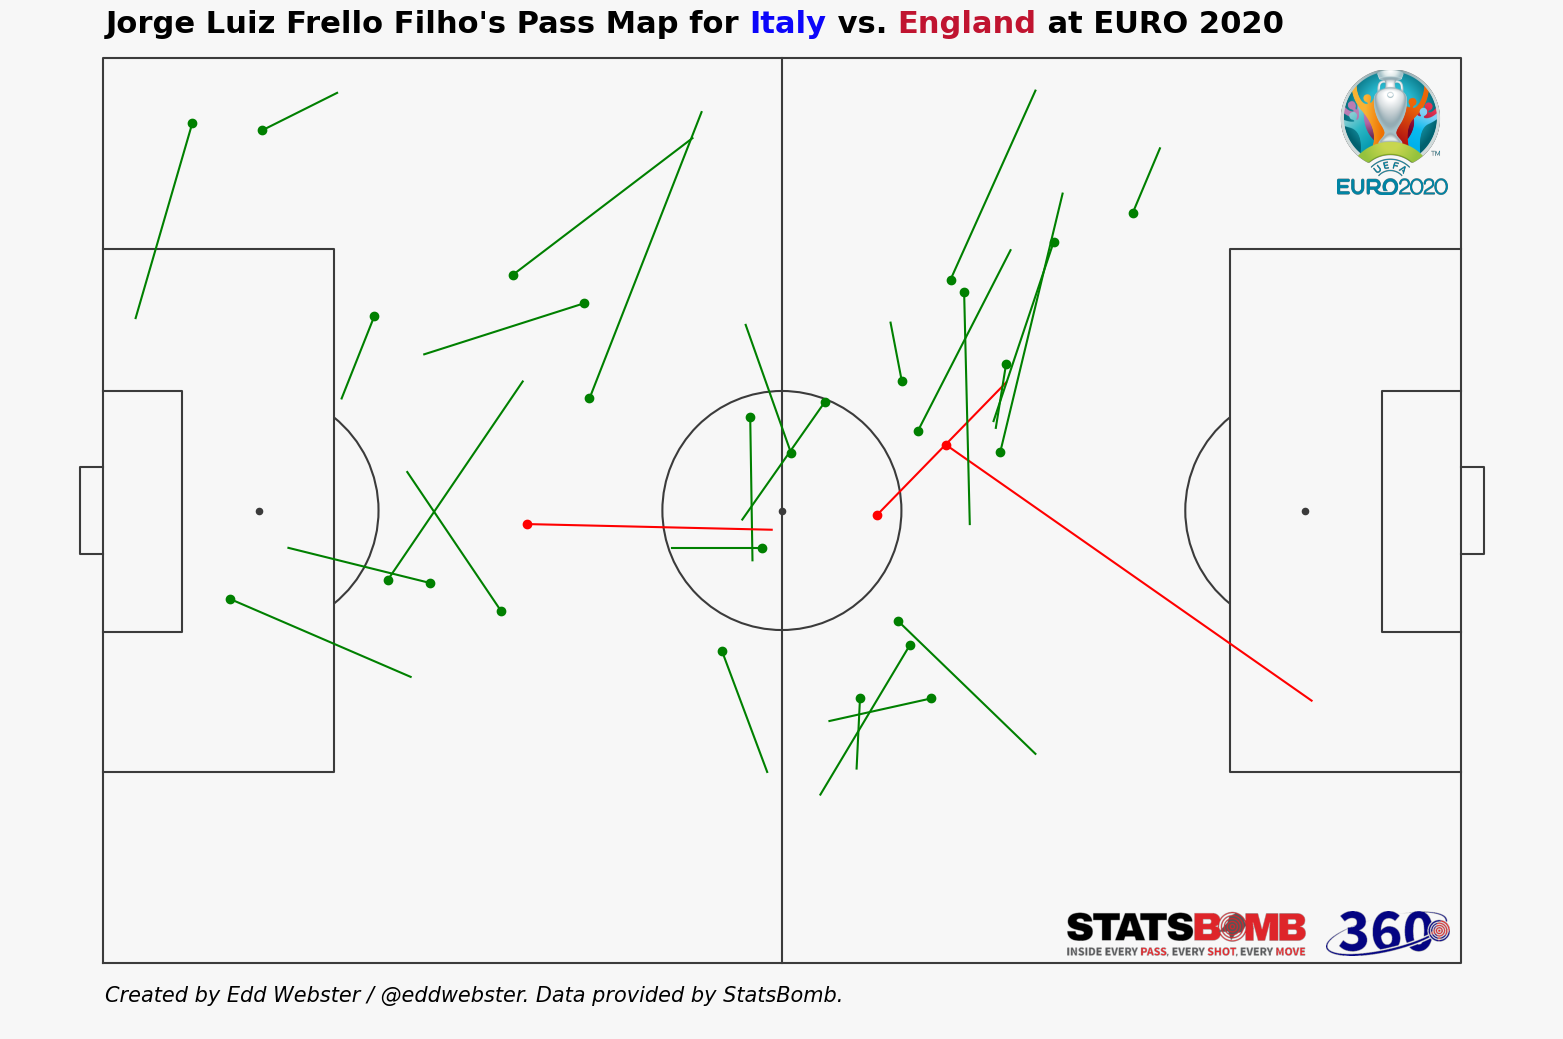

In [91]:
create_pass_map_single_player(df=df_events,
                              home_team='Italy',
                              away_team='England',
                              pass_map_team='Italy',
                              opponent='England',
                              player_name='Jorge Luiz Frello Filho',
                              pass_map_team_colour='#0c05fa',
                              opponent_colour='#c01430',
                              successful_pass_colour='green',
                              unsuccessful_pass_colour='red',
                              pitch_length_x=120,
                              pitch_length_y=80,
                              orientation='horizontal', #'vertical'
                              aspect='fll'
                             )

<a id='section4.08.3'></a>

#### <a id='#section4.08.3'>4.08.3. Multiple Player Pass Map</a>

In [92]:
## Define function for creating a pass map for multiple players
def create_pass_map_multiple_players(df,
                                     home_team,
                                     away_team,
                                     pass_map_team,
                                     opponent,
                                     player_names,
                                     pass_map_team_colour,
                                     opponent_colour,
                                     successful_pass_colour,
                                     unsuccessful_pass_colour,
                                     pitch_length_x,
                                     pitch_length_y,
                                     orientation,
                                     aspect,
                                     title
                                    ):
    
    """
    Function for creating a pass map for multiple players, utilising the 'create_passing_network' function, created by Peter McKeever @petermckeever.
    """
    
    ## Data Engineering
    
    ### Filter DataFrame for a single match and then only select team of interest
    df = df[(df['home_team_name'] == home_team) & (df['away_team_name'] == away_team)].reset_index(drop=True)
    df = df[df['player_name'].isin(player_names)].reset_index(drop=True)
    df_passes = df[df['type_name']=='Pass']
 
    
    
    ## Visualisation
    
    ### Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    
    ### Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    #ax.patch.set_facecolor('w')

    
    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    
    ### Draw the pitch using the 
    pitch = draw_pitch(x_min=0,
                       x_max=pitch_length_x,
                       y_min=0,
                       y_max=pitch_length_y,
                       orientation=orientation,
                       aspect=aspect,
                       pitch_color=background,
                       line_color='#3B3B3B',
                       ax=ax
                      )
    
    
    ### Define Z order
    zo = 12

    
    ### use a for loop to plot each pass
    for i in range(len(df_passes['location_x'])):
        try:
            if pd.isnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='green')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=successful_pass_colour)
            if pd.notnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='red')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=unsuccessful_pass_colour)
        except:
            pass
   
    
    ### Add Plot Title
    s = '{} Pass Map for <{}> vs. <{}> at EURO 2020\n'
    htext.fig_htext(s.format(title, pass_map_team, opponent), 0.09, 0.915, highlight_colors=[pass_map_team_colour, opponent_colour], highlight_weights=['bold'], string_weight='bold', fontsize=22, fontfamily=title_font, color=text_colour)


    ### Add Plot Subtitle
    #fig.text(0.04, 1.029, f'EURO 2020 {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)


    ### Add UEFA EURO 2020 logo
    ax2 = fig.add_axes([0.81, 0.80, 0.12, 0.12])
    ax2.axis('off')
    img = image.imread('../img/competitions/uefa_euro_2020.png')
    ax2.imshow(img)


    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.67, 0.02, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)


    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.83, 0.060, 0.075, 0.075])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)


    ### Footnote
    plt.figtext(0.09,
                0.010,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )

    
    ### Save figure
    if not os.path.exists(fig_dir + f'/pass_map_{title}_{home_team}_{away_team}_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/pass_map_{title}_{home_team}_{away_team}_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

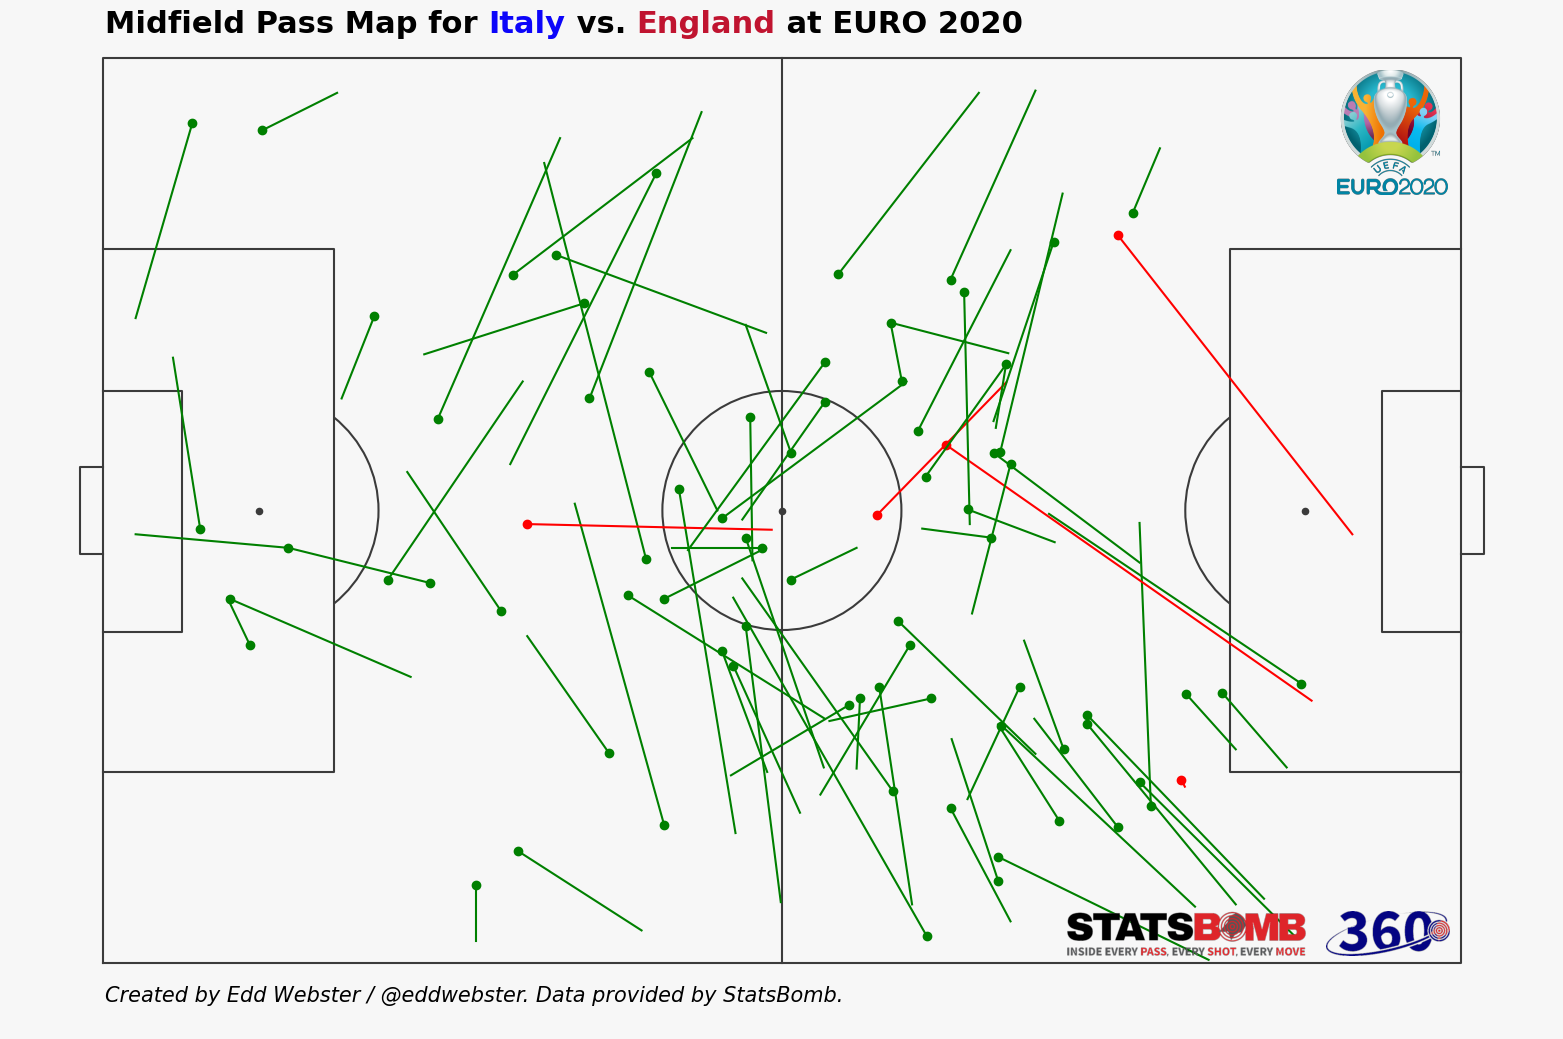

In [93]:
create_pass_map_multiple_players(df=df_events,
                                 home_team='Italy',
                                 away_team='England',
                                 pass_map_team='Italy',
                                 opponent='England',
                                 player_names=['Jorge Luiz Frello Filho', 'Marco Verratti', 'Bryan Cristante'],
                                 pass_map_team_colour='#0c05fa',
                                 opponent_colour='#c01430',
                                 successful_pass_colour='green',
                                 unsuccessful_pass_colour='red',
                                 pitch_length_x=120,
                                 pitch_length_y=80,
                                 orientation='horizontal', #'vertical'
                                 aspect='fll',
                                 title='Midfield'
                                )

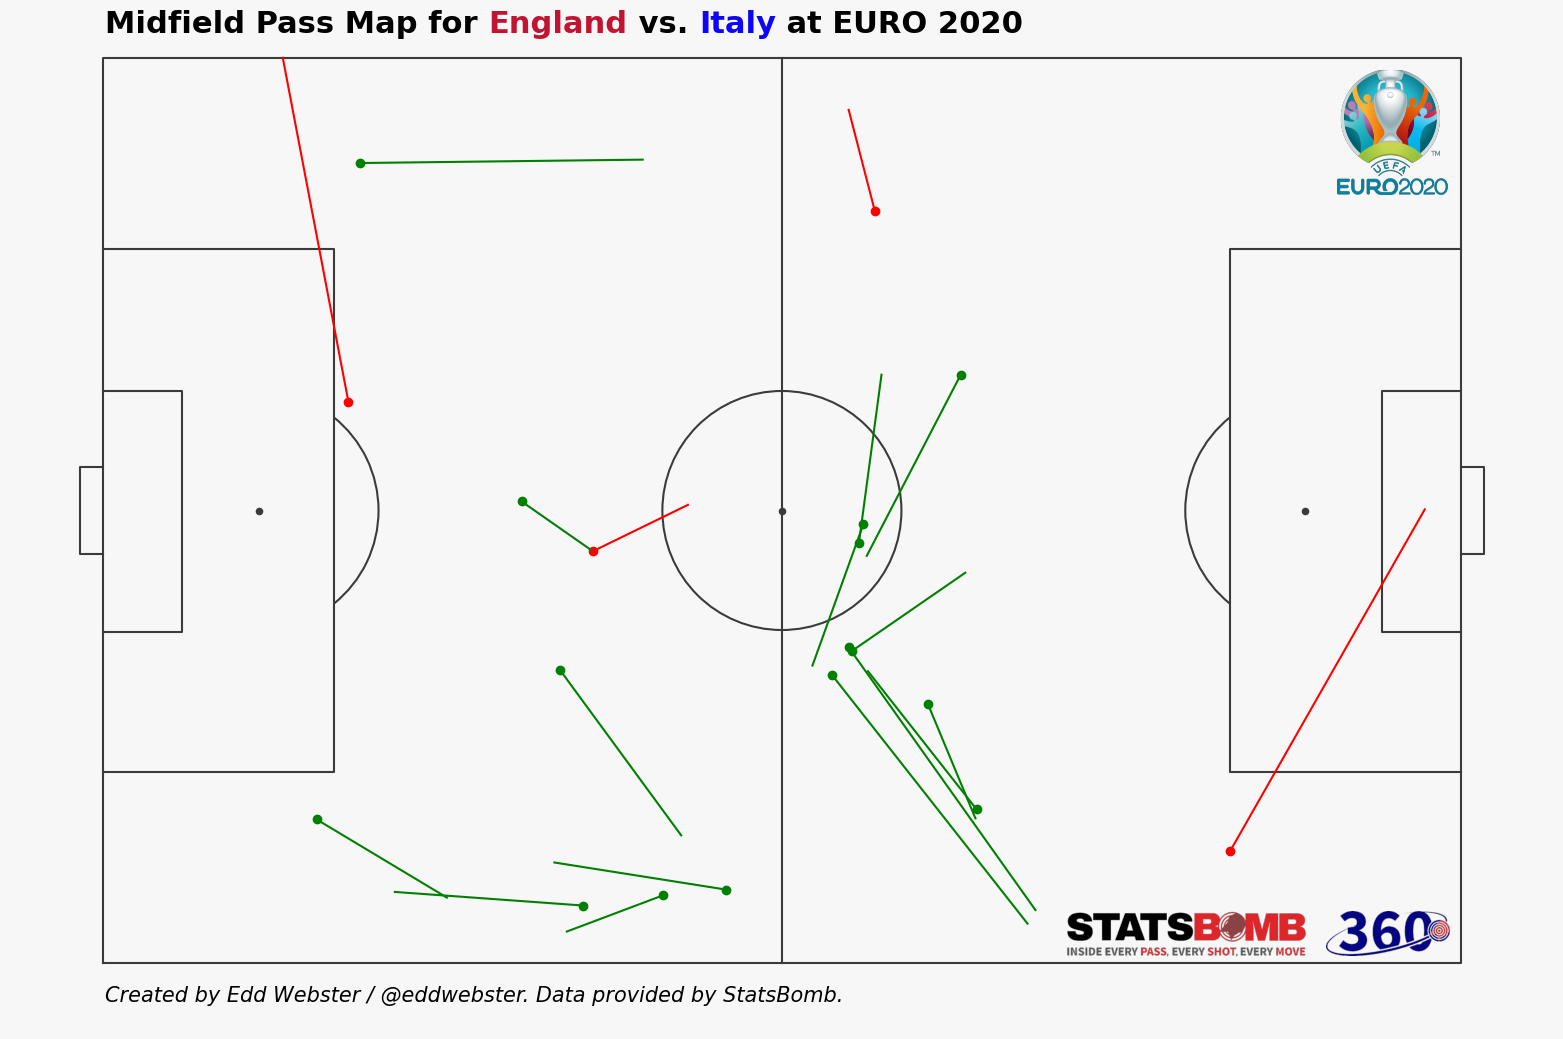

In [94]:
create_pass_map_multiple_players(df=df_events,
                                 home_team='Italy',
                                 away_team='England',
                                 pass_map_team='England',
                                 opponent='Italy',
                                 player_names=['Declan Rice', 'Kalvin Phillips', 'Mason Mount'],
                                 pass_map_team_colour='#c01430',
                                 opponent_colour='#0c05fa',
                                 successful_pass_colour='green',
                                 unsuccessful_pass_colour='red',
                                 pitch_length_x=120,
                                 pitch_length_y=80,
                                 orientation='horizontal', #'vertical'
                                 aspect='fll',
                                 title='Midfield'
                                )

<a id='section4.09'></a>

### <a id='#section4.09'>4.09. Heat Map</a>
Colour schemes for heat maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html

<a id='section4.09.1'></a>

#### <a id='#section4.09.1'>4.09.1. Team Heat Map</a>

In [95]:
## Define function for creating a heat map of touches by a team
def create_heat_map_team(df, home_team, away_team, heat_map_team, pitch_length_x, pitch_length_y, orientation, aspect, gradient, n_levels):
    
    """
    Function to create a heat map of touches by a team, utilising the 'create_passing_network' function, created by Peter McKeever @petermckeever.
    """
    
    ## Data Engineering
    
    ### Filter DataFrame for a single match and then only select team of interest
    df = df[(df['home_team_name'] == home_team) & (df['away_team_name'] == away_team)].reset_index(drop=True)
    df = df[(df['team_name'] == heat_map_team)].reset_index(drop=True)

    
    
    ## Visualisation
    
    ### Define fonts and colours
    #title_font = 'Alegreya Sans'
    #main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    
    ### Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    #ax.patch.set_facecolor('w')

    
    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    
    ### Draw the pitch using the 
    pitch = draw_pitch(x_min=0,
                       x_max=pitch_length_x,
                       y_min=0,
                       y_max=pitch_length_y,
                       orientation=orientation,
                       aspect=aspect,
                       pitch_color=background,
                       line_color='#3B3B3B',
                       ax=ax
                      )
    
    
    ### Create the heatmap
    kde = sns.kdeplot(df['location_x'],
                      df['location_y'],
                      shade = True,
                      shade_lowest=False,
                      alpha=.5,
                      n_levels=n_levels,
                      cmap=gradient
                     )

    ### Define Z order
    zo = 12
  
    
    ### X and Y limits
    plt.xlim(0-5, pitch_length_x+5)
    plt.ylim(0-5, pitch_length_y+5)
    
    
    """
    ### Add Plot Title
    ax.set_title(f'Pass Map for {home_team} vs. {away_team} at EURO 2020',
                 loc='left',
                 fontsize=20,
                 fontweight='bold', 
                 color=text_colour
                )
    """
    
    
    ### Title v2
    plt.figtext(0.055,
                0.96,
                f'Heat Map for {home_team} vs. {away_team} at EURO 2020',
                fontsize=25,
                fontweight='bold', 
                color=text_colour
               )
    
    
    ### Footnote
    plt.figtext(0.055,
                -0.001,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                ha="left",
                fontsize=15
               )

    
    ### Save figure
    if not os.path.exists(fig_dir + f'/heat_map_{home_team}_{away_team}_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/heat_map_{home_team}_{away_team}_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


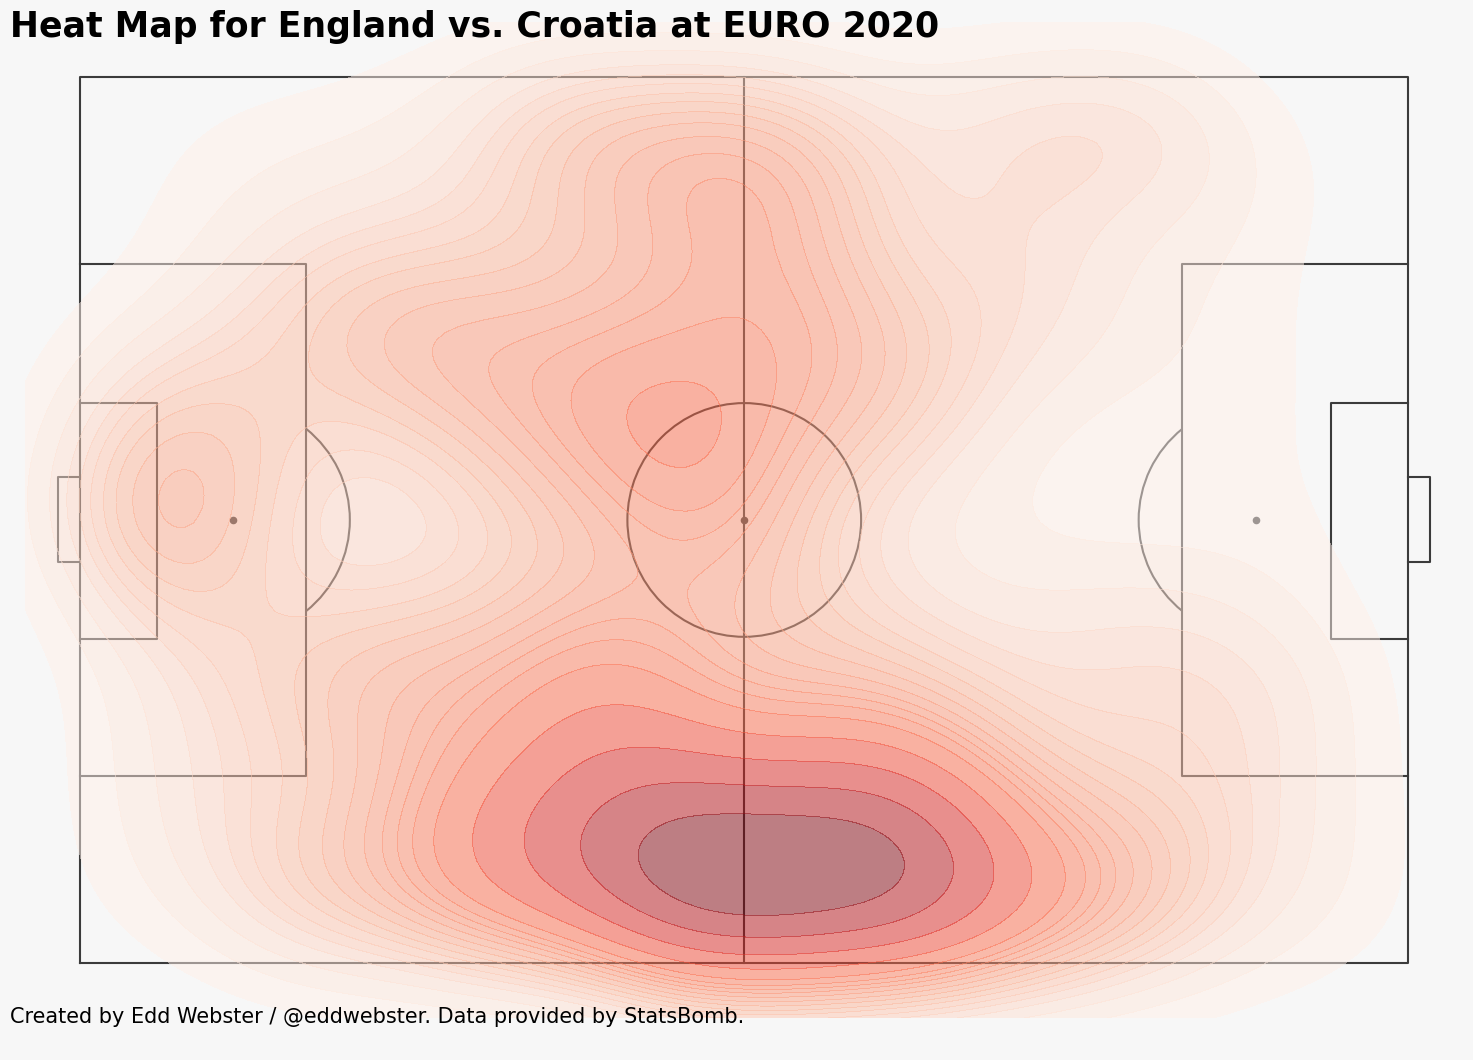

In [96]:
create_heat_map_team(df=df_events,
                     home_team='England',
                     away_team='Croatia',
                     heat_map_team='England',
                     pitch_length_x=120,
                     pitch_length_y=80,
                     orientation='horizontal', #'vertical'
                     aspect='fll',
                     gradient='Reds',
                     n_levels=20
                    )

<a id='section4.09.2'></a>

#### <a id='#section4.09.2'>4.09.2. Player Heat Map</a>

In [97]:
## Define function for creating a heat map of touches by a player
def create_heat_map_player(df, home_team, away_team, player_name, successful_pass_colour, unsuccessful_pass_colour, pitch_length_x, pitch_length_y, orientation, aspect, gradient, n_levels):
    
    """
    Function to create a heat map of touches by a player, utilising the 'create_passing_network' function, created by Peter McKeever @petermckeever.
    """
    
    ## Data Engineering
    
    ### Filter DataFrame for a single match and then only select team of interest
    df = df[(df['home_team_name'] == home_team) & (df['away_team_name'] == away_team)].reset_index(drop=True)
    df = df[(df['player_name'] == player_name)].reset_index(drop=True)
    df_passes = df[df['type_name']=='Pass']
 
    
    
    ## Visualisation
    
    ### Define fonts and colours
    #title_font = 'Alegreya Sans'
    #main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    
    ### Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    #ax.patch.set_facecolor('w')

    
    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    
    ### Draw the pitch using the 
    pitch = draw_pitch(x_min=0,
                       x_max=pitch_length_x,
                       y_min=0,
                       y_max=pitch_length_y,
                       orientation=orientation,
                       aspect=aspect,
                       pitch_color=background,
                       line_color='#3B3B3B',
                       ax=ax
                      )
    
    
    ### Create the heatmap
    kde = sns.kdeplot(
            df_passes['location_x'],
            df_passes['location_y'],
            shade = True,
            shade_lowest=False,
            alpha=.5,
            n_levels=n_levels,
            cmap=gradient
    )
    
    
    ### Define Z order
    zo = 12

    
    ### use a for loop to plot each pass
    for i in range(len(df_passes['location_x'])):
        try:
            if pd.isnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='green')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=successful_pass_colour)
            if pd.notnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='red')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=unsuccessful_pass_colour)
        except:
            pass
   

    ### X and Y limits
    plt.xlim(0-5, pitch_length_x+5)
    plt.ylim(0-5, pitch_length_y+5)

    """
    ### Add Plot Title
    ax.set_title(f'{player_name} Heat Map for {home_team} vs. {away_team} at EURO 2020',
                 loc='left',
                 fontsize=20,
                 fontweight='bold', 
                 color=text_colour
                )
    """
    
    
    ### Title v2
    plt.figtext(0.055,
                0.96,
                f'{player_name} Heat Map for {home_team} vs. {away_team} at EURO 2020',
                fontsize=25,
                fontweight='bold', 
                color=text_colour
               )
    
    
    ### Footnote
    plt.figtext(0.055,
                -0.001,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                ha="left",
                fontsize=15
               )

    
    ### Save figure
    if not os.path.exists(fig_dir + f'/heat_map_{player_name}_{home_team}_{away_team}_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/heat_map_{player_name}_{home_team}_{away_team}_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


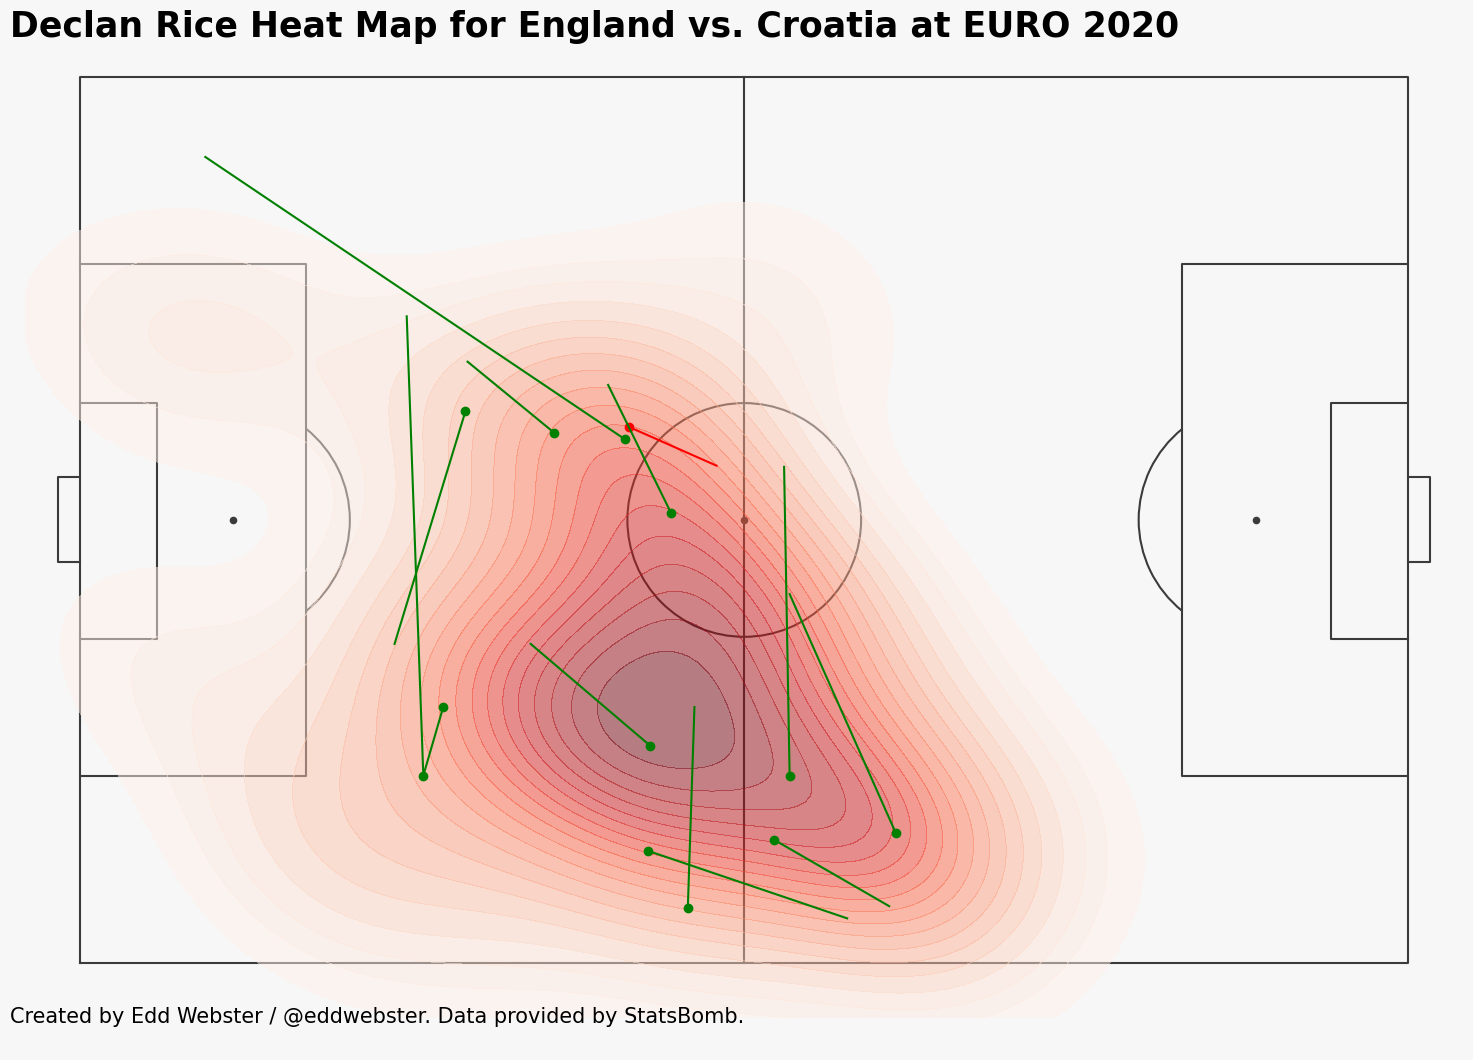

In [98]:
create_heat_map_player(df=df_events,
                       home_team='England',
                       away_team='Croatia',
                       player_name='Declan Rice',
                       successful_pass_colour='green',
                       unsuccessful_pass_colour='red',
                       pitch_length_x=120,
                       pitch_length_y=80,
                       orientation='horizontal', #'vertical'
                       aspect='fll',
                       gradient='Reds',
                       n_levels=20
                      )

<a id='section4.10'></a>

### <a id='#section4.10'>4.10. Combined Heat and Pass Map</a>
Colour schemes for heat maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html

<a id='section4.10.1'></a>

#### <a id='#section4.10.1'>4.10.1. Team Heat and Pass Map</a>

In [99]:
## Define function for creating a combined heat and pass map of touches by a team
def create_heat_and_pass_map_team(df, home_team, away_team, heat_map_team, successful_pass_colour, unsuccessful_pass_colour, pitch_length_x, pitch_length_y, orientation, aspect, gradient, n_levels):
    
    """
    Function to create a a combined heat and pass map of touches by a team, utilising the 'create_passing_network' function, created by Peter McKeever @petermckeever.
    """
    
    ## Data Engineering
    
    ### Filter DataFrame for a single match and then only select team of interest
    df = df[(df['home_team_name'] == home_team) & (df['away_team_name'] == away_team)].reset_index(drop=True)
    df = df[(df['team_name'] == heat_map_team)].reset_index(drop=True)
    df_passes = df[df['type_name']=='Pass']
 
    
    
    ## Visualisation
    
    ### Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    
    ### Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    #ax.patch.set_facecolor('w')

    
    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    
    ### Draw the pitch using the 
    pitch = draw_pitch(x_min=0,
                       x_max=pitch_length_x,
                       y_min=0,
                       y_max=pitch_length_y,
                       orientation=orientation,
                       aspect=aspect,
                       pitch_color=background,
                       line_color='#3B3B3B',
                       ax=ax
                      )
    
    
    ### Create the heatmap
    kde = sns.kdeplot(df_passes['location_x'],
                      df_passes['location_y'],
                      shade = True,
                      shade_lowest=False,
                      alpha=.5,
                      n_levels=n_levels,
                      cmap=gradient
                     )

    ### Define Z order
    zo = 12

    
    ### use a for loop to plot each pass
    for i in range(len(df_passes['location_x'])):
        try:
            if pd.isnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='green')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=successful_pass_colour)
            if pd.notnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='red')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=unsuccessful_pass_colour)
        except:
            pass
   
    
    ### X and Y limits
    plt.xlim(0-5, pitch_length_x+5)
    plt.ylim(0-5, pitch_length_y+5)
    
    
    """
    ### Add Plot Title
    ax.set_title(f'Pass Map for {home_team} vs. {away_team} at EURO 2020',
                 loc='left',
                 fontsize=20,
                 fontweight='bold', 
                 color=text_colour
                )
    """
    
    
    ### Title v2
    plt.figtext(0.055,
                0.96,
                f'Combined Pass and Heat Map for {home_team} vs. {away_team} at EURO 2020',
                fontsize=25,
                fontweight='bold', 
                color=text_colour
               )
    
    
    ### Footnote
    plt.figtext(0.055,
                -0.001,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                ha="left",
                fontsize=15
               )

    
    ### Save figure
    if not os.path.exists(fig_dir + f'/heat_map_{home_team}_{away_team}_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/heat_map_{home_team}_{away_team}_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


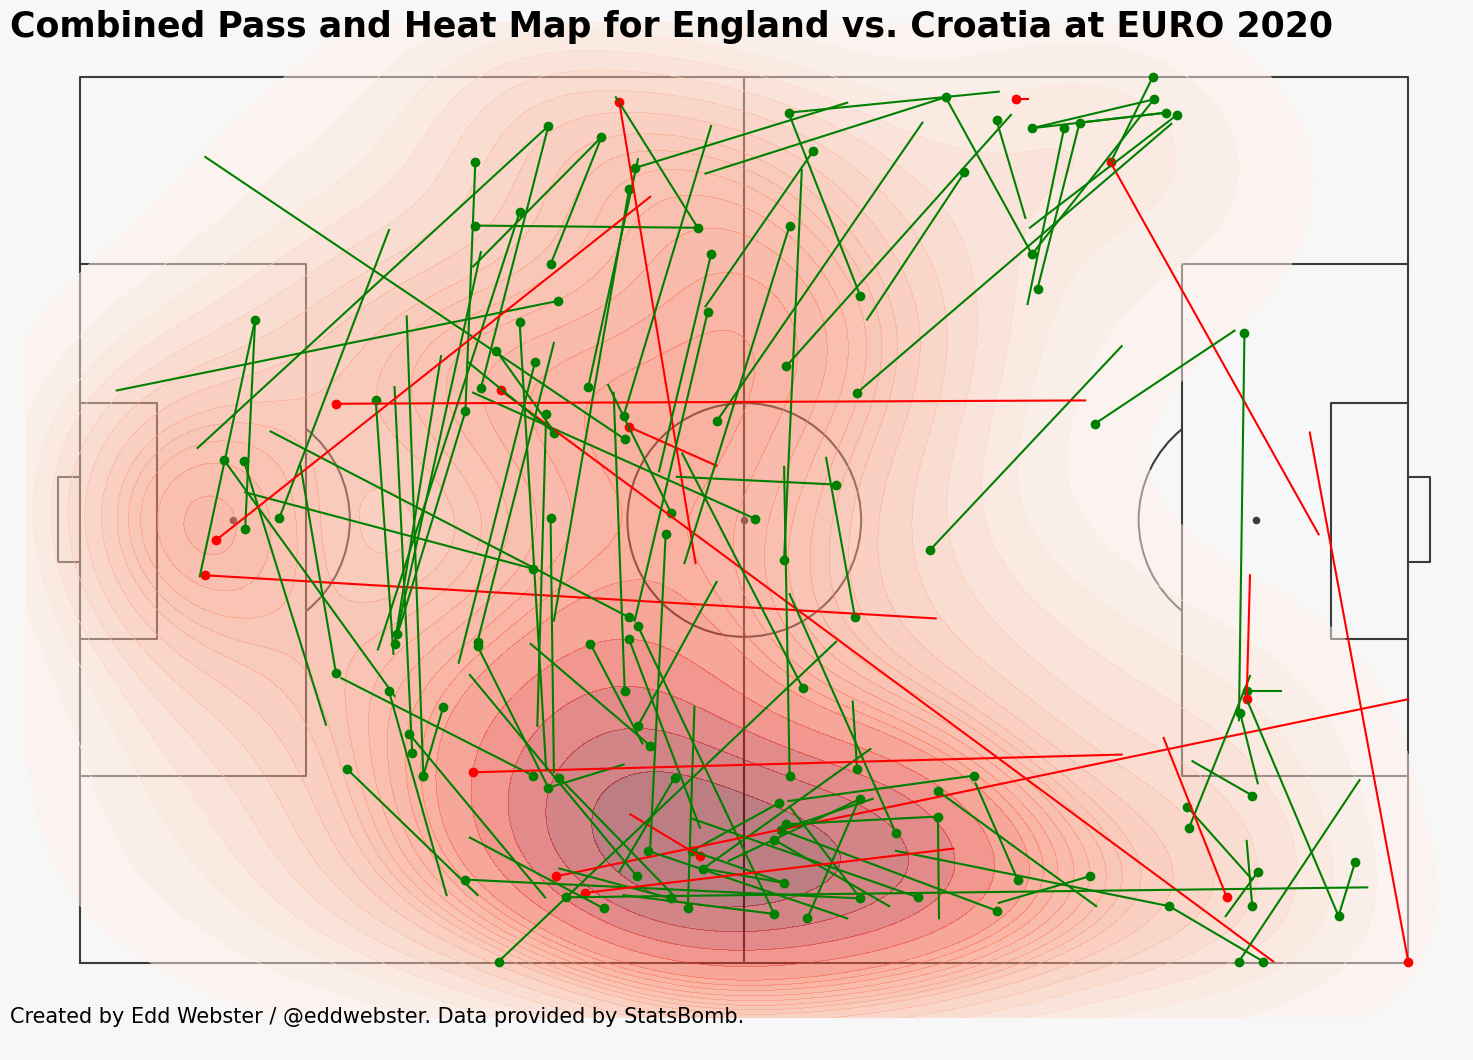

In [100]:
create_heat_and_pass_map_team(df=df_events,
                              home_team='England',
                              away_team='Croatia',
                              heat_map_team='England',
                              successful_pass_colour='green',
                              unsuccessful_pass_colour='red',
                              pitch_length_x=120,
                              pitch_length_y=80,
                              orientation='horizontal', #'vertical'
                              aspect='fll',
                              gradient='Reds',
                              n_levels=20
                             )

<a id='section4.10.2'></a>

#### <a id='#section4.10.2'>4.10.2. Player Heat Map</a>

In [101]:
## Define function for creating a combined heat and pass map for a single player
def create_heat_and_pass_map_player(df,
                                    home_team,
                                    away_team,
                                    passing_network_team,
                                    opponent,
                                    player_name,
                                    pass_heat_map_team_colour,
                                    opponent_colour,
                                    successful_pass_colour,
                                    unsuccessful_pass_colour,
                                    pitch_length_x,
                                    pitch_length_y,
                                    orientation,
                                    aspect,
                                    gradient,
                                    n_levels
                                   ):
    
    """
    Function to create a combined heat and pass map of touches by a player, utilising the 'create_passing_network' function, created by Peter McKeever @petermckeever.
    """
    
    ## Data Engineering
    
    ### Filter DataFrame for a single match and then only select team of interest
    df = df[(df['home_team_name'] == home_team) & (df['away_team_name'] == away_team)].reset_index(drop=True)
    df = df[(df['player_name'] == player_name)].reset_index(drop=True)
    df_passes = df[df['type_name']=='Pass']
 
    
    
    ## Visualisation
    
    ### Define fonts and colours
    #title_font = 'Alegreya Sans'
    #main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    
    ### Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    #ax.patch.set_facecolor('w')

    
    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    
    ### Draw the pitch using the 
    pitch = draw_pitch(x_min=0,
                       x_max=pitch_length_x,
                       y_min=0,
                       y_max=pitch_length_y,
                       orientation=orientation,
                       aspect=aspect,
                       pitch_color=background,
                       line_color='#3B3B3B',
                       ax=ax
                      )
    
    
    ### Define Z order
    zo = 12

    ### Create the heatmap
    kde = sns.kdeplot(
            df_passes['location_x'],
            df_passes['location_y'],
            shade = True,
            shade_lowest=False,
            alpha=.5,
            n_levels=n_levels,
            cmap=gradient
    )
    
    ### use a for loop to plot each pass
    for i in range(len(df_passes['location_x'])):
        try:
            if pd.isnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='green')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=successful_pass_colour)
            if pd.notnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_x'][i], df_passes['pass_end_location_x'][i]), (df_passes['location_y'][i], df_passes['pass_end_location_y'][i]), color='red')
                plt.scatter(df_passes['location_x'][i], df_passes['location_y'][i], color=unsuccessful_pass_colour)
        except:
            pass
   
    
    ### Add Plot Title
    s = '{}\'s Pass Map for <{}> vs. <{}> at EURO 2020\n'
    htext.fig_htext(s.format(player_name, passing_network_team, opponent), 0.09, 0.915, highlight_colors=[pass_heat_map_team_colour, opponent_colour], highlight_weights=['bold'], string_weight='bold', fontsize=22, fontfamily=title_font, color=text_colour)


    ### Add Plot Subtitle
    #fig.text(0.04, 1.029, f'EURO 2020 {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)


    ### Add UEFA EURO 2020 logo
    ax2 = fig.add_axes([0.81, 0.80, 0.12, 0.12])
    ax2.axis('off')
    img = image.imread('../img/competitions/uefa_euro_2020.png')
    ax2.imshow(img)


    ### Add StatsBomb logo
    ax3 = fig.add_axes([0.67, 0.02, 0.15, 0.15])
    ax3.axis('off')
    img = image.imread('../img/logos/stats-bomb-logo.png')
    ax3.imshow(img)


    ### Add StatsBomb 360 logo
    ax4 = fig.add_axes([0.83, 0.060, 0.075, 0.075])
    ax4.axis('off')
    img = image.imread('../img/logos/stats-bomb-360-logo.png')
    ax4.imshow(img)


    ### Footnote
    plt.figtext(0.09,
                0.010,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                fontstyle='italic',
                fontsize=15, 
                fontfamily=main_font,
                color=text_colour
               )

    
    ### Save figure
    if not os.path.exists(fig_dir + f'/combined_heat_and_pass_map_{player_name}_{home_team}_{away_team}_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/combined_heat_and_pass_map_{player_name}_{home_team}_{away_team}_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


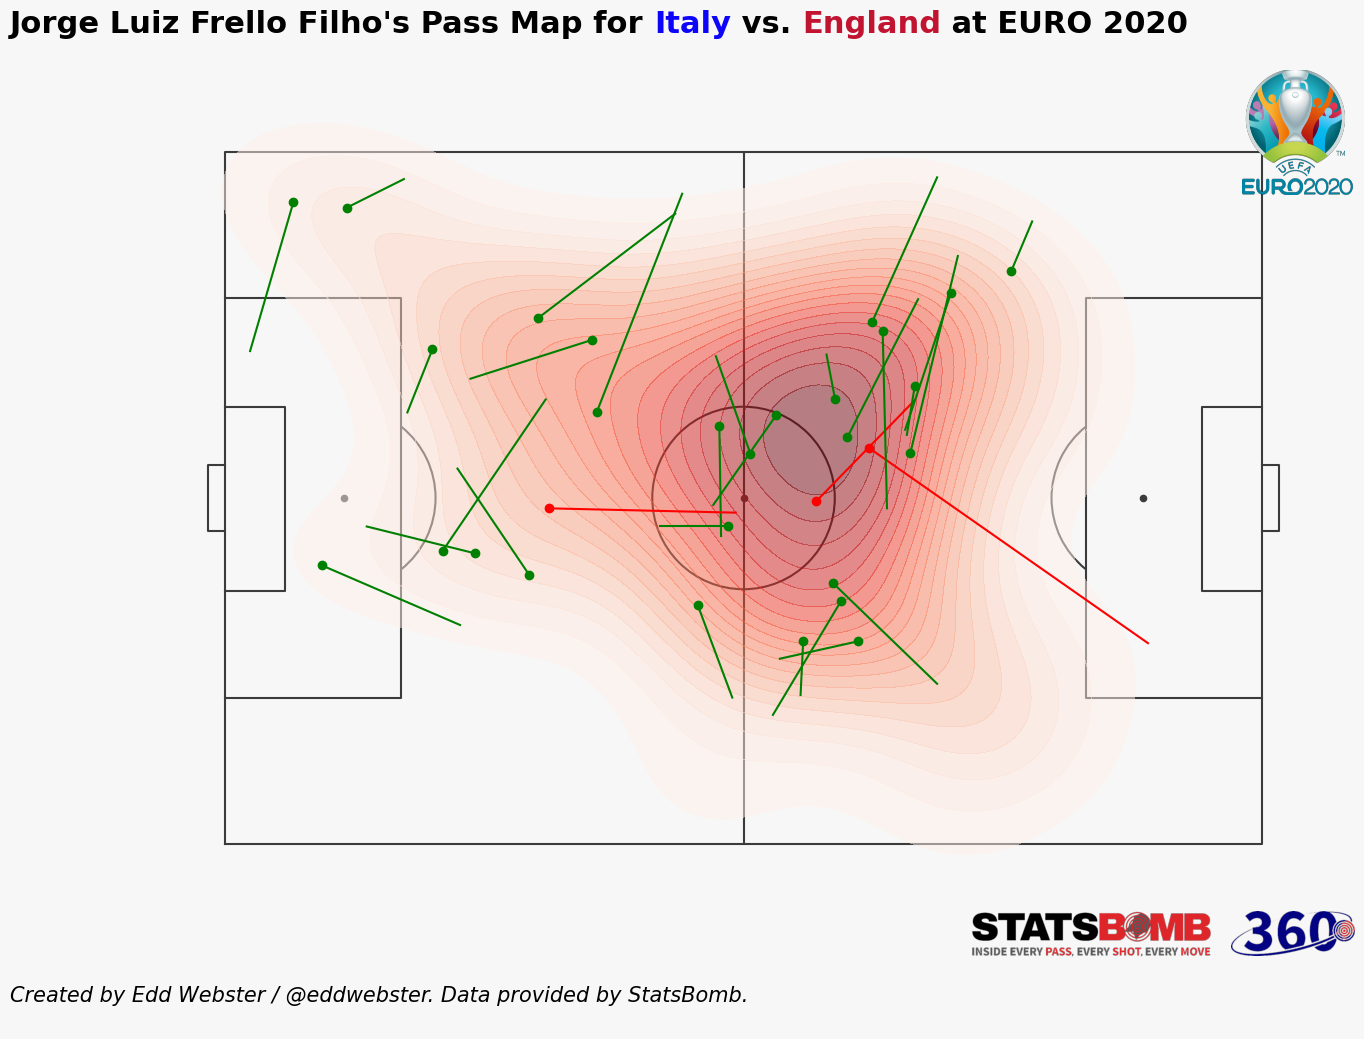

In [102]:
create_heat_and_pass_map_player(df=df_events,
                                home_team='Italy',
                                away_team='England',
                                passing_network_team='Italy',
                                opponent='England',
                                player_name='Jorge Luiz Frello Filho',
                                pass_heat_map_team_colour='#0c05fa',
                                opponent_colour='#c01430',
                                successful_pass_colour='green',
                                unsuccessful_pass_colour='red',
                                pitch_length_x=120,
                                pitch_length_y=80,
                                orientation='horizontal', #'vertical'
                                aspect='fll',
                                gradient='Reds',
                                n_levels=20
                               )

<a id='section4.11'></a>

### <a id='#section4.11'>4.11. OBV Maps</a>

<a id='section4.11.1'></a>

#### <a id='#section4.11.1'>4.11.1. Highest OBV Carries</a>

In [127]:
# Define function for creating map of highest OBV value carries for a single player
def create_obv_carries_player(df,
                              player_name,
                              team_colour,
                              successful_carry_colour,
                              unsuccessful_carry_colour,
                              pitch_length_x,
                              pitch_length_y,
                              orientation,
                              aspect,
                              n_carries
                             ):
    
    """
    Function to create a carry map of highest OBV value, utilising the 'create_passing_network' function, created by Peter McKeever @petermckeever.
    """
    
    ## Data Engineering
    
    ### Filter DataFrame for a single match and then only select team of interest
    df = df[(df['player_name'] == player_name)].reset_index(drop=True)
    df_carries = df[df['type_name']=='Carry']

    ### Sort DataFrame 
    df_carries = df_carries.sort_values(['obv_total_net'], ascending=[False])

    ### Filter for the top N carries
    df_carries = df_carries.nlargest(20, 'obv_total_net')

    ### Reset Index
    df_carries = df_carries.reset_index(drop=True)
 
    
    
    ## Visualisation
    
    ### Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    
    ### Create figure 
    fig, ax = plt.subplots(figsize=(8.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    #ax.patch.set_facecolor('w')

    
    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    
    ### Draw the pitch using the 
    pitch = draw_pitch(x_min=0,
                       x_max=pitch_length_x,
                       y_min=0,
                       y_max=pitch_length_y,
                       orientation=orientation,
                       aspect=aspect,
                       pitch_color=background,
                       line_color='#3B3B3B',
                       ax=ax
                      )
    
    
    ### Define Z order
    zo = 12


    ### use a for loop to plot each pass
    for i in range(len(df_carries['location_x'])):
        try:
            if pd.isnull(df_carries['dribble_outcome_name'][i]):
                plt.plot((df_carries['location_y'][i], df_carries['endloc_y'][i]), (df_carries['location_x'][i], df_carries['endloc_x'][i]), color='green')
                plt.scatter(df_carries['location_y'][i], df_carries['location_x'][i], color=successful_carry_colour)
            if pd.notnull(df_carries['dribble_outcome_name'][i]):
                plt.plot((df_carries['location_y'][i], df_carries['endloc_y'][i]), (df_carries['location_x'][i], df_carries['endloc_x'][i]), color='red')
                plt.scatter(df_carries['location_y'][i], df_carries['location_x'][i], color=unsuccessful_carry_colour)
        except:
            pass
   
    
    ### Invert the Y axis - attacking from bottom to top
    ax.invert_yaxis()
    
    ### Add Plot Title
    s = '<{}>\'s Most Valuable Dribbles By OBV at EURO 2020\n'
    htext.fig_htext(s.format(player_name), 0.09, 0.915, highlight_colors=[team_colour], highlight_weights=['bold'], string_weight='bold', fontsize=15, fontfamily=title_font, color=text_colour)


    ### Add Plot Subtitle
    #fig.text(0.04, 1.029, f'EURO 2020 {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)


    ### Add UEFA EURO 2020 logo
    #ax2 = fig.add_axes([0.81, 0.80, 0.12, 0.12])
    #ax2.axis('off')
    #img = image.imread('../img/competitions/uefa_euro_2020.png')
    #ax2.imshow(img)


    ### Add StatsBomb logo
    #ax3 = fig.add_axes([0.67, 0.02, 0.15, 0.15])
    #ax3.axis('off')
    #img = image.imread('../img/logos/stats-bomb-logo.png')
    #ax3.imshow(img)


    ### Add StatsBomb 360 logo
    #ax4 = fig.add_axes([0.83, 0.060, 0.075, 0.075])
    #ax4.axis('off')
    #img = image.imread('../img/logos/stats-bomb-360-logo.png')
    #ax4.imshow(img)


    ### Footnote
    plt.figtext(0.09,
                0.010,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                fontstyle='italic',
                fontsize=11, 
                fontfamily=main_font,
                color=text_colour
               )

    
    ### Save figure
    if not os.path.exists(fig_dir + f'/{n_carries}_valuable_carries_{player_name}_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/{n_carries}_valuable_carries_{player_name}_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

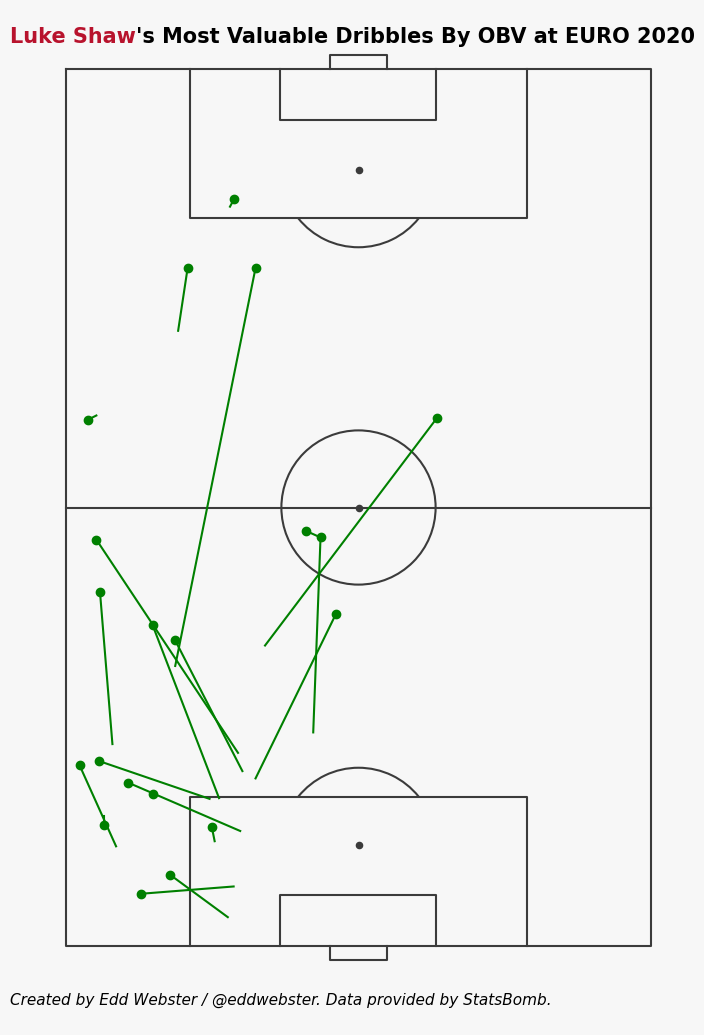

In [128]:
create_obv_carries_player(df=df_events,
                          player_name='Luke Shaw',
                          team_colour='#b8132d',
                          successful_carry_colour='green',
                          unsuccessful_carry_colour='red',
                          pitch_length_x=120,
                          pitch_length_y=80,
                          orientation='vertical', #'horizontal', #'vertical'
                          aspect='fll',
                          n_carries=20
                         )

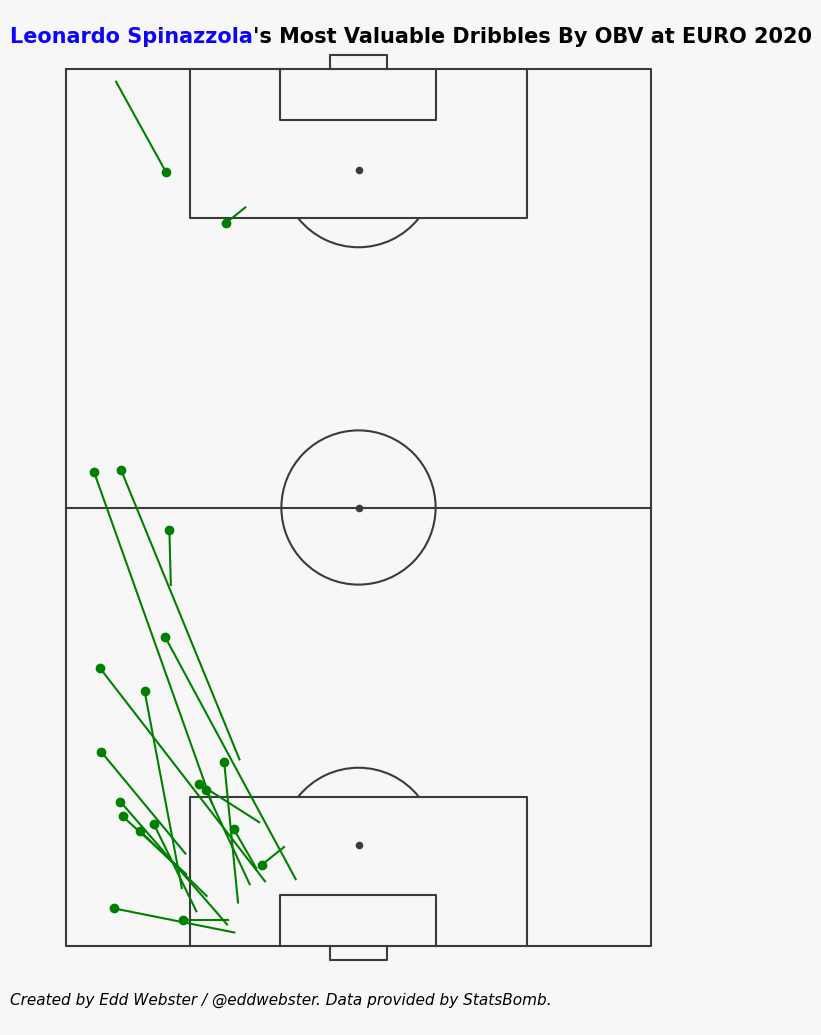

In [129]:
create_obv_carries_player(df=df_events,
                          player_name='Leonardo Spinazzola',
                          team_colour='#0c05fa',
                          successful_carry_colour='green',
                          unsuccessful_carry_colour='red',
                          pitch_length_x=120,
                          pitch_length_y=80,
                          orientation='vertical', #'horizontal', #'vertical'
                          aspect='fll',
                          n_carries=20
                         )

<a id='section4.11.2'></a>

#### <a id='#section4.11.2'>4.11.2. Passes</a>

In [122]:
# Define function for creating map of highest OBV value carries for a single player
def create_obv_passes_player(df,
                             player_name,
                             team_colour,
                             successful_pass_colour,
                             unsuccessful_pass_colour,
                             pitch_length_x,
                             pitch_length_y,
                             orientation,
                             aspect,
                             n_passes
                            ):
    
    """
    Function to create a pass map of highest OBV value, utilising the 'create_passing_network' function, created by Peter McKeever @petermckeever.
    """
    
    ## Data Engineering
    
    ### Filter DataFrame for a single match and then only select team of interest
    df = df[(df['player_name'] == player_name)].reset_index(drop=True)
    df_passes = df[df['type_name']=='Pass']

    ### Sort DataFrame 
    df_passes = df_passes.sort_values(['obv_total_net'], ascending=[False])

    ### Filter for the top N passes
    df_passes = df_passes.nlargest(20, 'obv_total_net')

    ### Reset Index
    df_passes = df_passes.reset_index(drop=True)
 
    
    
    ## Visualisation
    
    ### Define fonts and colours
    title_font = 'Alegreya Sans'
    main_font = 'Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    
    ### Create figure 
    fig, ax = plt.subplots(figsize=(8.5, 10.5))
    fig.set_facecolor(background)
    ax.patch.set_facecolor(background)
    #ax.patch.set_facecolor('w')

    
    ### Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)

    
    ### Draw the pitch using the 
    pitch = draw_pitch(x_min=0,
                       x_max=pitch_length_x,
                       y_min=0,
                       y_max=pitch_length_y,
                       orientation=orientation,
                       aspect=aspect,
                       pitch_color=background,
                       line_color='#3B3B3B',
                       ax=ax
                      )
    
    
    ### Define Z order
    zo = 12


    ### use a for loop to plot each pass
    for i in range(len(df_passes['location_x'])):
        try:
            if pd.isnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_y'][i], df_passes['endloc_y'][i]), (df_passes['location_x'][i], df_passes['endloc_x'][i]), color='green')
                plt.scatter(df_passes['location_y'][i], df_passes['location_x'][i], color=successful_pass_colour)
            if pd.notnull(df_passes['pass_outcome_name'][i]):
                plt.plot((df_passes['location_y'][i], df_passes['endloc_y'][i]), (df_passes['location_x'][i], df_passes['endloc_x'][i]), color='red')
                plt.scatter(df_passes['location_y'][i], df_passes['location_x'][i], color=unsuccessful_pass_colour)
        except:
            pass
   
    
    ### Invert the Y axis - attacking from bottom to top
    ax.invert_yaxis()
    
    ### Add Plot Title
    s = '<{}>\'s Most Valuable Passes By OBV at EURO 2020\n'
    htext.fig_htext(s.format(player_name), 0.09, 0.915, highlight_colors=[team_colour], highlight_weights=['bold'], string_weight='bold', fontsize=15, fontfamily=title_font, color=text_colour)


    ### Add Plot Subtitle
    #fig.text(0.04, 1.029, f'EURO 2020 {subtitle}', fontweight='regular', fontsize=20, fontfamily=title_font, color=text_colour)


    ### Add UEFA EURO 2020 logo
    #ax2 = fig.add_axes([0.81, 0.80, 0.12, 0.12])
    #ax2.axis('off')
    #img = image.imread('../img/competitions/uefa_euro_2020.png')
    #ax2.imshow(img)


    ### Add StatsBomb logo
    #ax3 = fig.add_axes([0.67, 0.02, 0.15, 0.15])
    #ax3.axis('off')
    #img = image.imread('../img/logos/stats-bomb-logo.png')
    #ax3.imshow(img)


    ### Add StatsBomb 360 logo
    #ax4 = fig.add_axes([0.83, 0.060, 0.075, 0.075])
    #ax4.axis('off')
    #img = image.imread('../img/logos/stats-bomb-360-logo.png')
    #ax4.imshow(img)


    ### Footnote
    plt.figtext(0.09,
                0.010,
                f'Created by Edd Webster / @eddwebster. Data provided by StatsBomb.\n',
                fontstyle='italic',
                fontsize=11, 
                fontfamily=main_font,
                color=text_colour
               )

    
    ### Save figure
    if not os.path.exists(fig_dir + f'/{n_passes}_valuable_passes_{player_name}_{orientation}_{aspect}.png'):
        plt.savefig(fig_dir + f'/{n_passes}_valuable_passes_{player_name}_{orientation}_{aspect}.png', bbox_inches='tight', dpi=300)
    else:
        pass


    ### Show plt
    plt.tight_layout()
    plt.show()

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


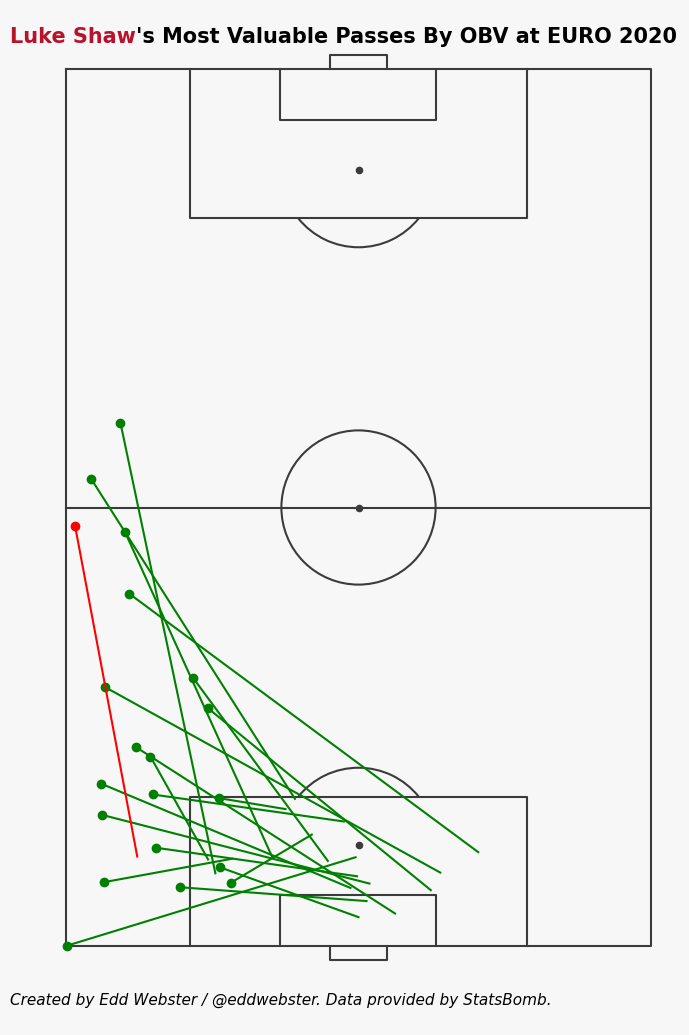

In [123]:
create_obv_passes_player(df=df_events,
                         player_name='Luke Shaw',
                         team_colour='#b8132d',
                         successful_pass_colour='green',
                         unsuccessful_pass_colour='red',
                         pitch_length_x=120,
                         pitch_length_y=80,
                         orientation='vertical',
                         aspect='fll',
                         n_passes=20
                        )

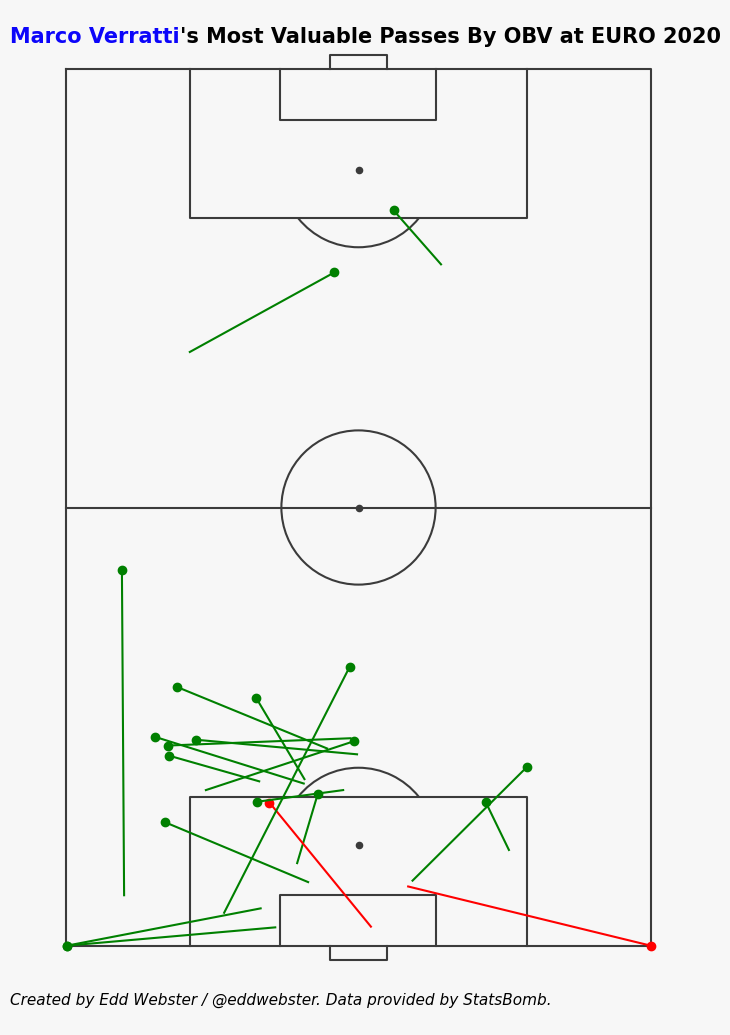

In [124]:
create_obv_passes_player(df=df_events,
                          player_name='Marco Verratti',
                          team_colour='#0c05fa',
                          successful_pass_colour='green',
                          unsuccessful_pass_colour='red',
                          pitch_length_x=120,
                          pitch_length_y=80,
                          orientation='vertical',
                          aspect='fll',
                          n_passes=20
                         )

---

<a id='section5'></a>

## <a id='#section5'>5. Summary</a>
This notebook visualises and analyses engineered [StatsBomb](https://statsbomb.com/) Event, 360, and OBV data from the [Open Data GitHub repository](https://github.com/statsbomb/open-data), using [pandas](http://pandas.pydata.org/) and [matplotlib](https://matplotlib.org/) for visualisation. The code from this notebook has been taken and productionised as a script - [`WebsterViz`](https://github.com/eddwebster/statsbomb/blob/main/scripts/WebsterViz.py), ready to be used for analysis.

---

<a id='section6'></a>

## <a id='#section6'>6. Next Steps</a>
The next stage is to analyse data and write a short analysis piece, that includes some data visualisations created with the [`WebsterViz`](https://github.com/eddwebster/statsbomb/blob/main/scripts/WebsterViz.py) script, derived in this notebook.

---

<a id='section7'></a>

## <a id='#section7'>7. References</a>

##### Data
*    [StatsBomb](https://statsbomb.com/) data
*    [StatsBomb open data](https://github.com/statsbomb/open-data/tree/master/data): A respository with StatsBomb open data.
*    [StatsBombPy](https://github.com/statsbomb/statsbombpy) | [StatsBombR](https://github.com/statsbomb/StatsBombR): Libraries to facilitate fetching StatsBomb data.
*    [Open Data Documentation](https://github.com/statsbomb/open-data/tree/master/doc):
     +    [Open Data Competitions v2.0.0](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Competitions%20v2.0.0.pdf).pdf describes the JSON format of the competitions.json file in the data.
     +    [Open Data Events v4.0.0](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Events%20v4.0.0.pdf).pdf describes the format of the event JSON files in the data/events/ directory.
     +    [Open Data Lineups v2.0.0](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Lineups%20v2.0.0.pdf).pdf describes the format of the lineup JSON files in the data/lineups/ folder.
     +    [Open Data Matches v3.0.0](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Matches%20v3.0.0.pdf).pdf describes the format of the match listing JSON files in the data/matches/ folder.
     +    [Open Data 360 Frames v1.0.0.pdf](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20360%20Frames%20v1.0.0.pdf) document describes the JSON format for StatsBomb’s open 360 data.
     +    [StatsBomb Open Data Specification v1.1](https://github.com/statsbomb/open-data/blob/master/doc/StatsBomb%20Open%20Data%20Specification%20v1.1.pdf).pdf gives detail about the meaning an attributes of specific events in the data.

##### Action Value Frameworks
*    [Introducing On-Ball Value (OBV)](https://statsbomb.com/2021/09/introducing-on-ball-value-obv/)

##### Visualisation
*    [How to Draw a Football Pitch](http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/) by Peter McKeever
*    [How To Create xG Flow Charts in Python](https://www.youtube.com/watch?v=bvoOOYMQkac) by [McKay Johns](https://twitter.com/mckayjohns). For code, see [[link](https://github.com/mckayjohns/Viz-Templates)]

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)